In [1]:
# Imports
import os
from pathlib import Path
import numpy as np
import pandas as pd
import scipy as sp
import scipy.sparse as sps
import matplotlib.pyplot as plt

import scanpy as sc
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import silhouette_score
from sklearn.feature_selection import f_classif

# Plot settings
sc.set_figure_params(dpi=120)
plt.rcParams['figure.figsize'] = (6, 4)


### Load data & quick inspection

In [ ]:
DATA_PATH_neu = '../data/GSE169569_GSE169570_neutrophils_bowel_disease-25.07.0.h5ad'
DATA_PATH_cov = '../data/GSE228841_PRJNA951718_COVID-19_vaccine-25.07.0.h5ad'


adata_neu= sc.read_h5ad(DATA_PATH_neu)
adata_cov = sc.read_h5ad(DATA_PATH_cov)
print(adata_neu)
print(adata_cov)
print('\n.obs columns:', list(adata_neu.obs.columns))
print('\n.var columns:', list(adata_neu.var.columns))
print('\n.obs columns:', list(adata_cov.obs.columns))
print('\n.var columns:', list(adata_cov.var.columns))


# Persist a copy we can modify for visualizations without touching your original on disk
neu_adata_proc = adata_neu.copy()
cov_adata_proc = adata_cov.copy()


AnnData object with n_obs × n_vars = 447 × 51777
    obs: 'total_counts_before_preprocessing', 'total_counts_after_trimming', 'total_counts_after_preprocessing', 'total_count_ratio__after_to_before', 'QC_mapping_ratio_bacterial', 'QC_mapping_ratio_viral', 'QC_mapping_ratio_miRNA', 'QC_mapping_ratio_sncRNA', 'Bases', 'Bytes', 'Avg_spot_length', 'BioProject', 'BioSample', 'Experiment', 'GEO_Accession_exp', 'SRA_study', 'Sample_name', 'Consent', 'Center_name', 'Organism', 'source_name', 'cohort', 'sex', 'age', 'treatment', 'diagnosis', 'Assay_type', 'Sequencer', 'Sample_type', 'Lab_library_layout', 'Lab_library_selection', 'Lab_library_source', 'Lab_RNA_extraction_protocol', 'Lab_Blocking_State', 'Lab_library_preparation_kit', 'Release_date', 'create_date', 'version', 'total_count'
    var: 'length', 'g_fraction', 'a_fraction', 't_fraction', 'c_fraction', 'gc_fraction', 'MFE_37', 'spikein', 'qiaseq_spikein', 'hbdx_spikein', 'hbdx_spikein_prefix_length', 'hbdx_spikein_suffix_length', 'hbdx

In [17]:
DATASETS = {
    "neu": neu_adata_proc,
    "cov": cov_adata_proc,
}

### Zero fraction

- **Per-sample zero fraction**: fraction of genes with zero counts per sample.
- **Per-gene zero fraction**: fraction of cells with zero counts per gene.

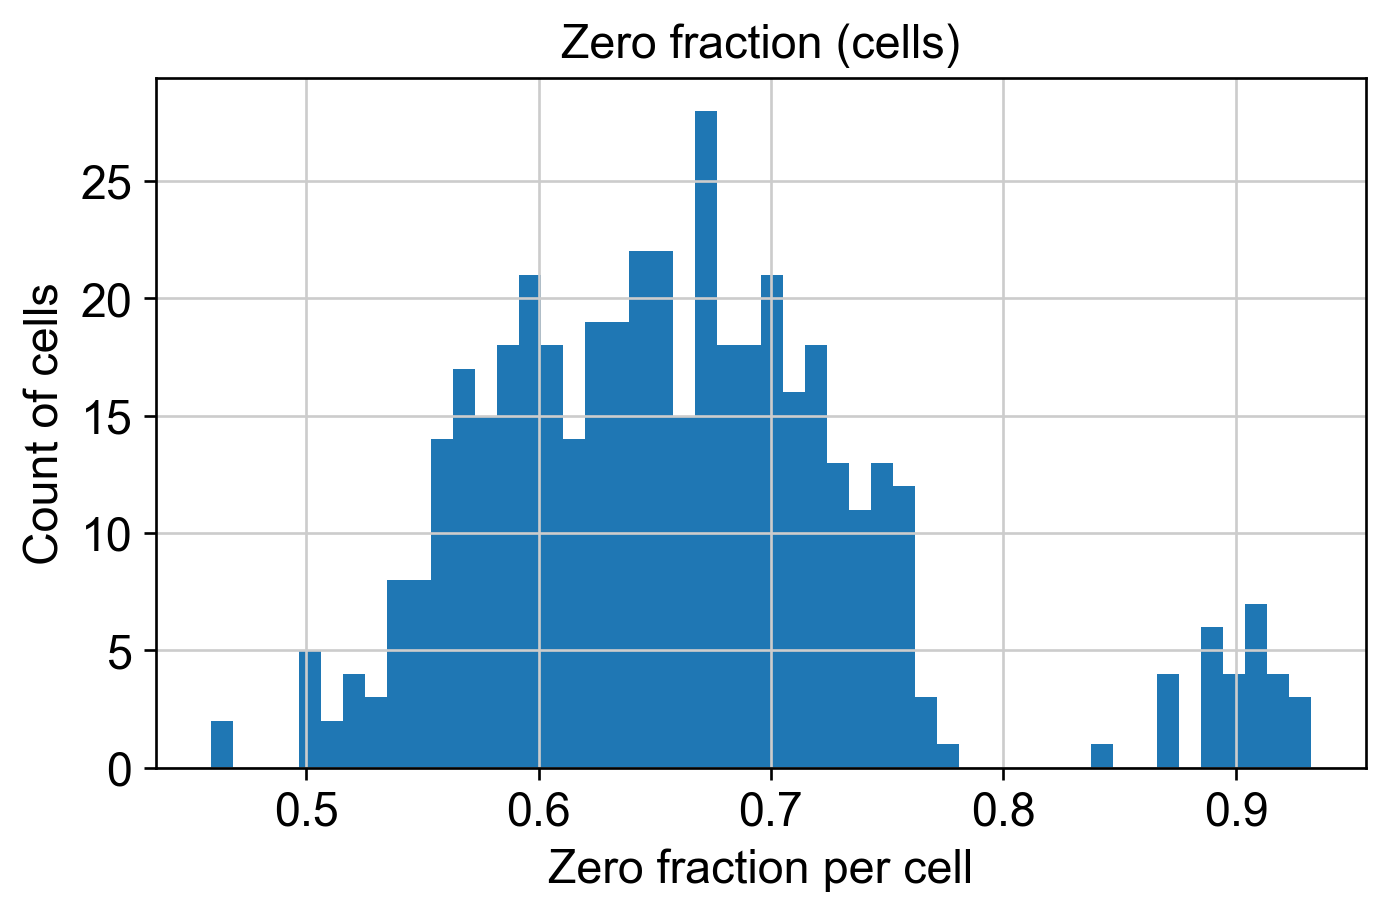

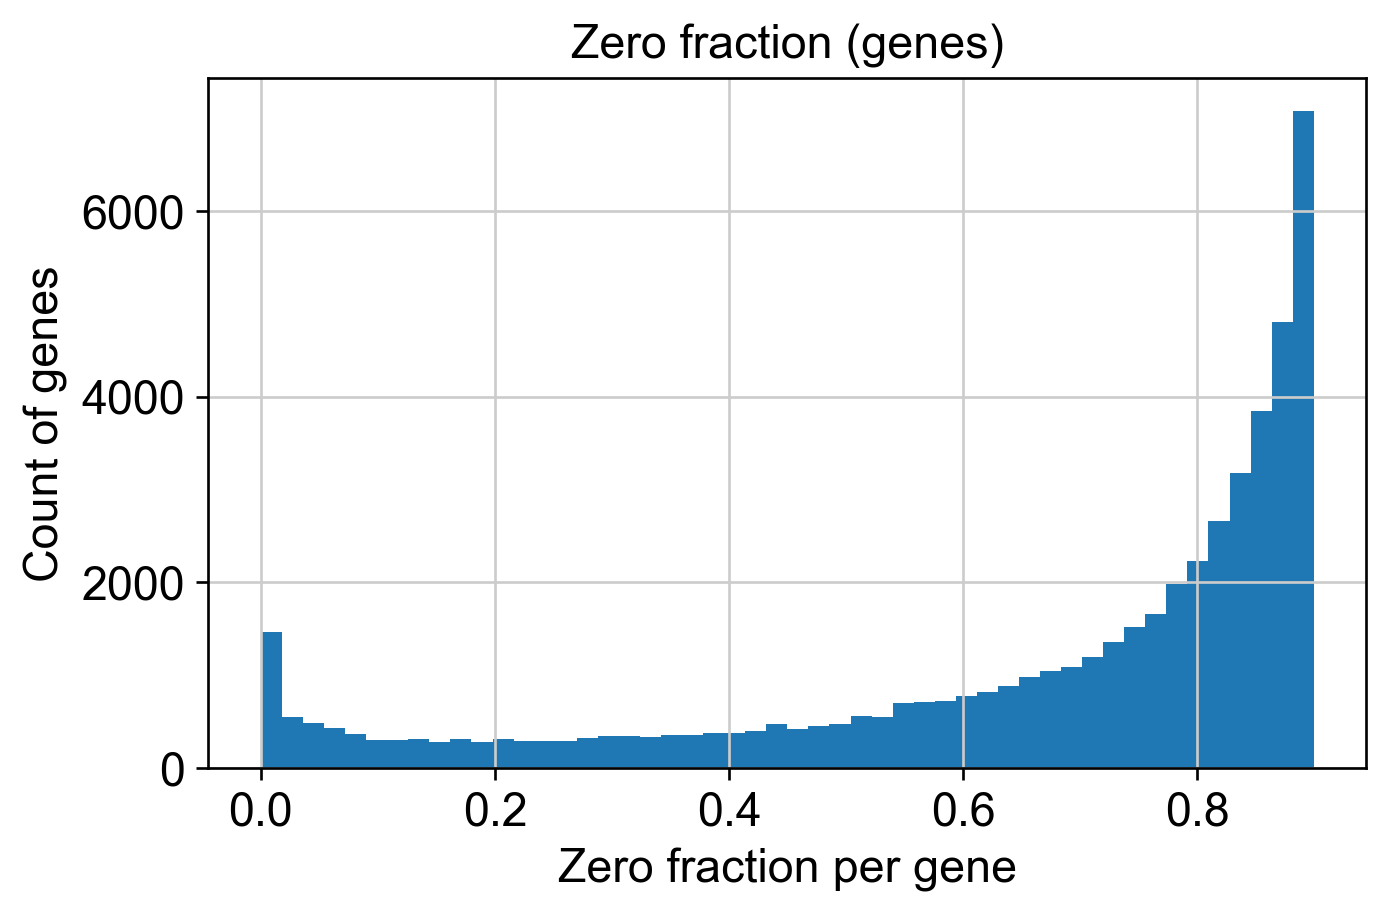

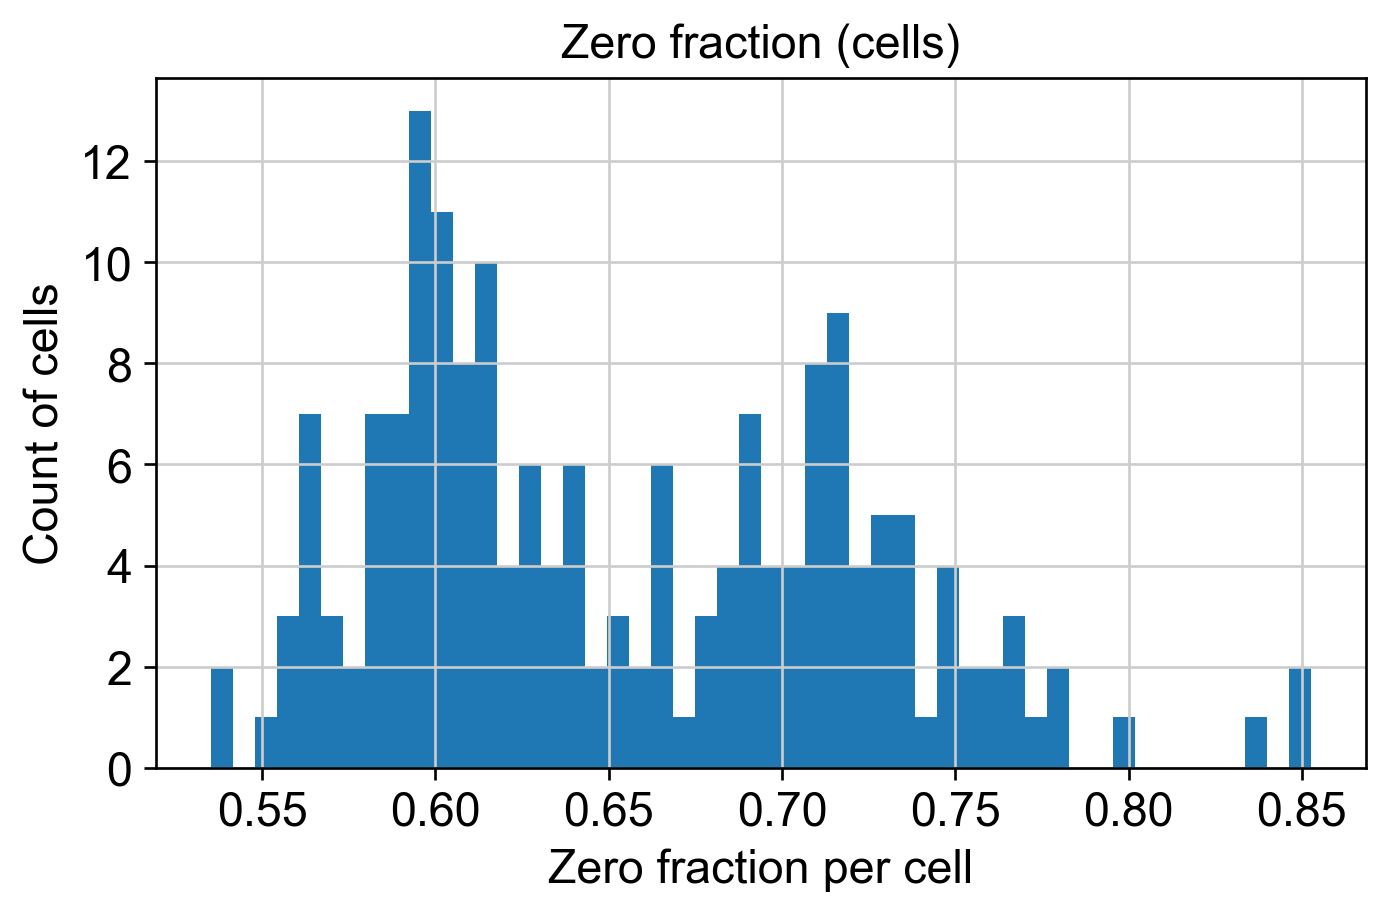

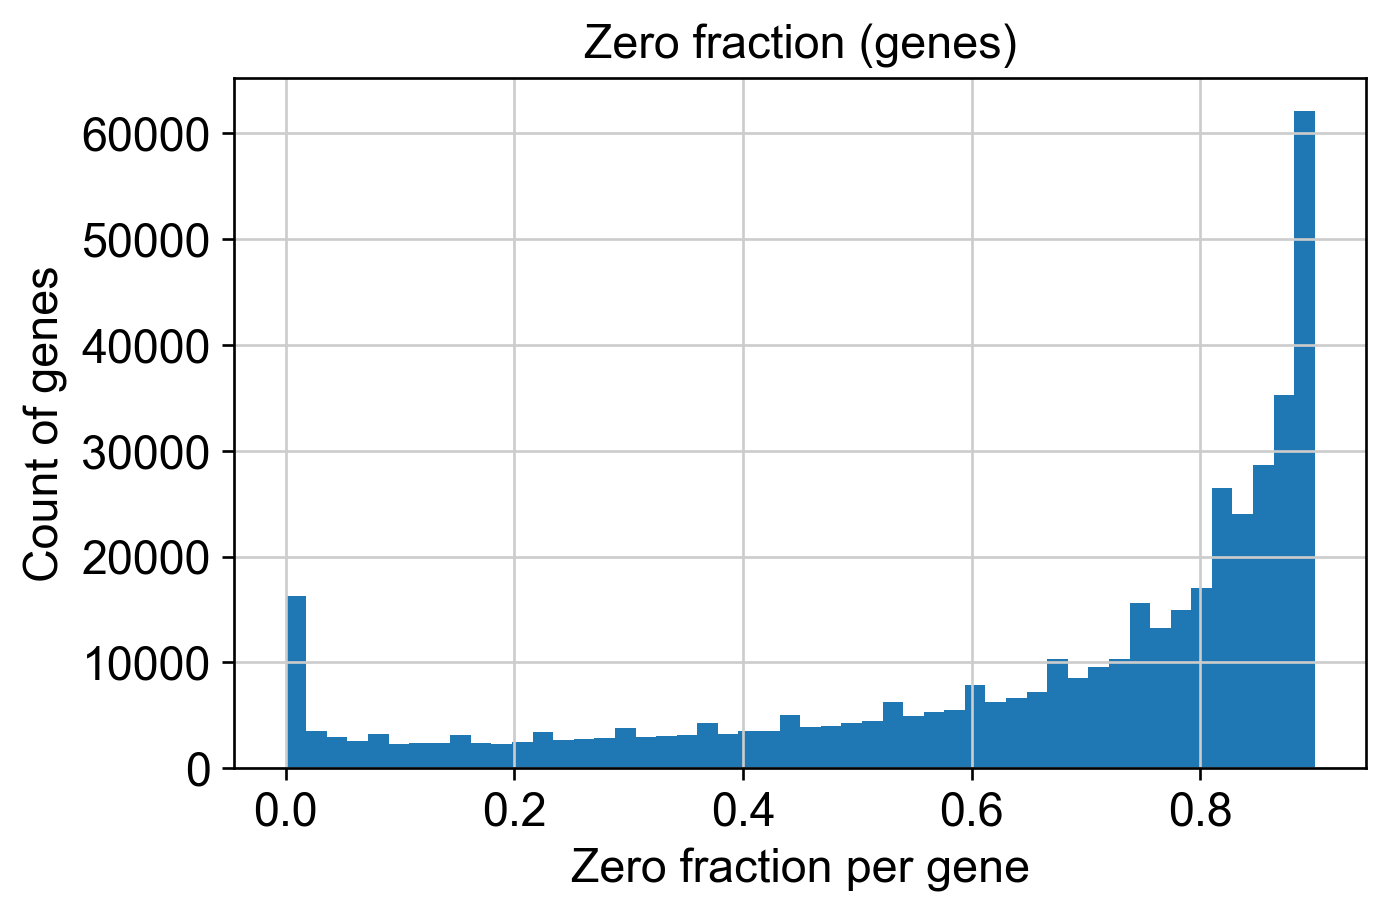

In [12]:
def zero_fraction_cell(X):
    if sps.issparse(X):
        zeros = X.shape[1] - (X != 0).sum(axis=1).A.ravel()
        return zeros / X.shape[1]
    else:
        return (X == 0).sum(axis=1) / X.shape[1]

def zero_fraction_gene(X):
    if sps.issparse(X):
        zeros = X.shape[0] - (X != 0).sum(axis=0).A.ravel()
        return zeros / X.shape[0]
    else:
        return (X == 0).sum(axis=0) / X.shape[0]

for adata_proc in [neu_adata_proc, cov_adata_proc]:
    adata_proc.obs['zero_frac_cell'] = zero_fraction_cell(adata_proc.X)
    adata_proc.var['zero_frac_gene'] = zero_fraction_gene(adata_proc.X)

    # Histograms
    fig, ax = plt.subplots()
    ax.hist(adata_proc.obs['zero_frac_cell'], bins=50)
    ax.set_xlabel('Zero fraction per cell')
    ax.set_ylabel('Count of cells')
    ax.set_title('Zero fraction (cells)')
    plt.tight_layout()
    plt.show()

    fig, ax = plt.subplots()
    ax.hist(adata_proc.var['zero_frac_gene'], bins=50)
    ax.set_xlabel('Zero fraction per gene')
    ax.set_ylabel('Count of genes')
    ax.set_title('Zero fraction (genes)')
    plt.tight_layout()
    plt.show()


/Users/mjlee/master_thesis/Thesis_project/thesispjt/thesis-impute/lib/python3.12/site-packages/legacy_api_wrap/__init__.py:82: UserWarning: `flavor='seurat_v3'` expects raw count data, but non-integers were found.
  return fn(*args_all, **kw)


HVGs identified: 4000


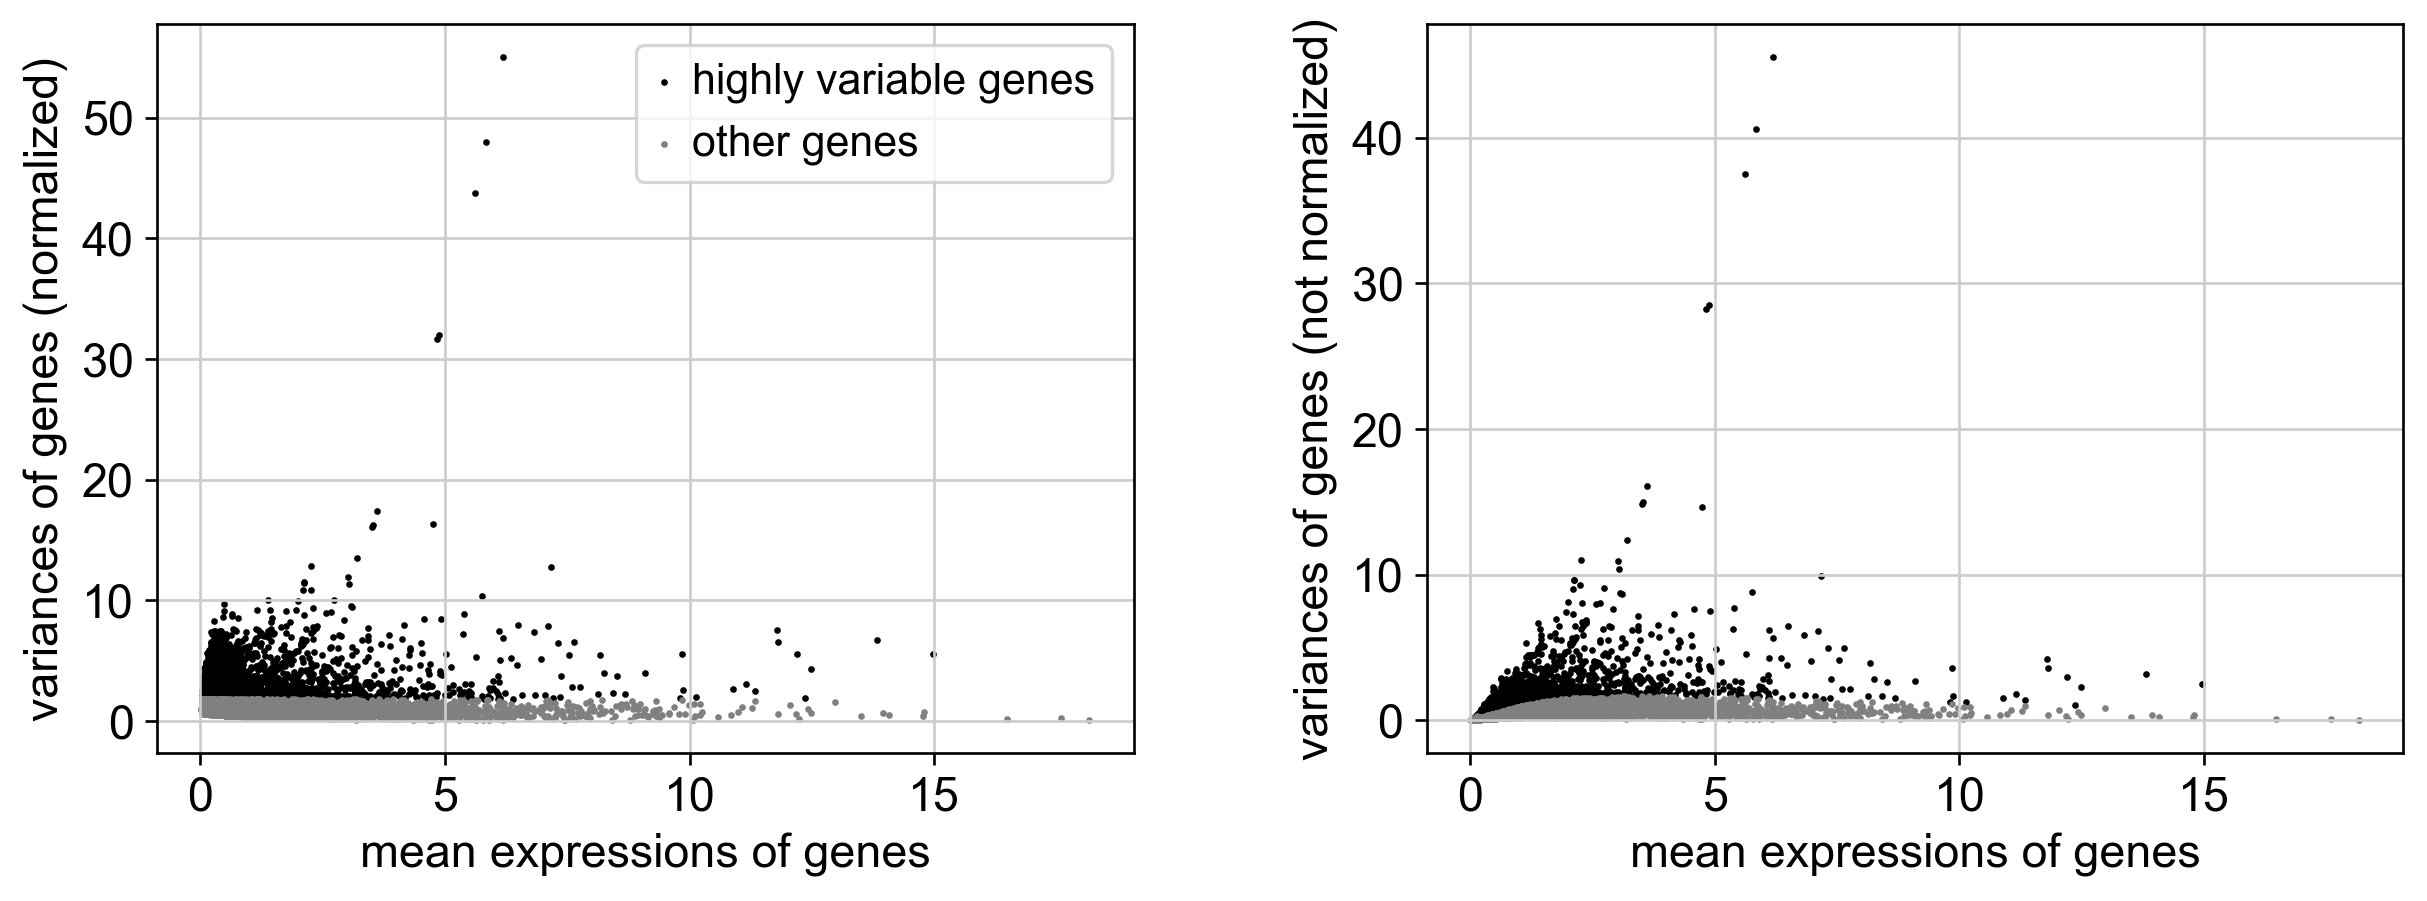

/Users/mjlee/master_thesis/Thesis_project/thesispjt/thesis-impute/lib/python3.12/site-packages/legacy_api_wrap/__init__.py:82: UserWarning: `flavor='seurat_v3'` expects raw count data, but non-integers were found.
  return fn(*args_all, **kw)


HVGs identified: 4000


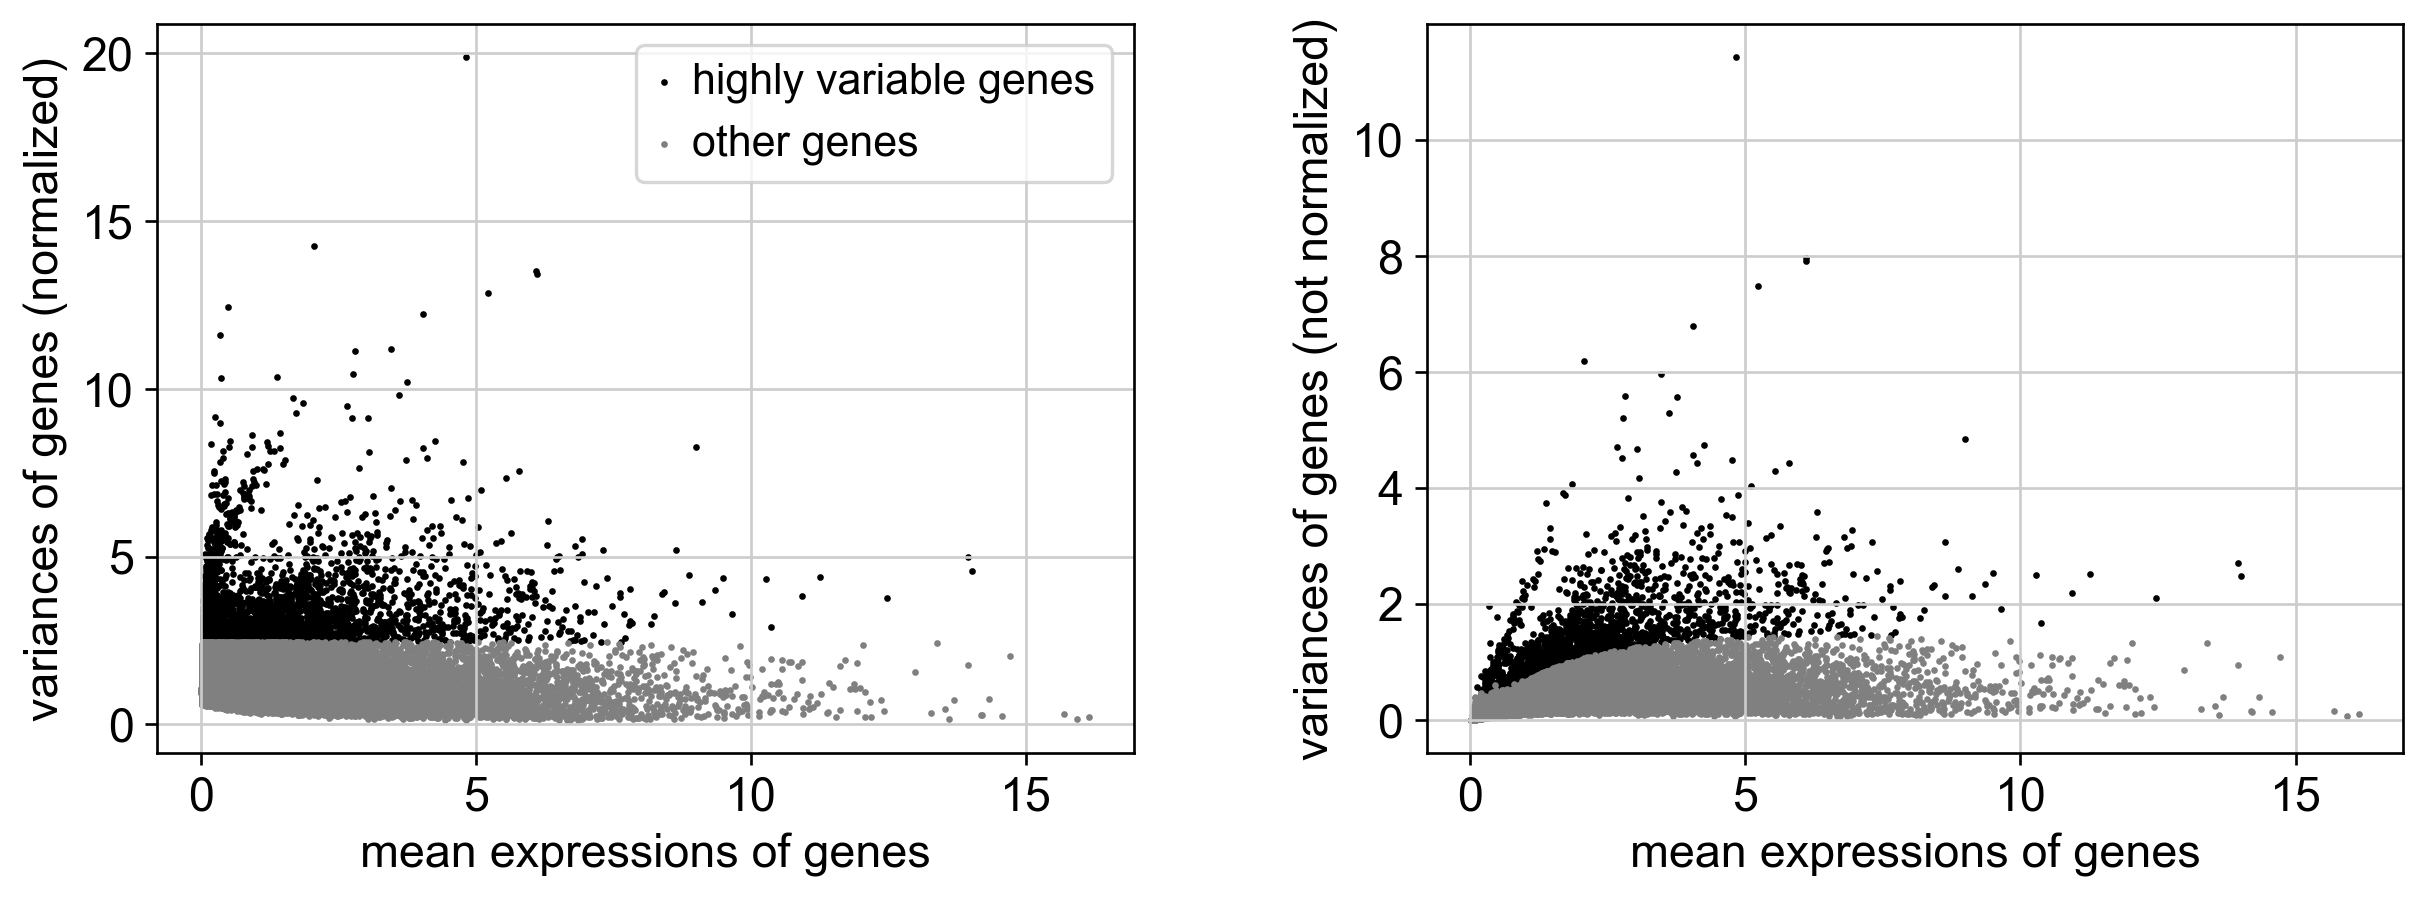

In [ ]:
for adata_proc in [neu_adata_proc, cov_adata_proc]:
    
    sc.pp.highly_variable_genes(adata_proc, flavor='seurat_v3', n_top_genes=4000, subset=False, inplace=True)
    print('HVGs identified:', adata_proc.var['highly_variable'].sum())

    try:
        sc.pl.highly_variable_genes(adata_proc, save=False)
        plt.show()
    except Exception as e:
        print('HVG plot skipped:', e) 

PCA, t-SNE/UMAP 
RLE plot / expression dist box/density
variance explained (Variance contribution)
    - ANOVA
p-value
QC(boxplot, density plot)
Clustering(heatmap, hierarchical clustering)

Batch mixture(probability of prediction)
kBET acceptance rate
iLISI
sLISI

** Importatnt: DE(Differential expression analysis!! using volcano plot)

In [23]:
N_PCS = 30
RANDOM_STATE = 42
MAX_CELLS_FOR_TSNE = 120000  # downsample t-SNE if you have more cells
ASSUME_X_IS_COUNTS = True    # set False if .X is already log-normalized
BATCH_KEYS = ['Center_name','Sequencer','Lab_library_preparation_kit','Lab_RNA_extraction_protocol',
    'Lab_library_selection','Lab_library_source','Assay_type',
    'Lab_library_layout','Sample_type','Experiment','SRA_study','BioProject']  # or a single string, or []
# Center_name, Sequencer, Lab_library_preparation_kit, Lab_RNA_extraction_protocol, Lab_library_selection, Lab_library_source, Assay_type


=== Running report for: neutrophil ===


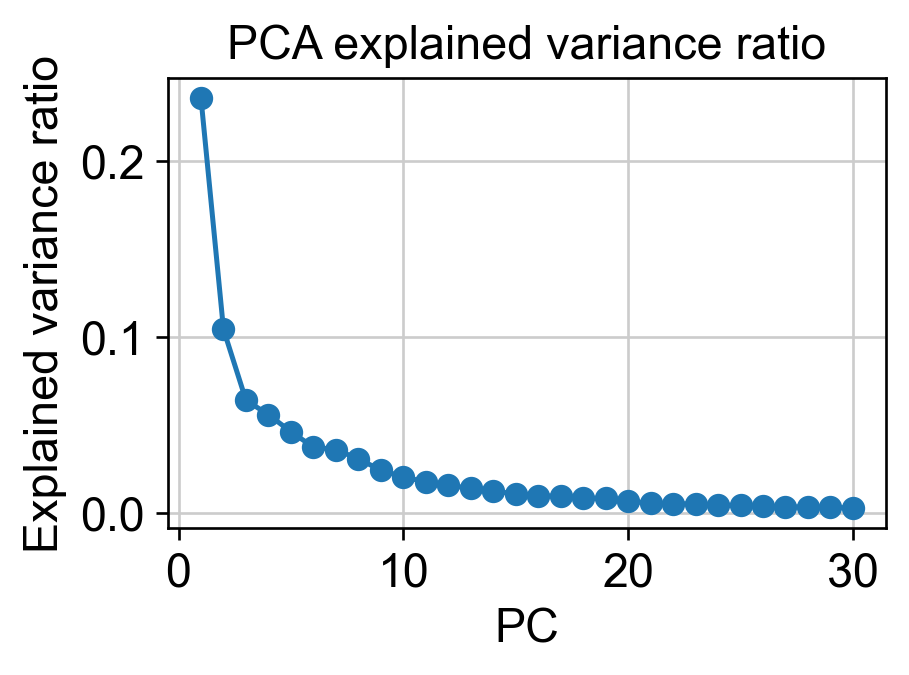

/Users/mjlee/master_thesis/Thesis_project/thesispjt/thesis-impute/lib/python3.12/site-packages/sklearn/manifold/_spectral_embedding.py:328: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


[neutrophil] usable batch keys: ['Experiment', 'SRA_study', 'BioProject']
[neutrophil] audit saved → eda_outputs/report_neutrophil/batch_key_audit.csv
[neutrophil] metrics saved → eda_outputs/report_neutrophil/batch_metrics_all_existing_keys.csv


/Users/mjlee/master_thesis/Thesis_project/thesispjt/thesis-impute/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:106: RuntimeWarning: divide by zero encountered in divide
  msb = ssbn / float(dfbn)
/Users/mjlee/master_thesis/Thesis_project/thesispjt/thesis-impute/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/Users/mjlee/master_thesis/Thesis_project/thesispjt/thesis-impute/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/Users/mjlee/master_thesis/Thesis_project/thesispjt/thesis-impute/lib/python3.12/site-pac

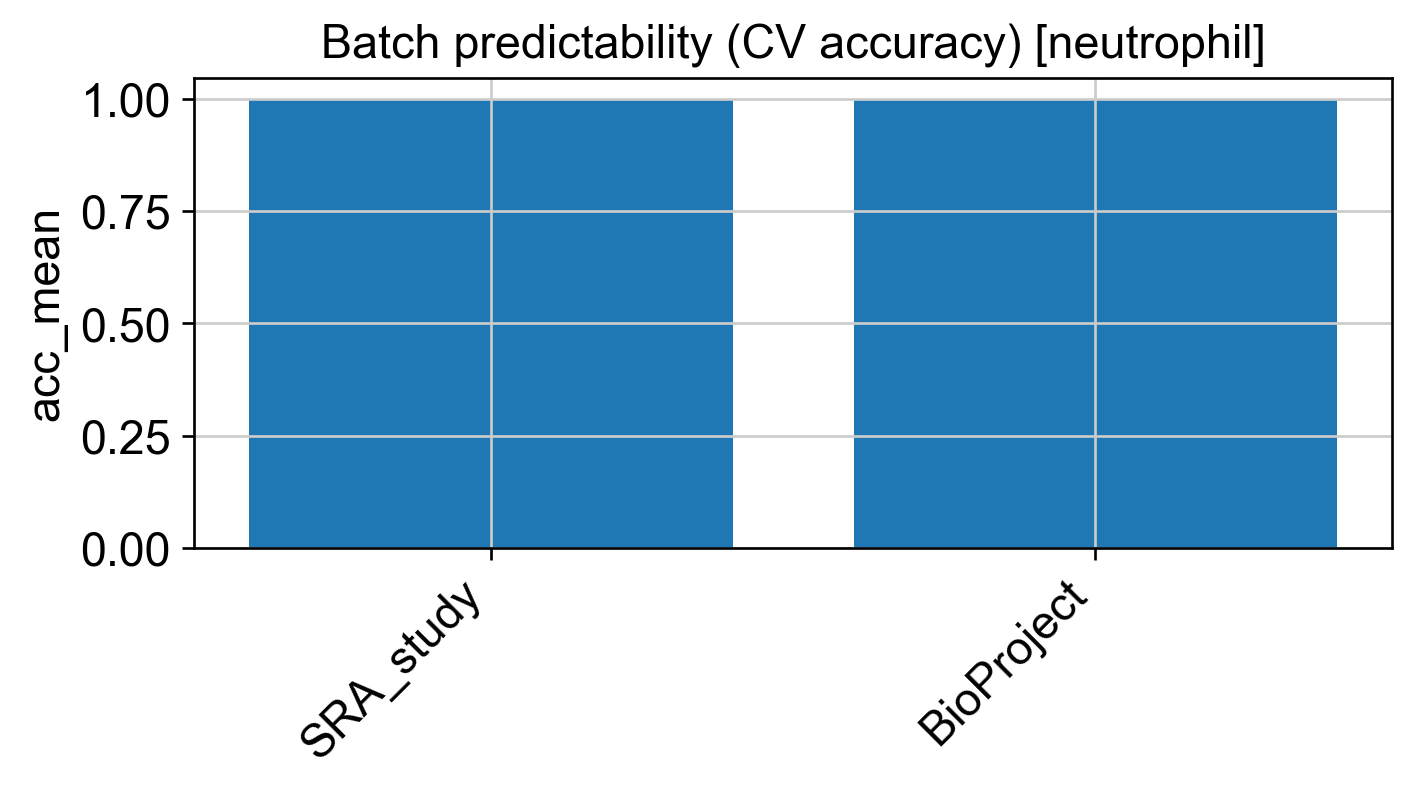

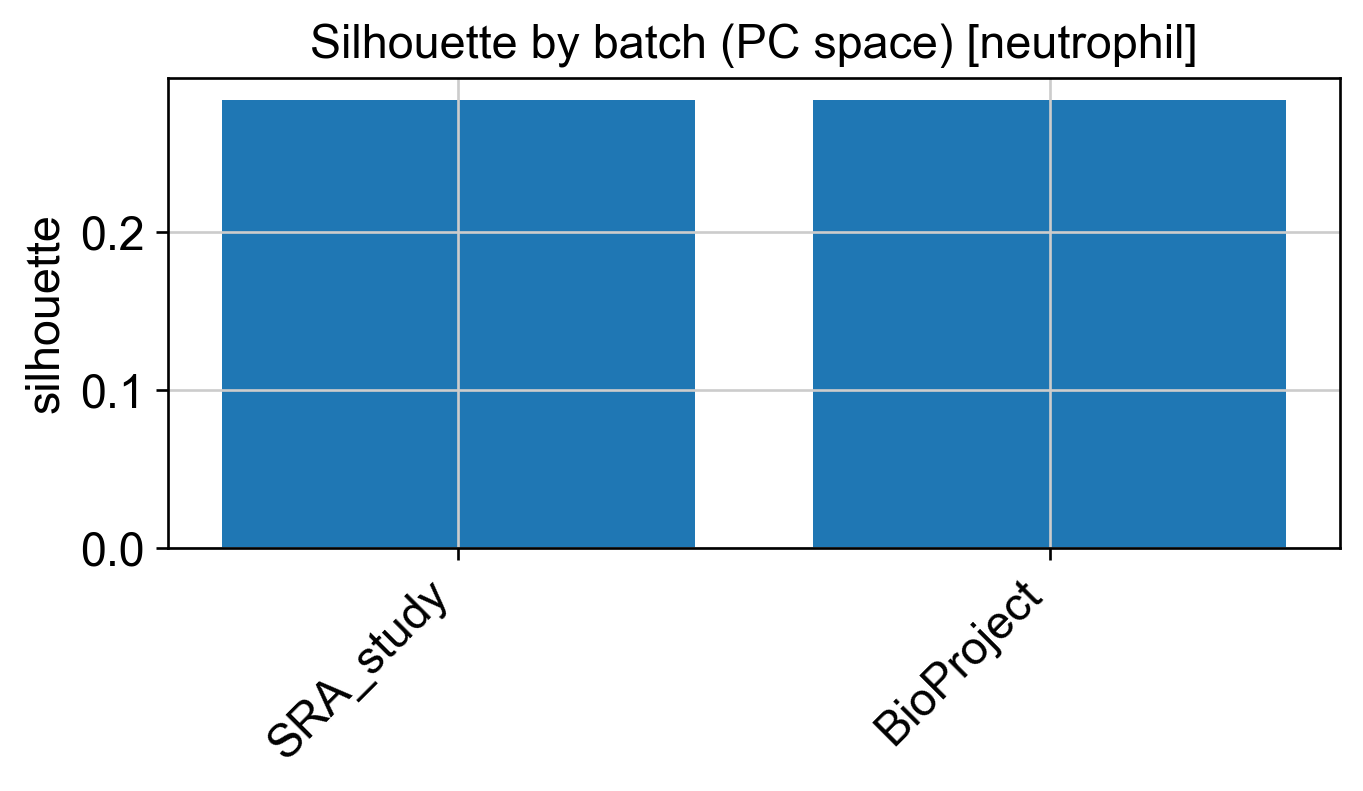

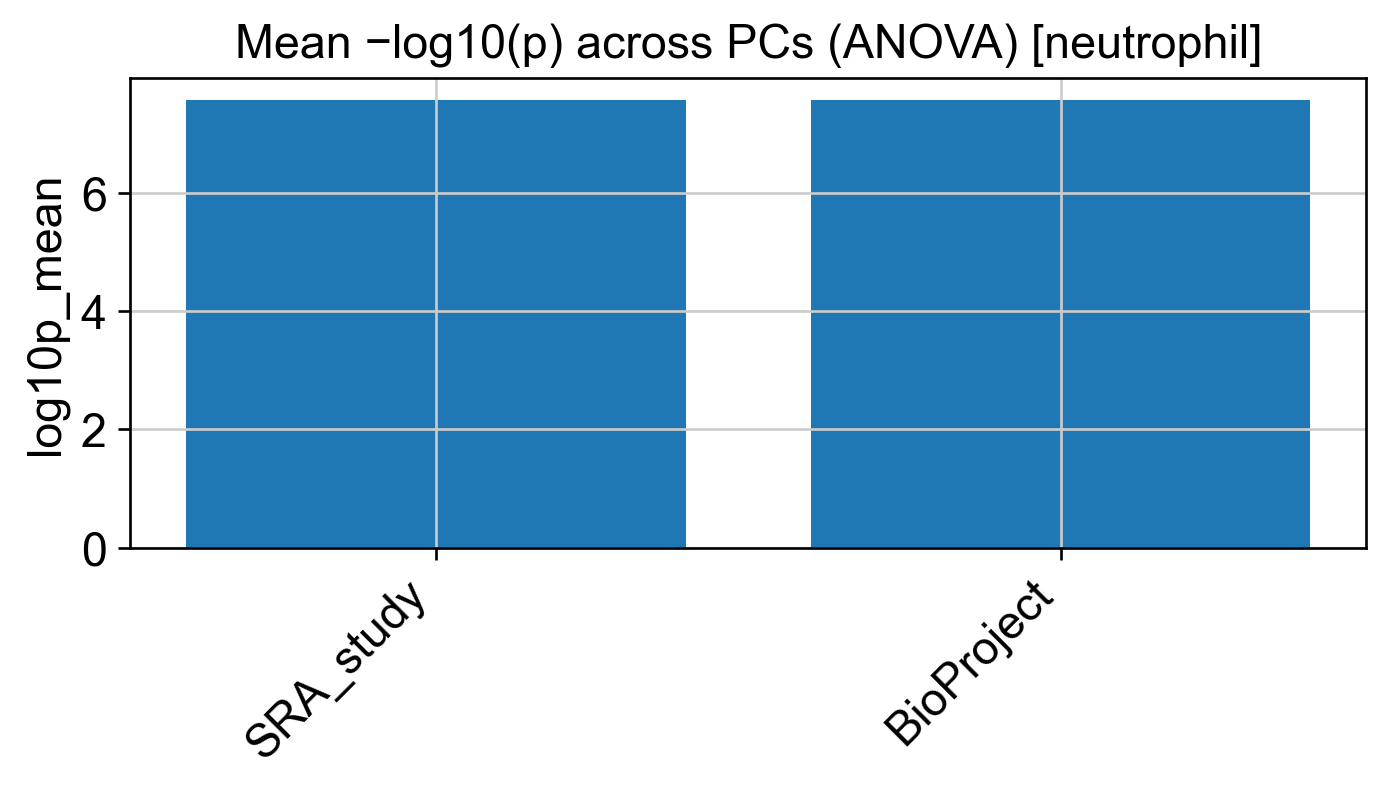

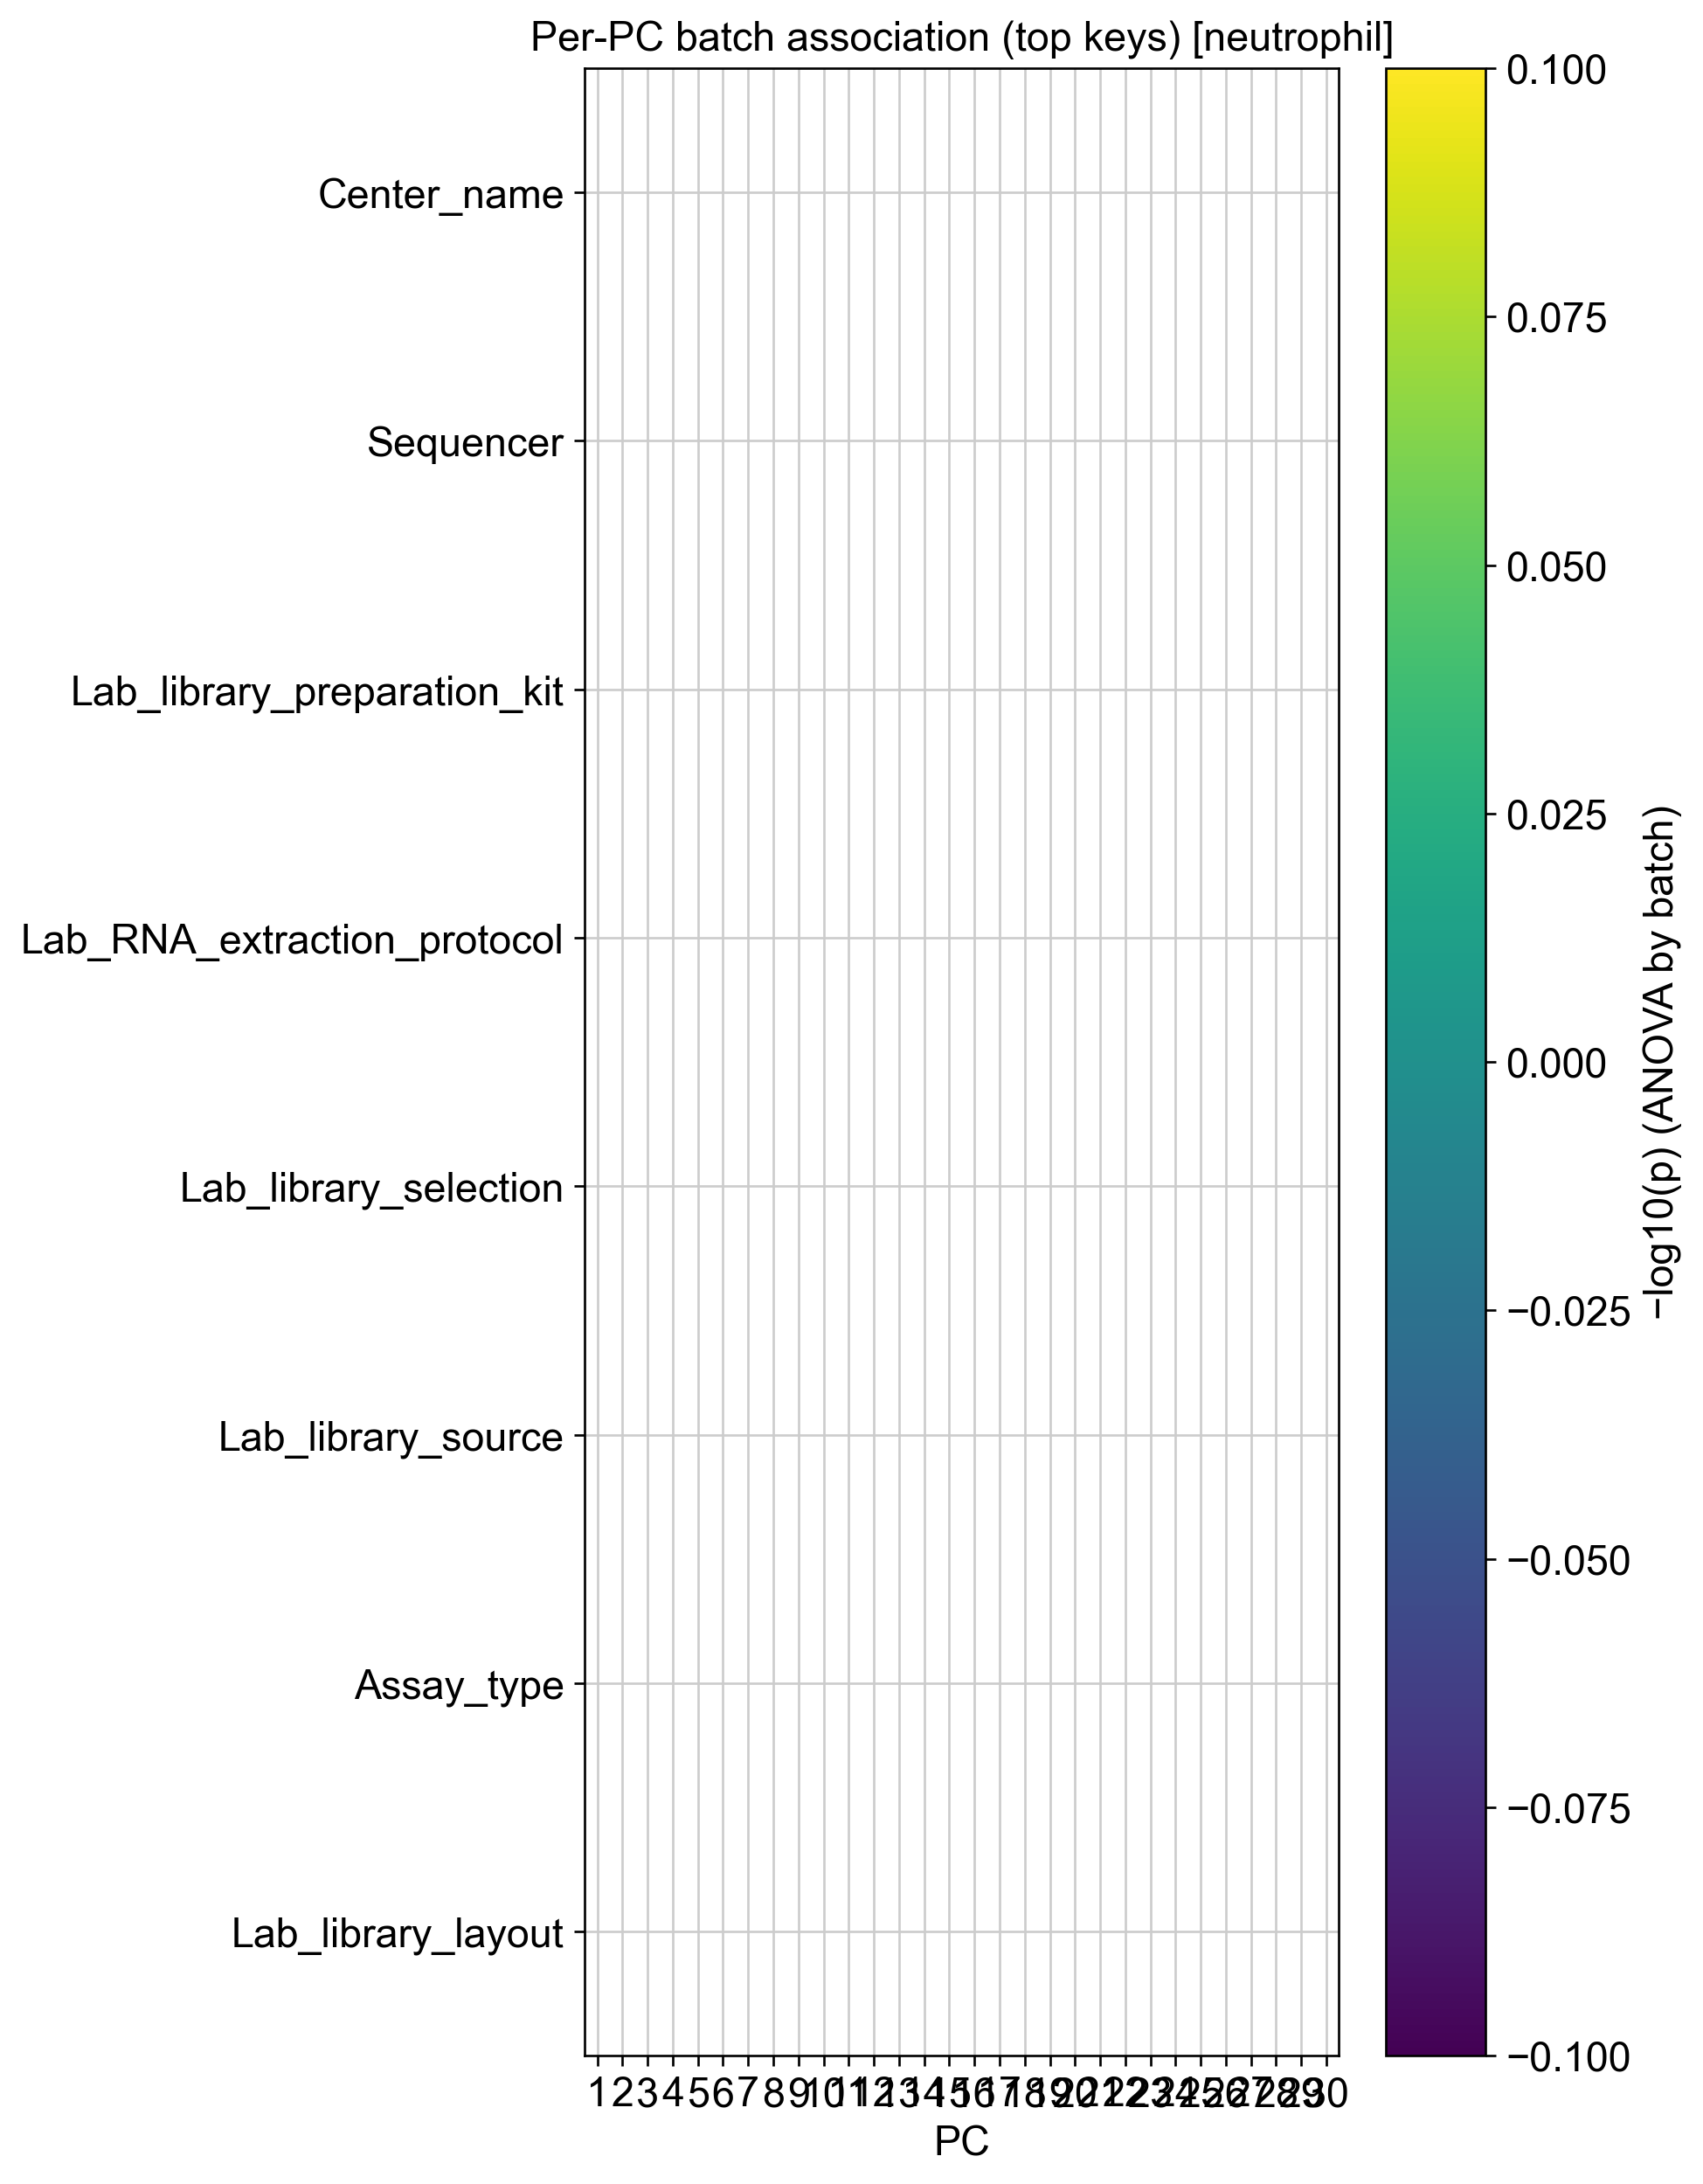

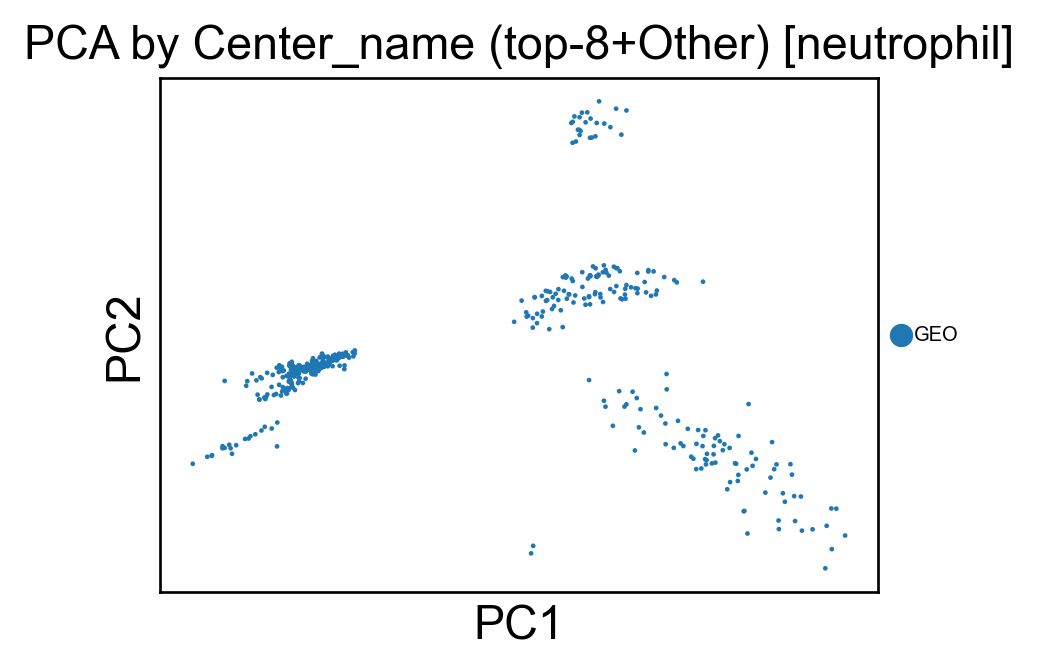

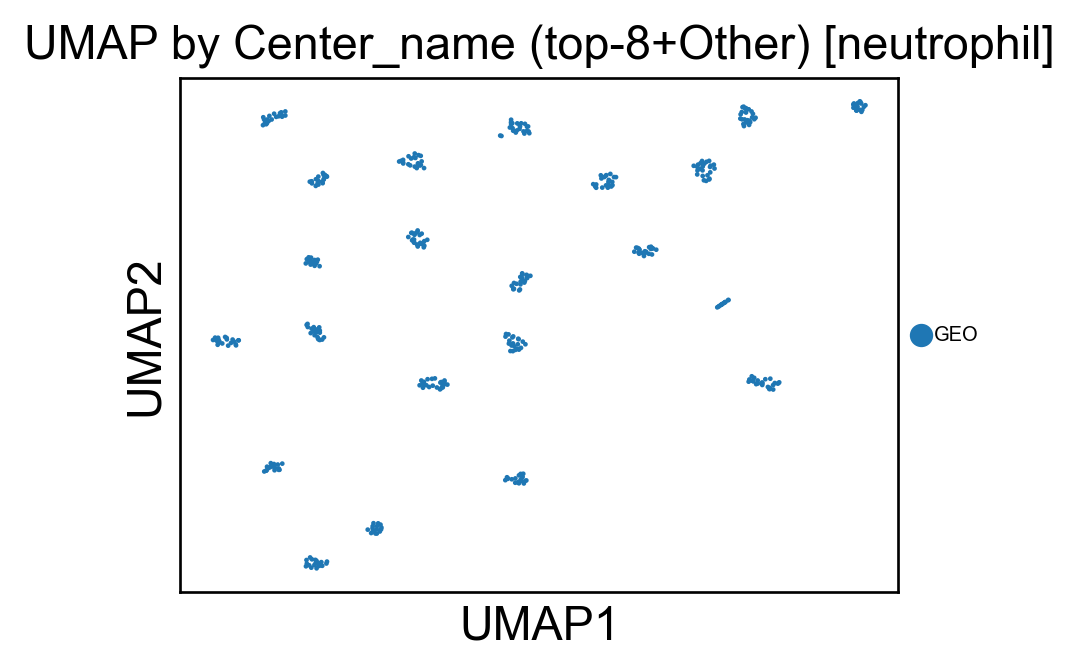

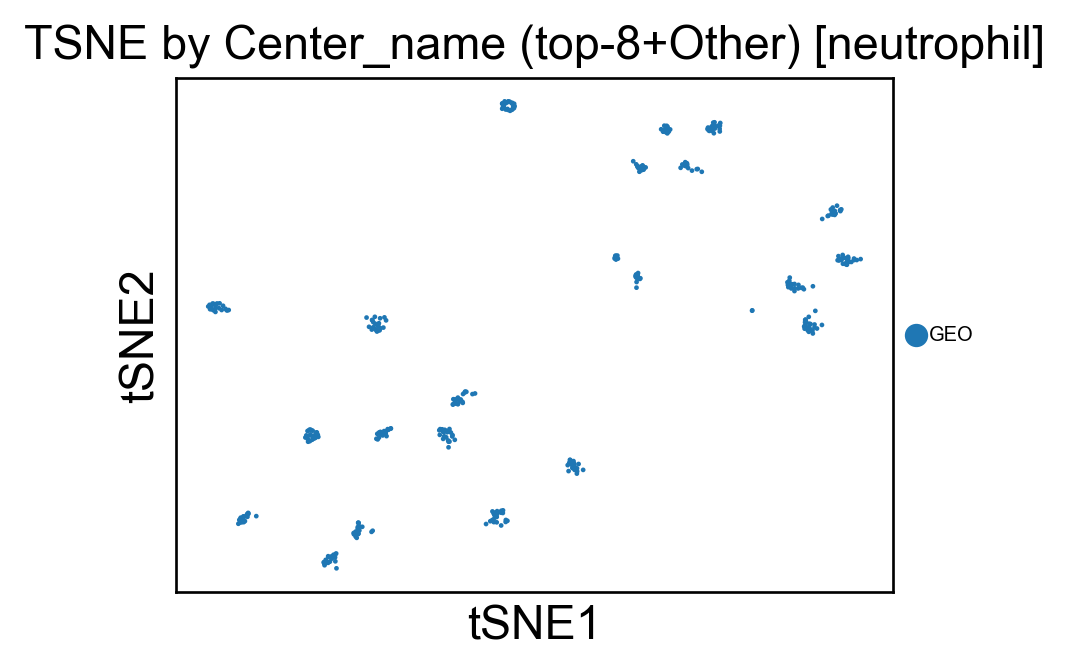

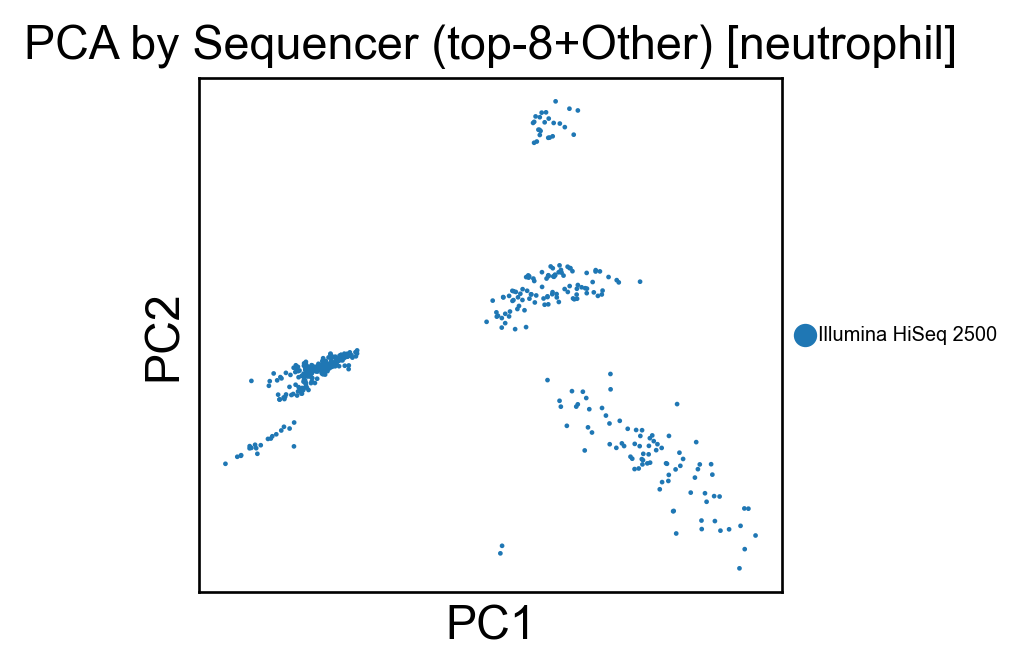

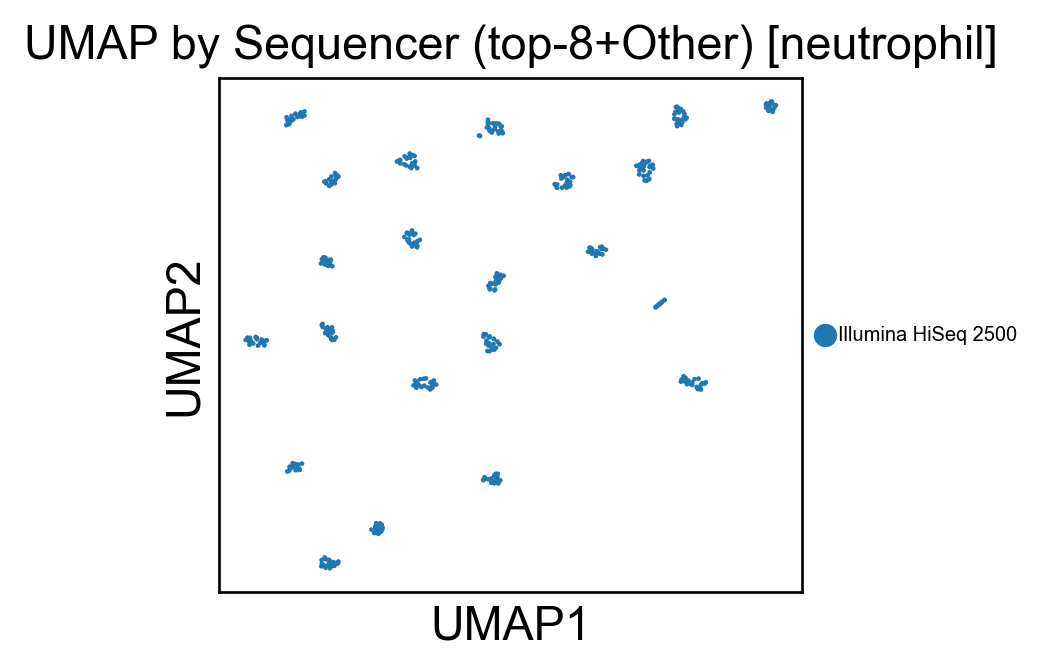

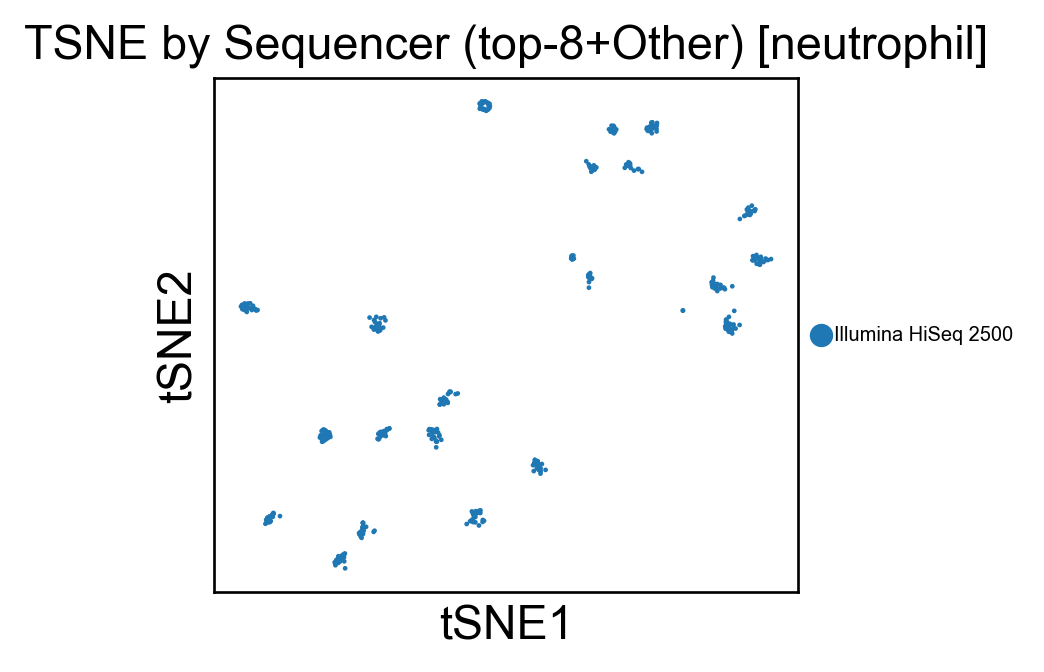

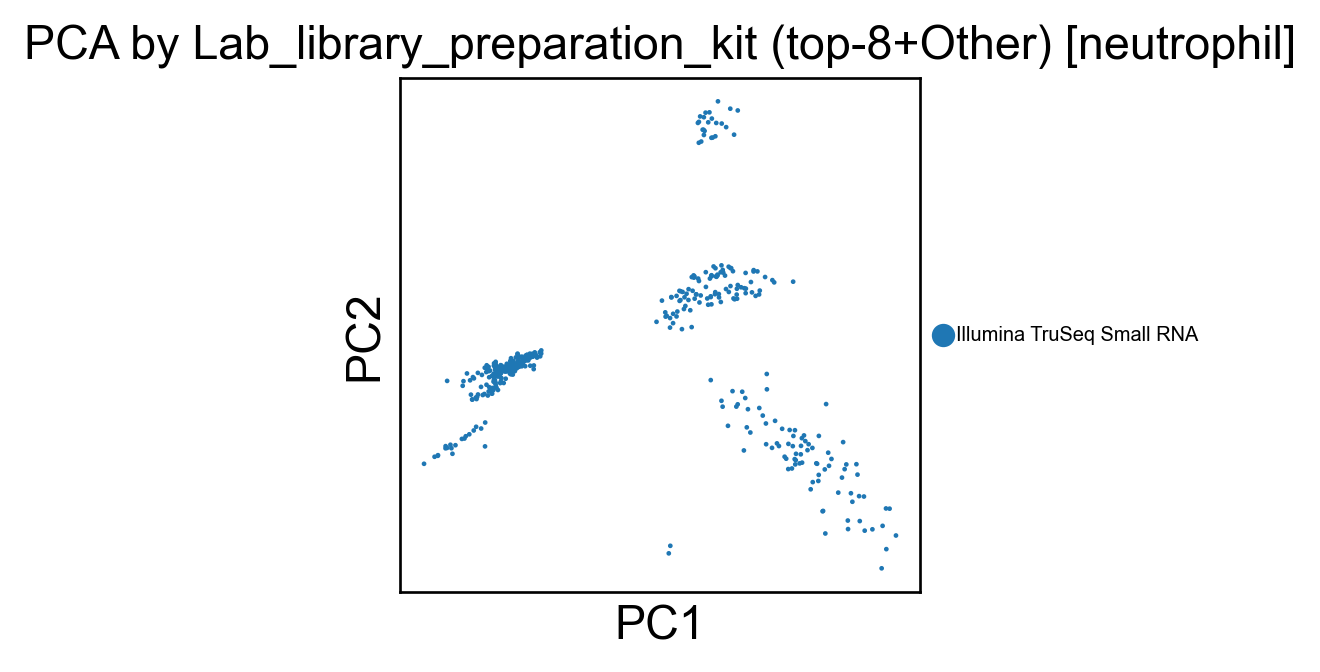

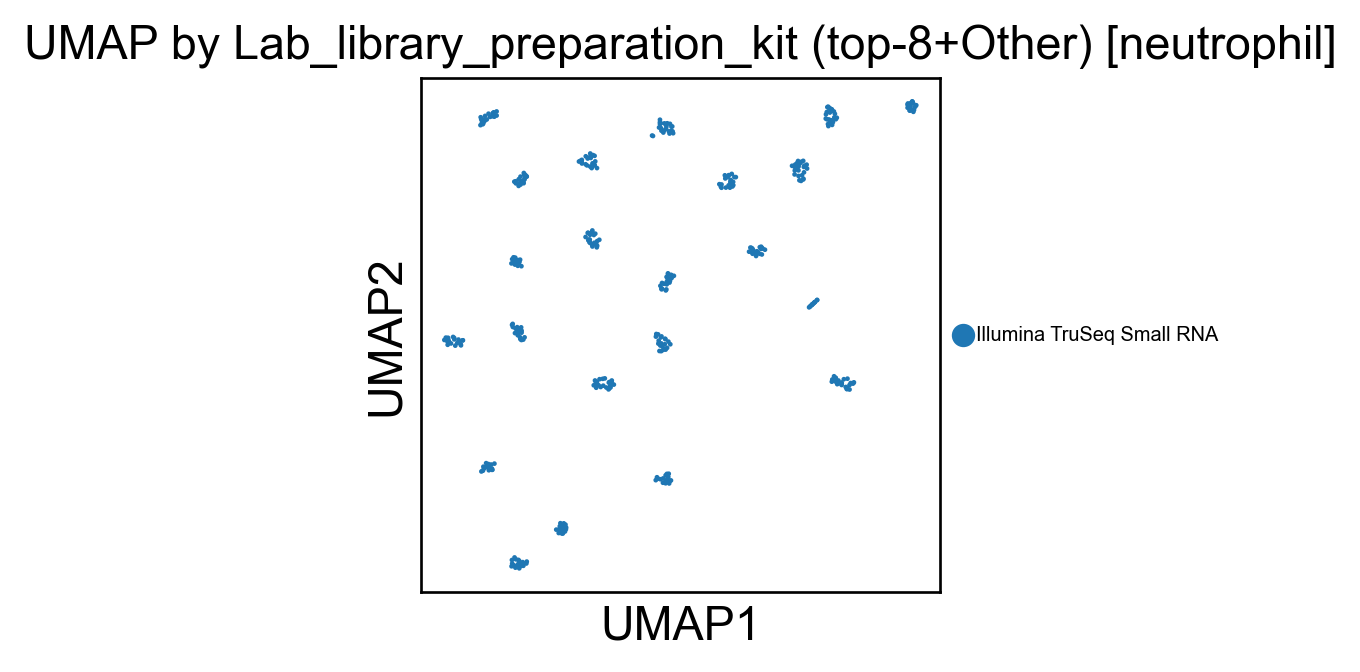

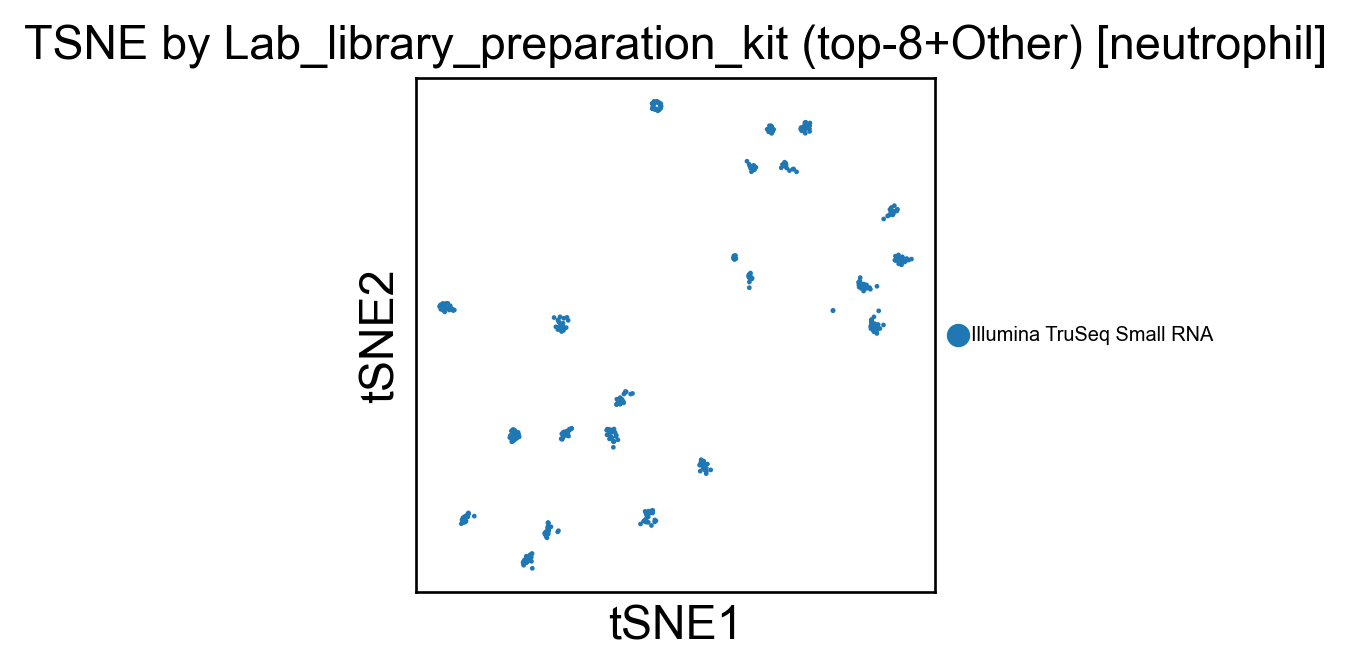

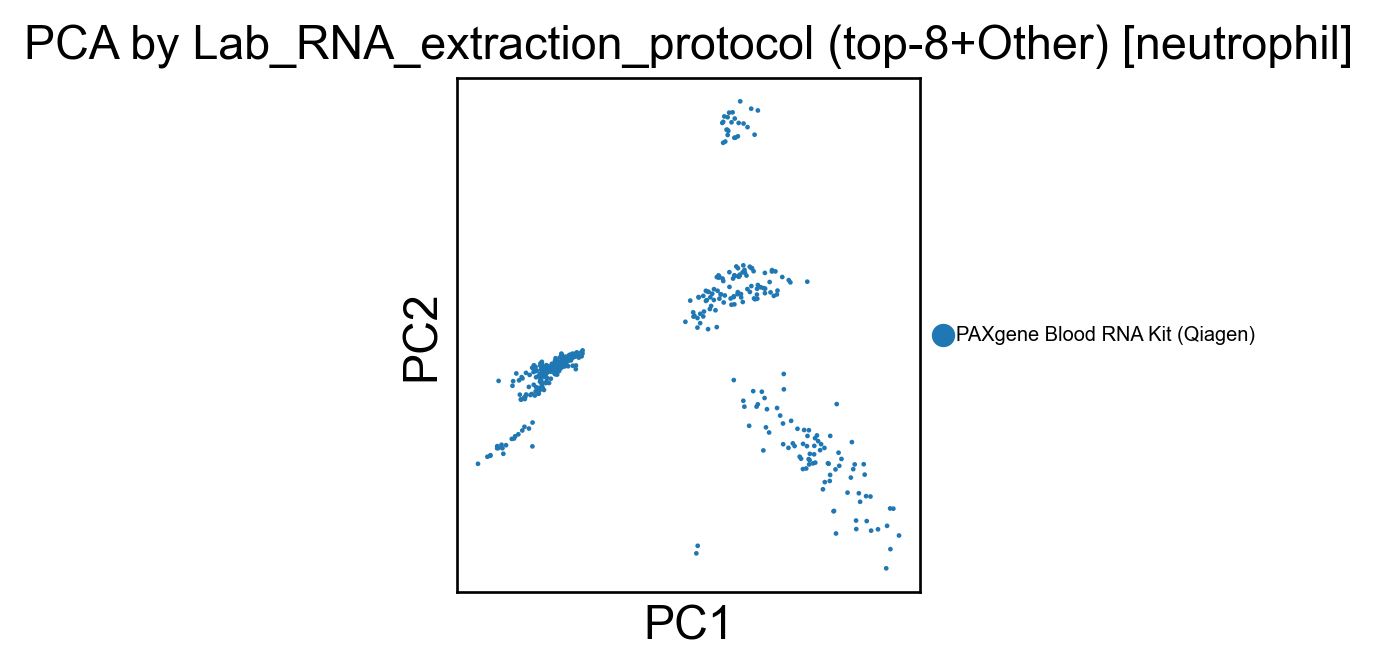

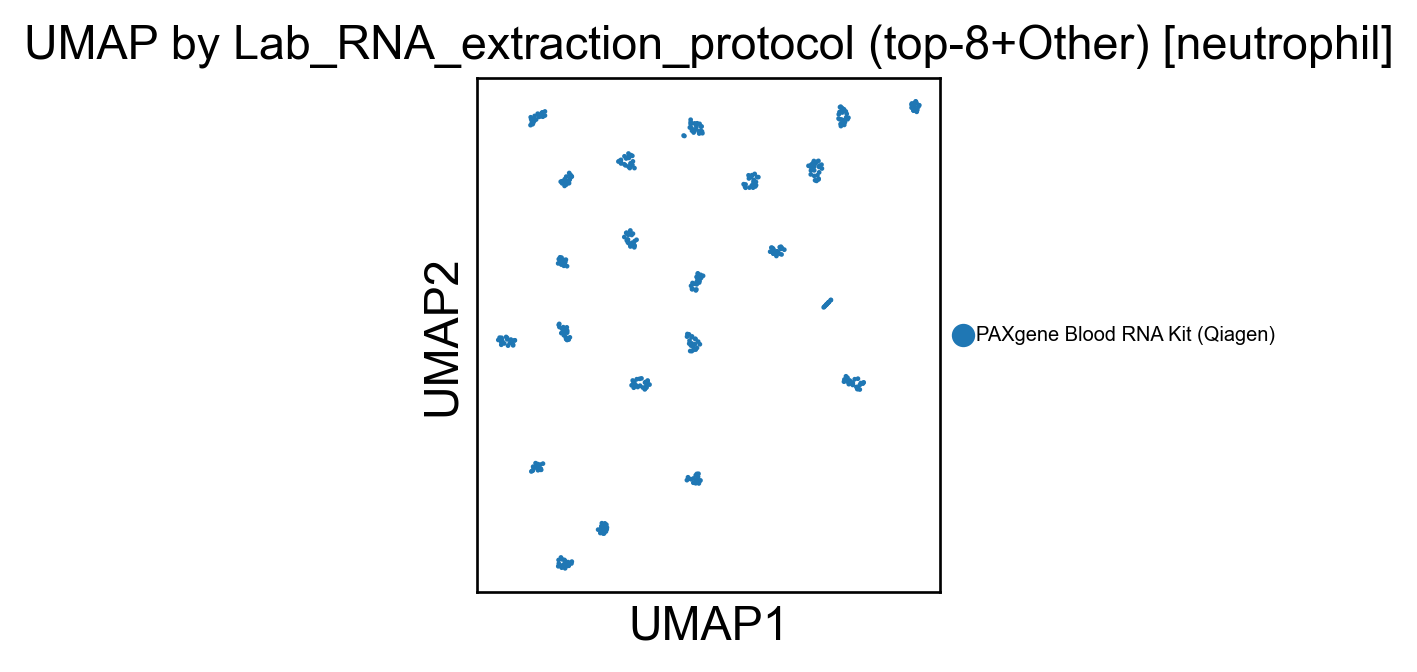

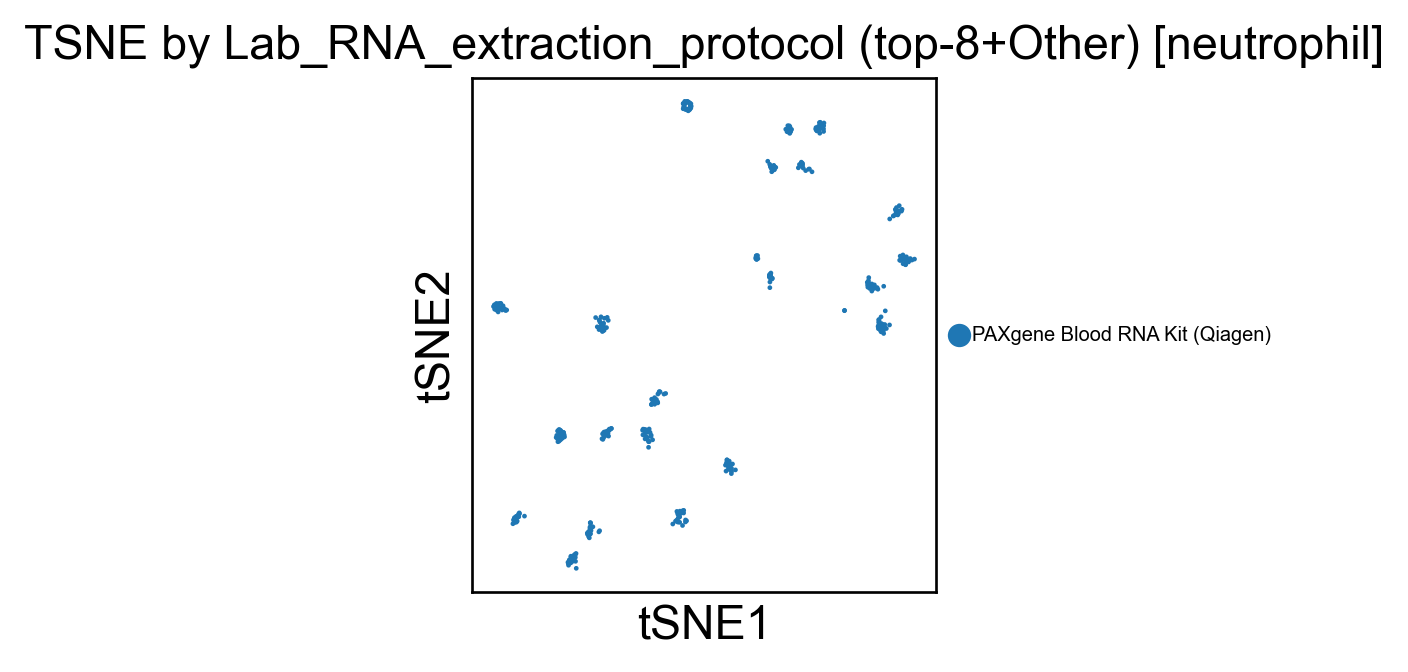

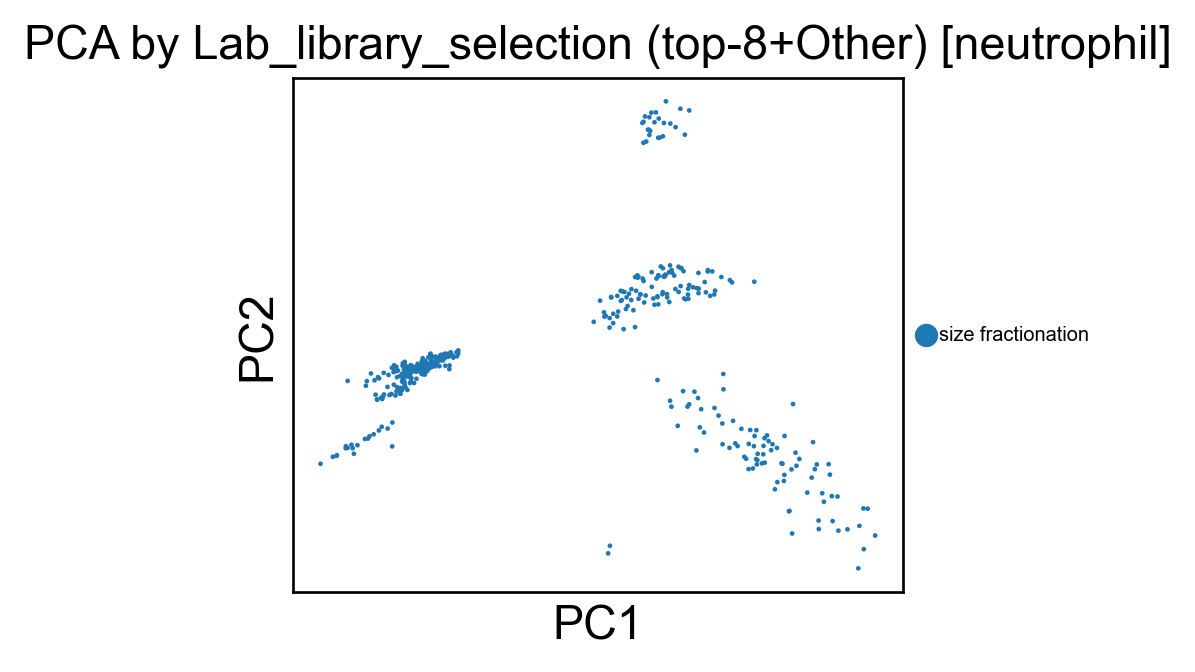

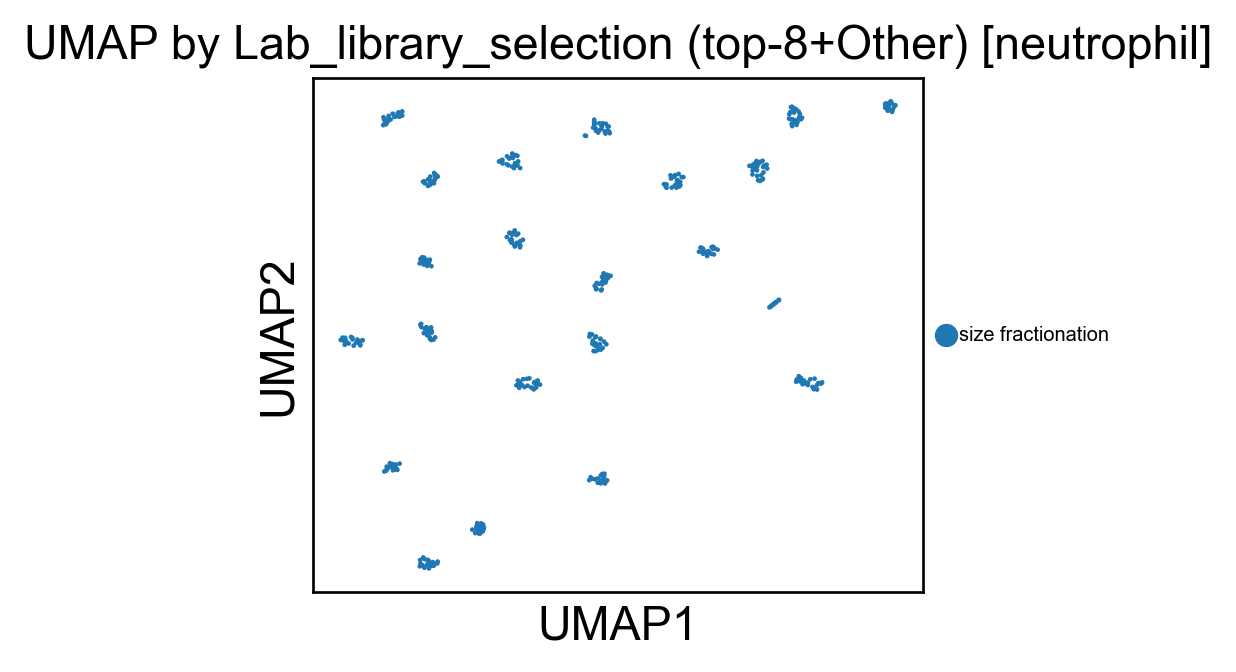

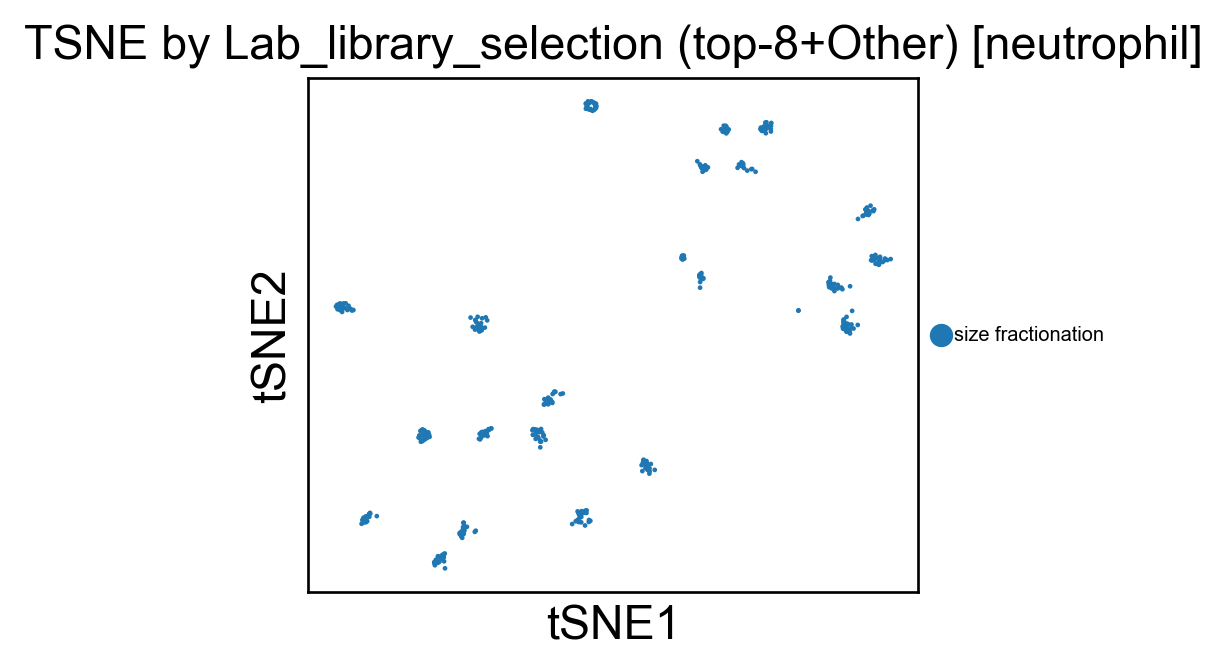

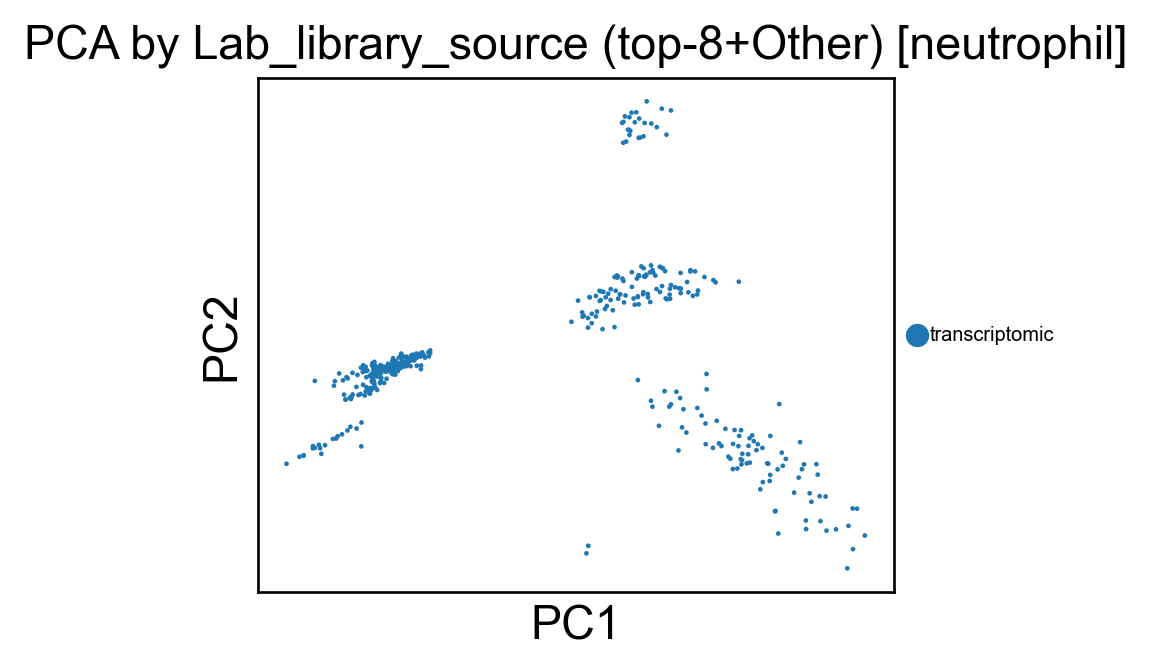

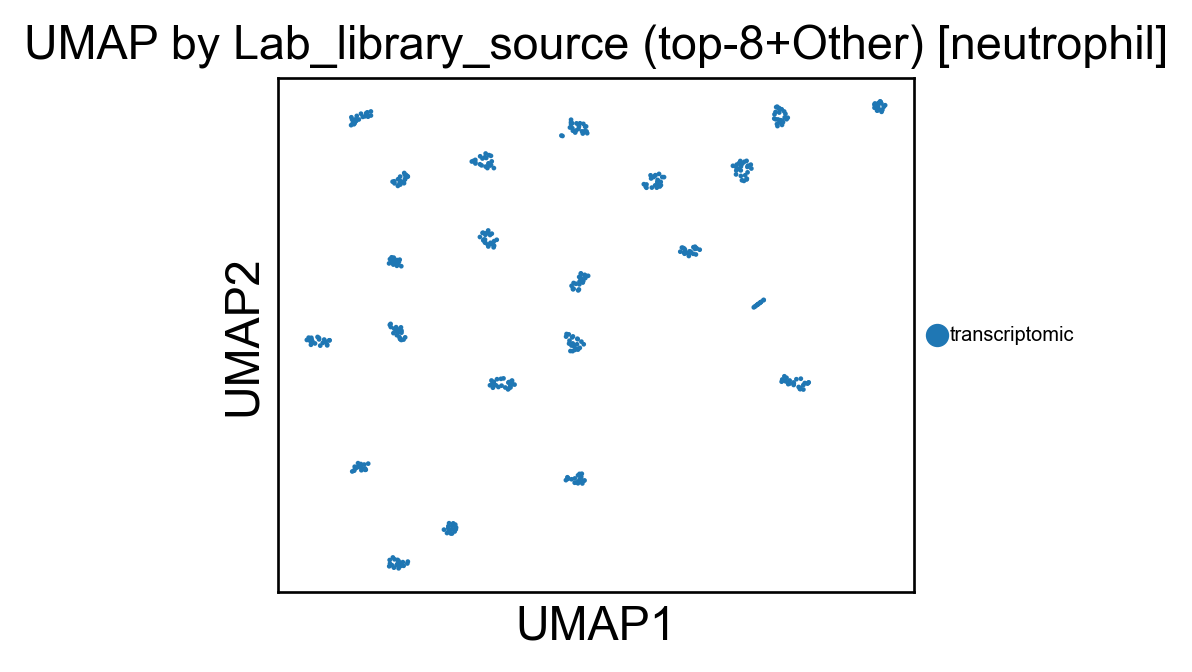

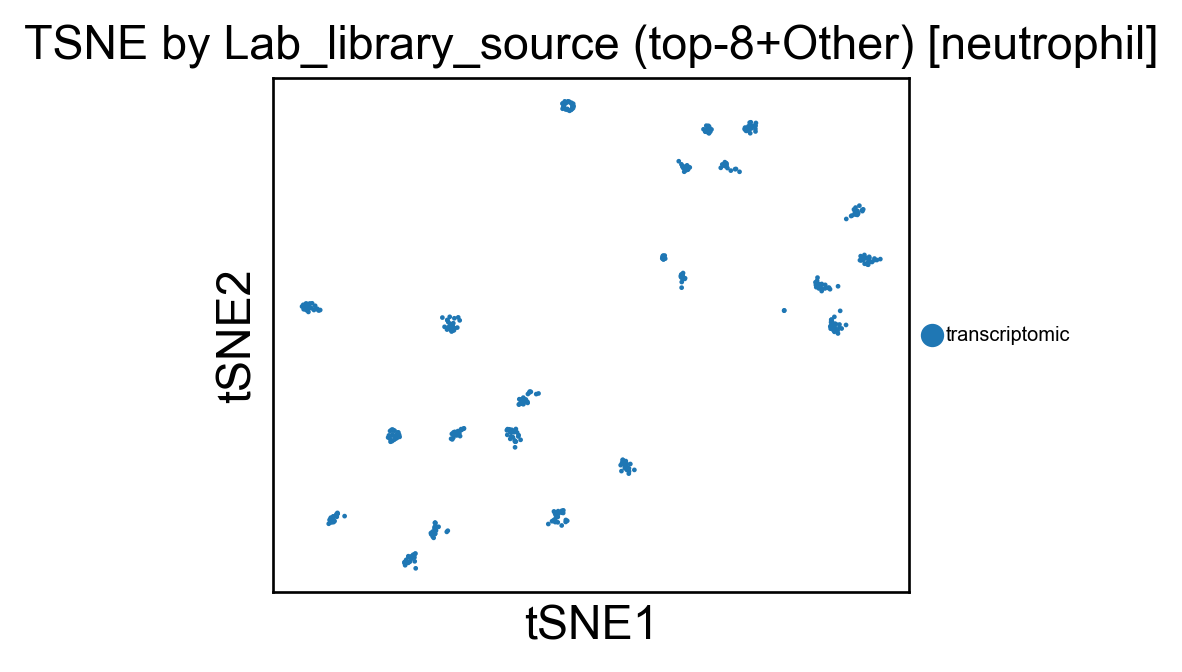

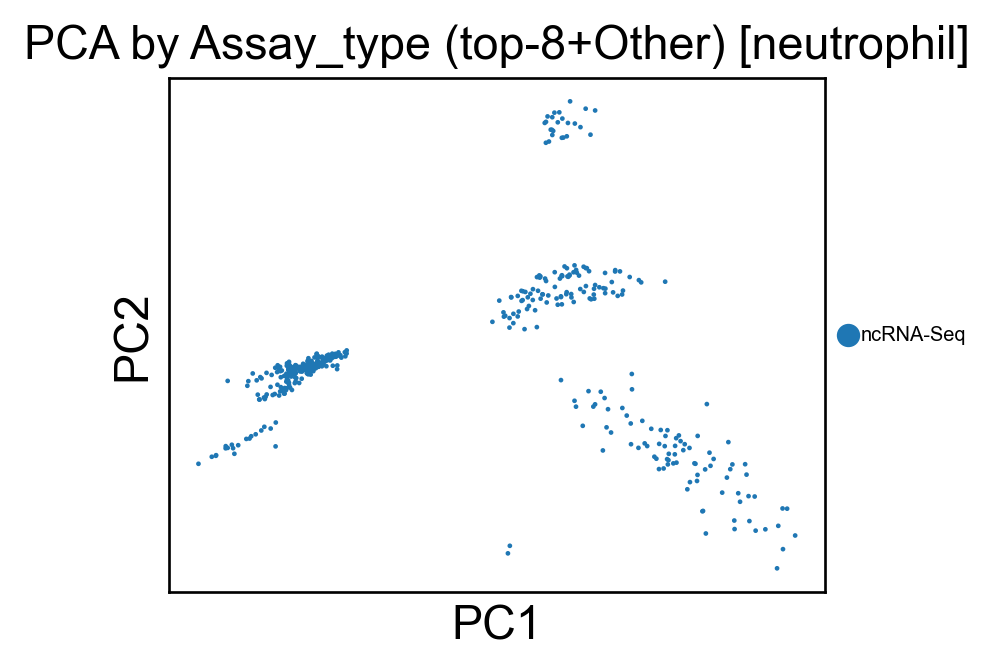

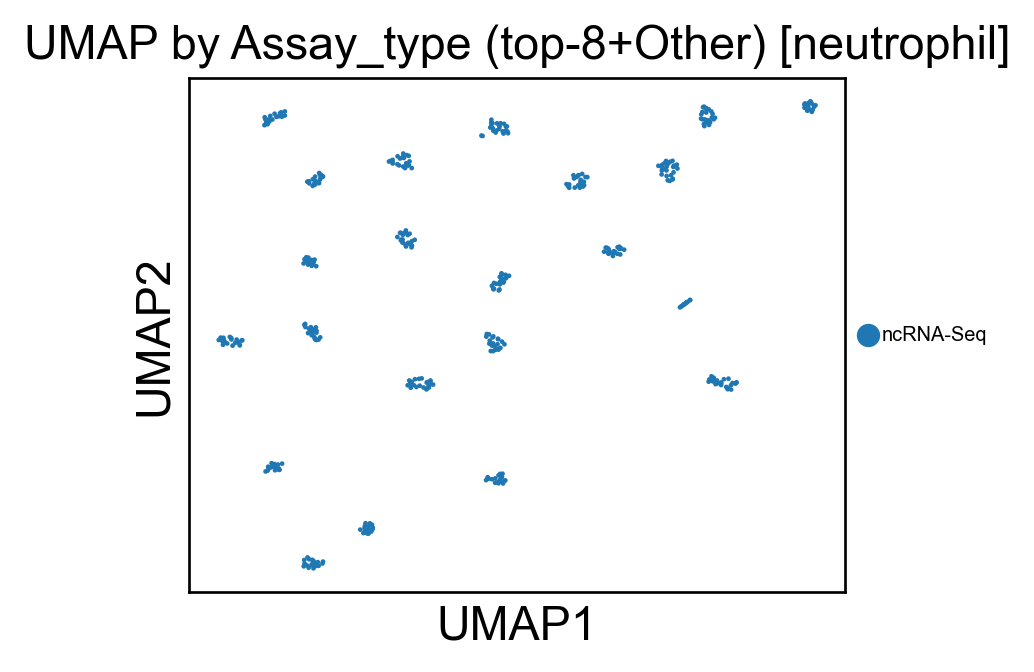

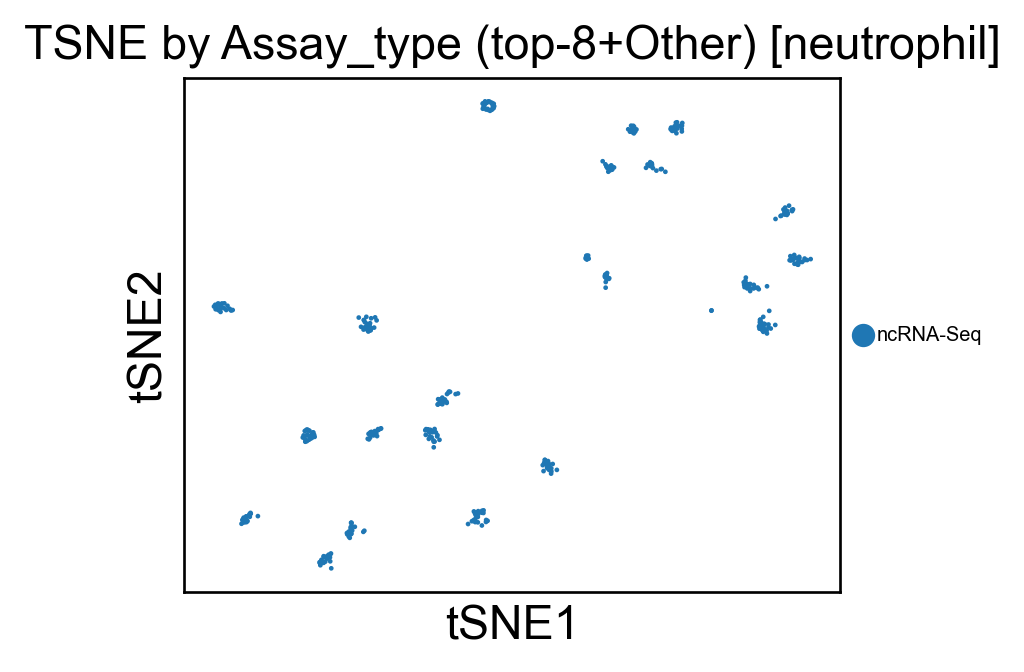

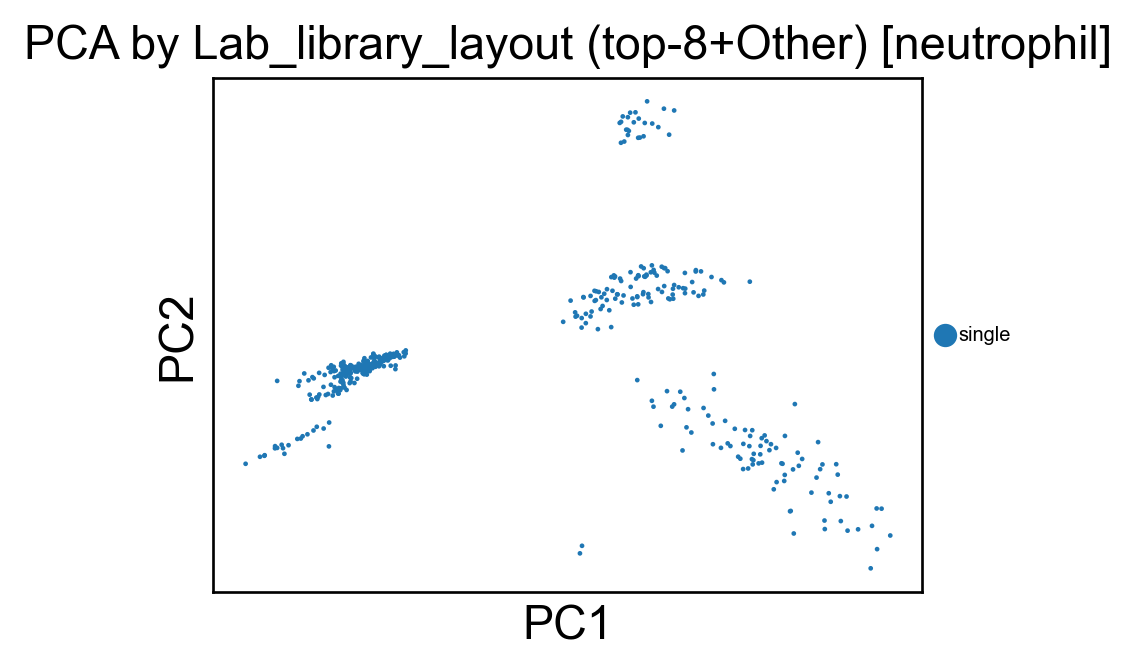

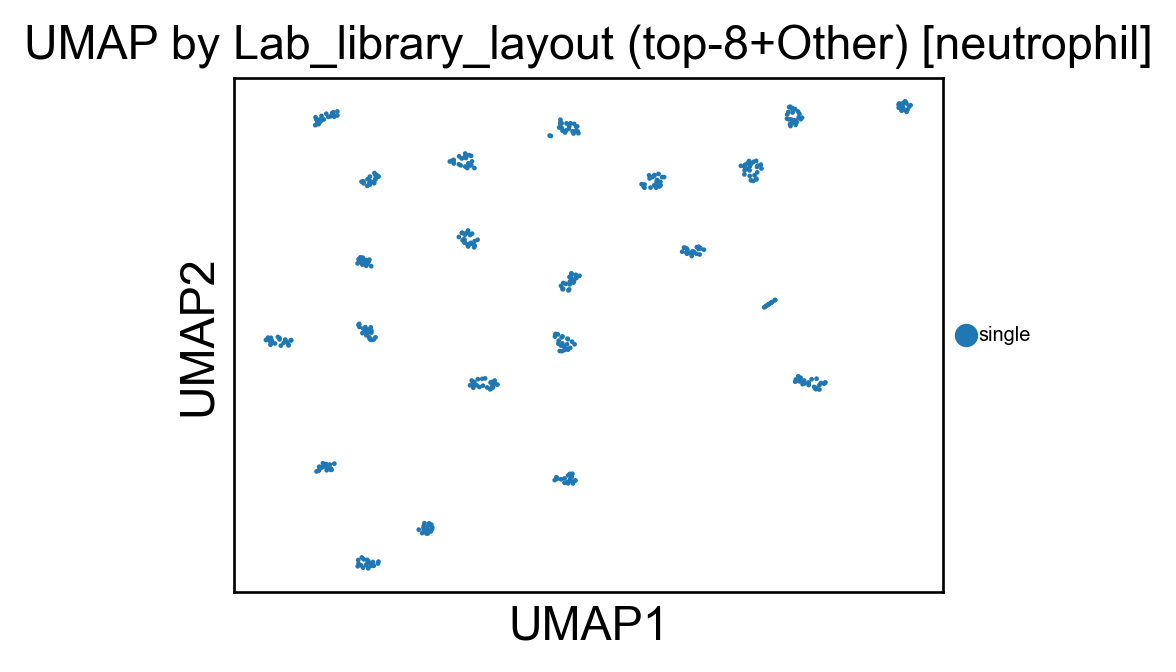

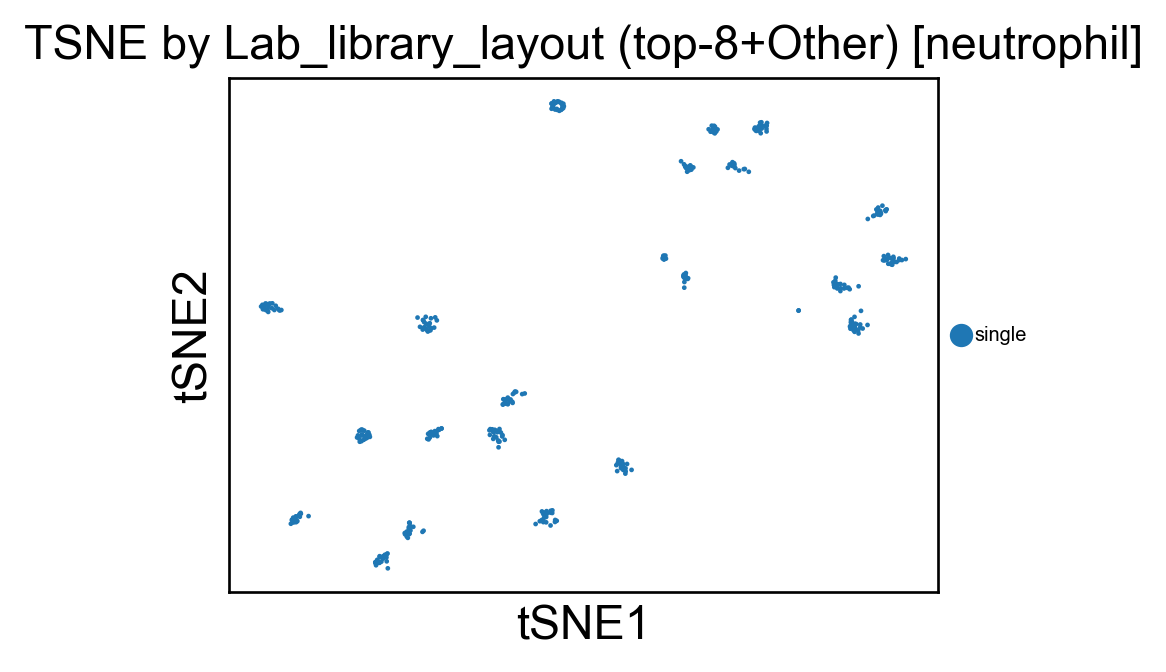

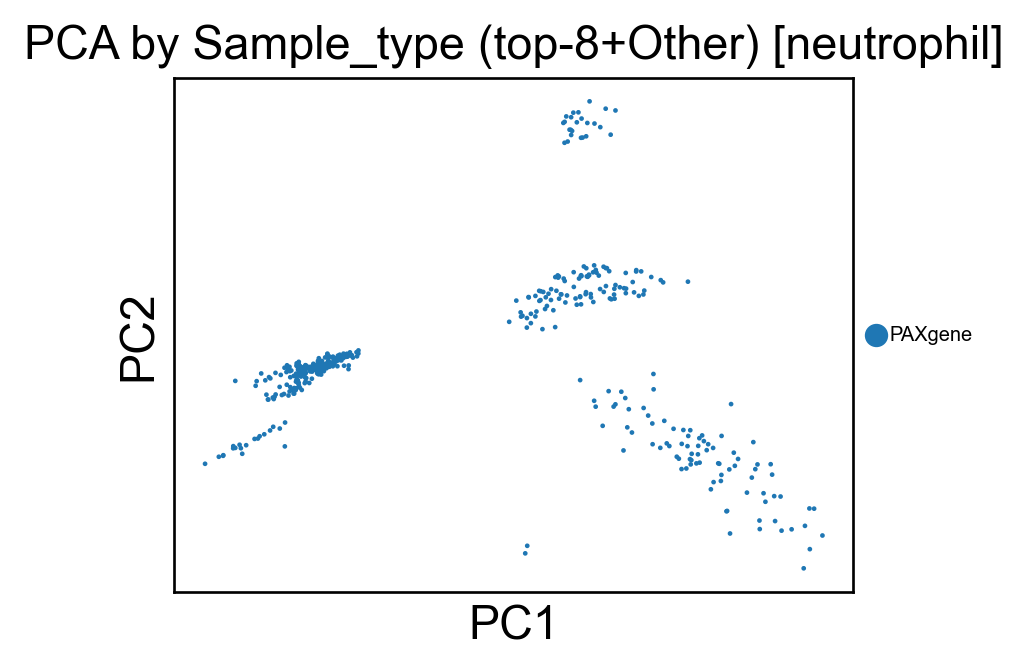

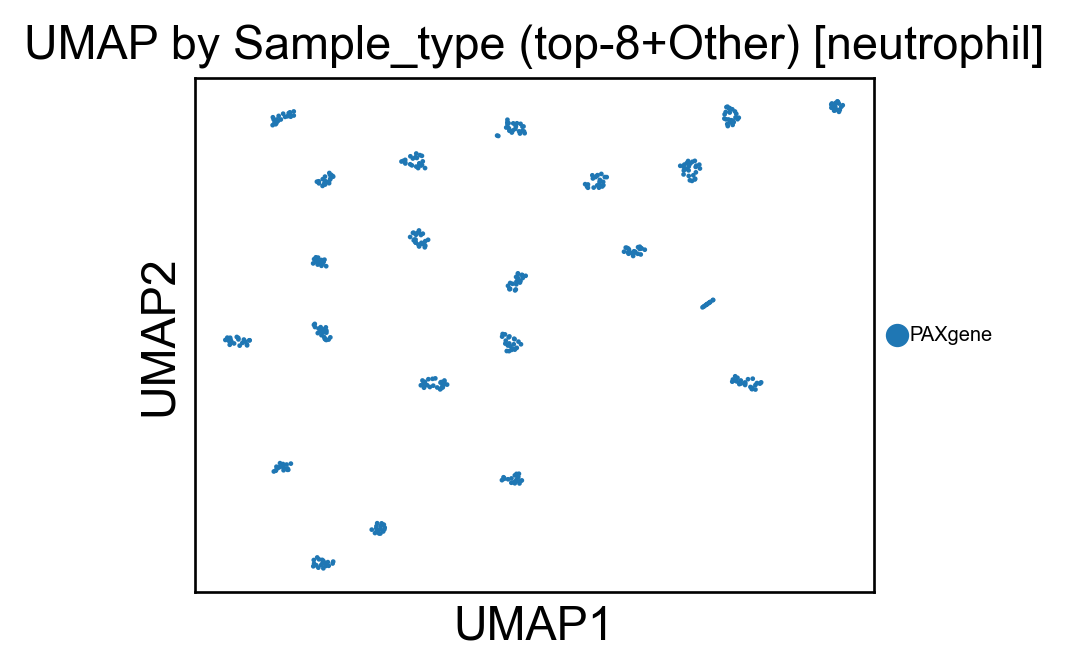

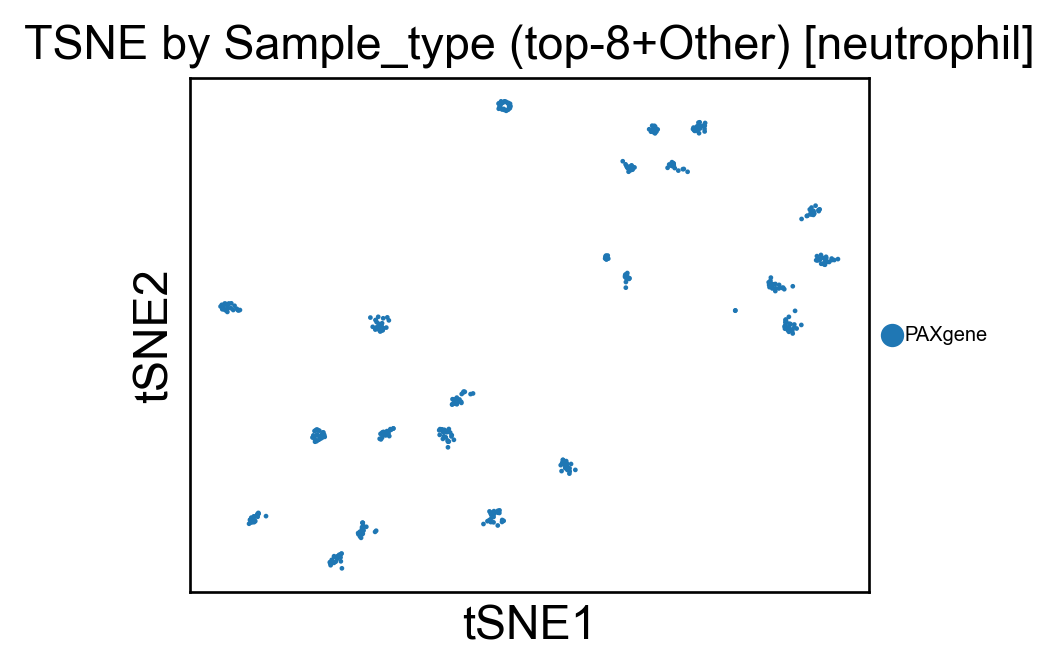

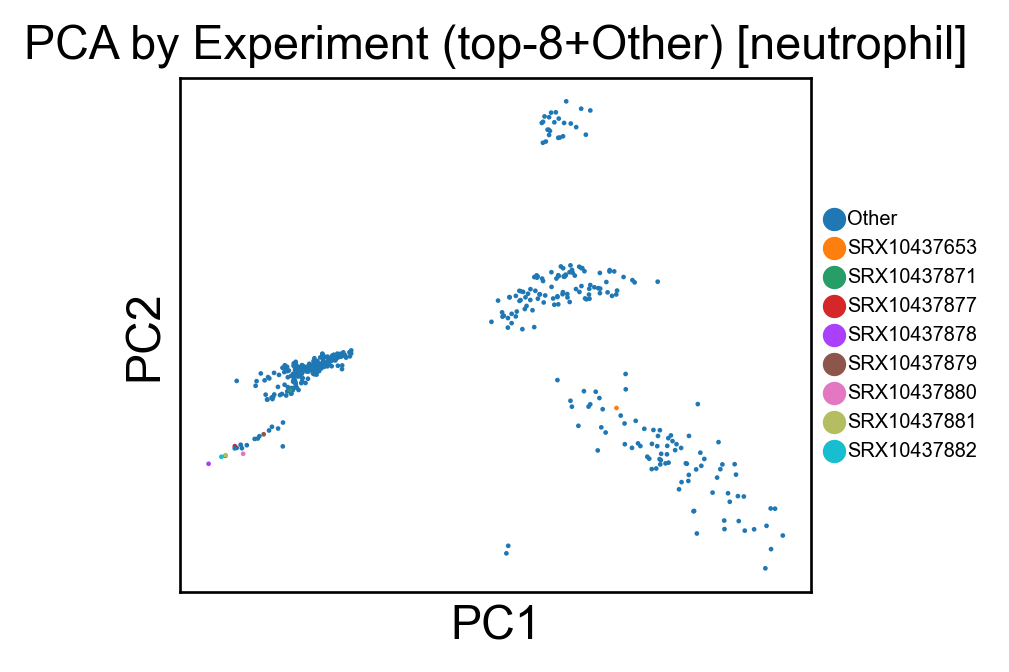

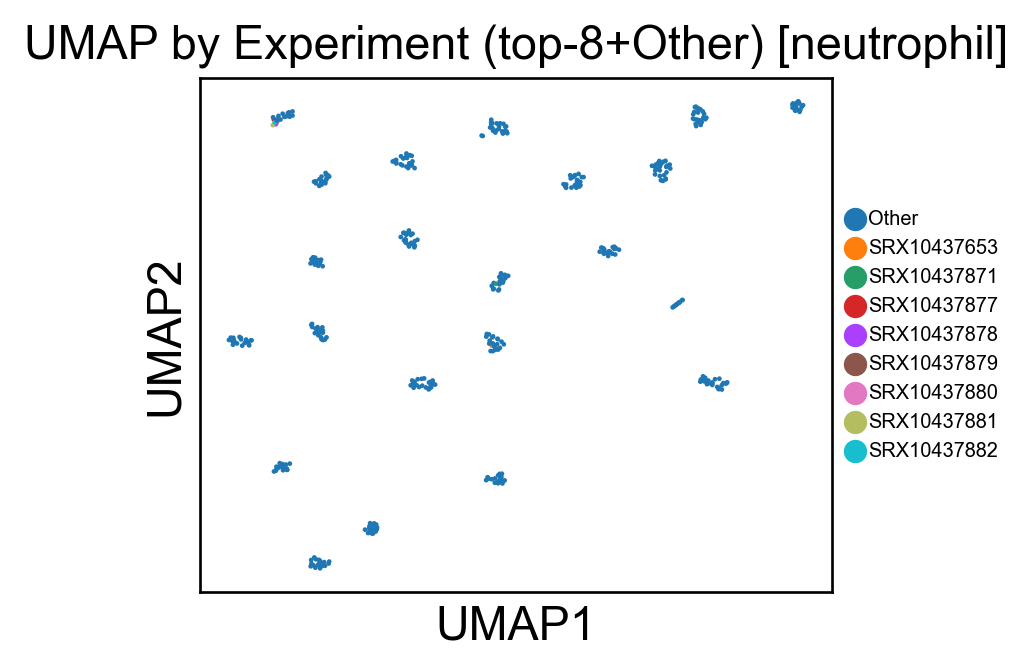

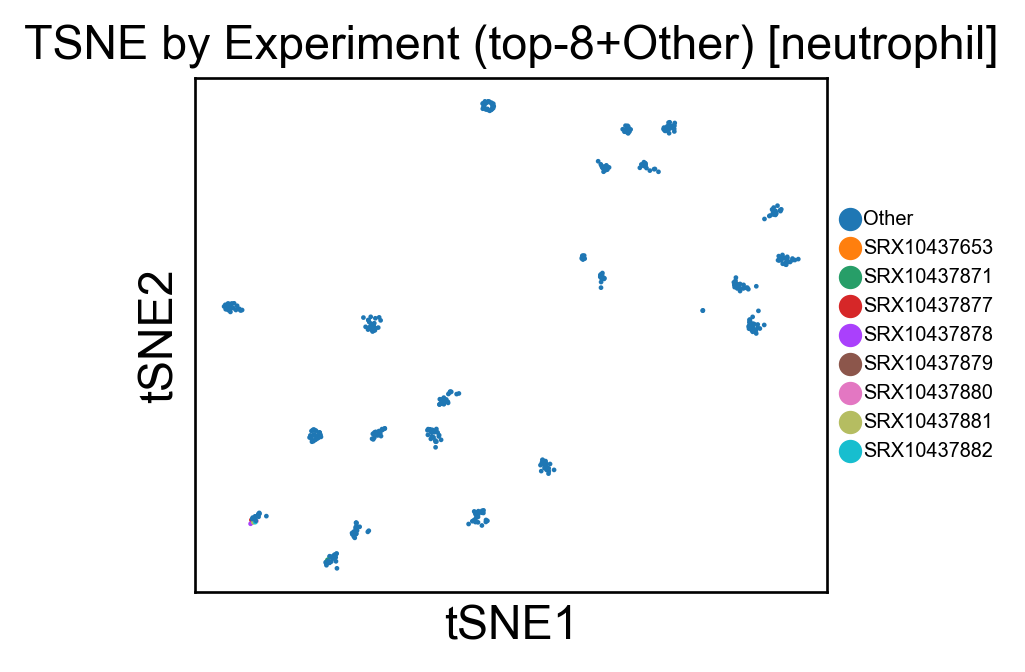

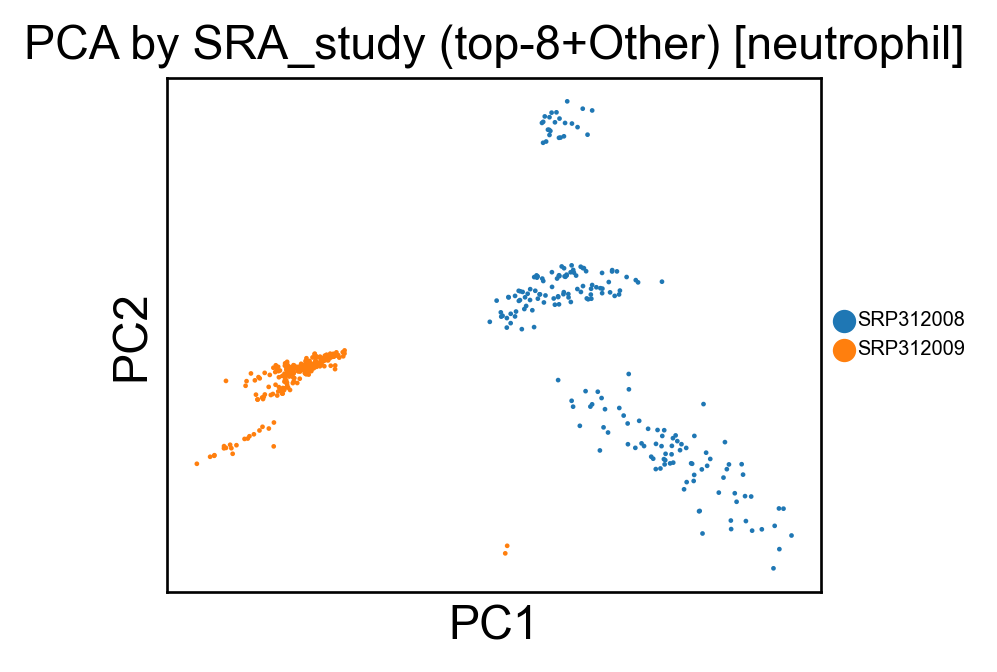

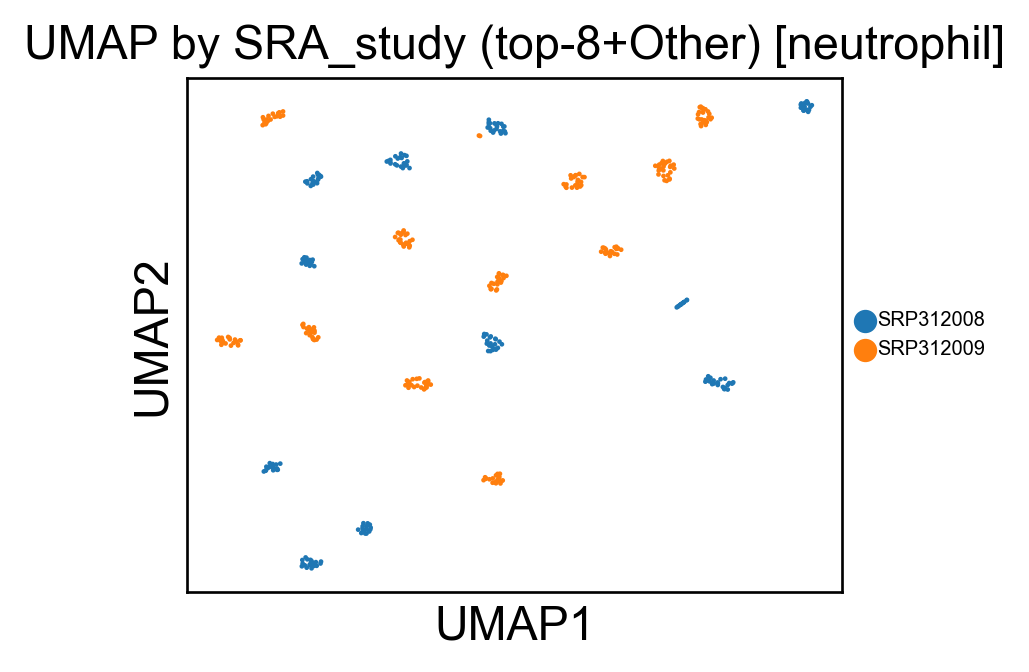

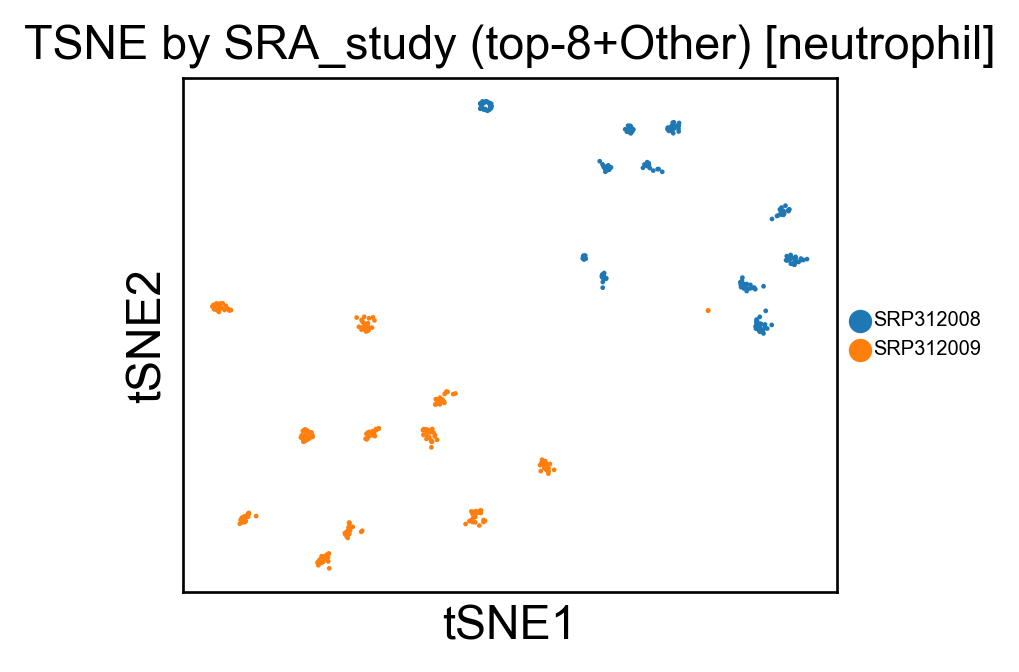

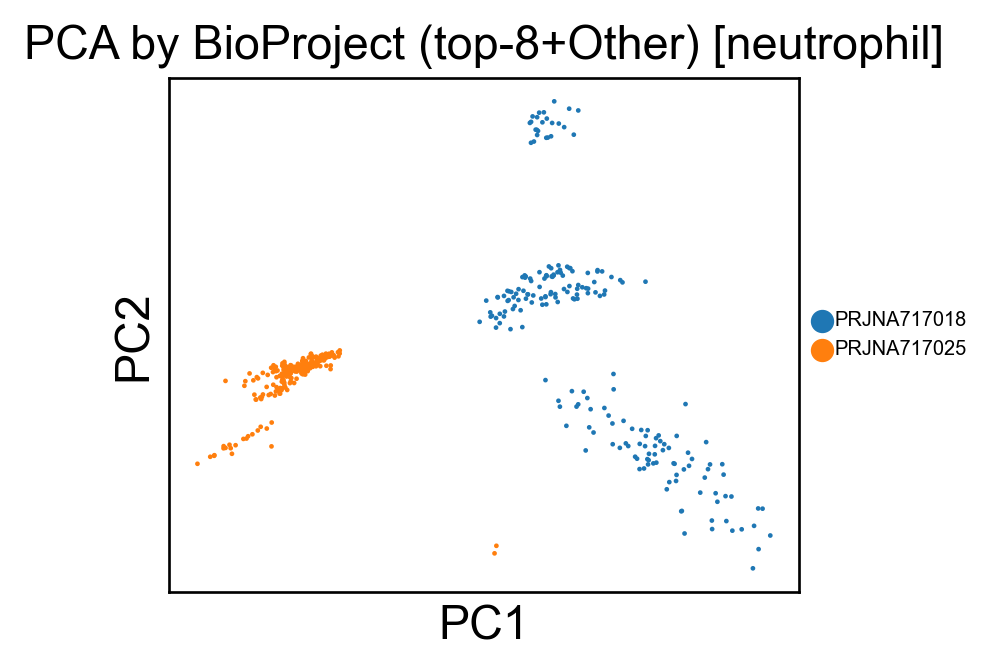

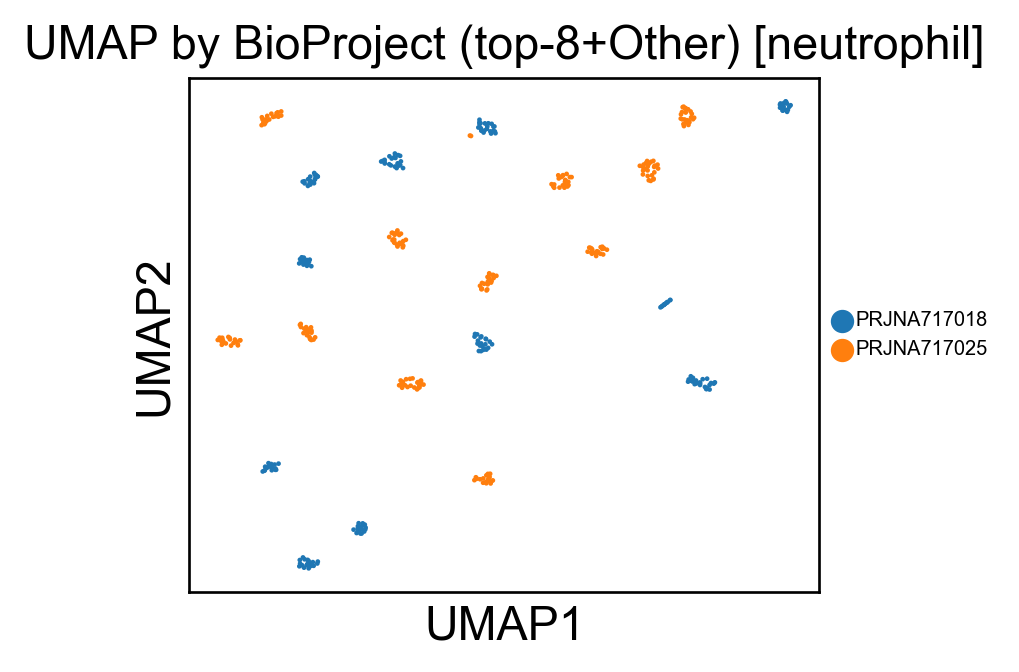

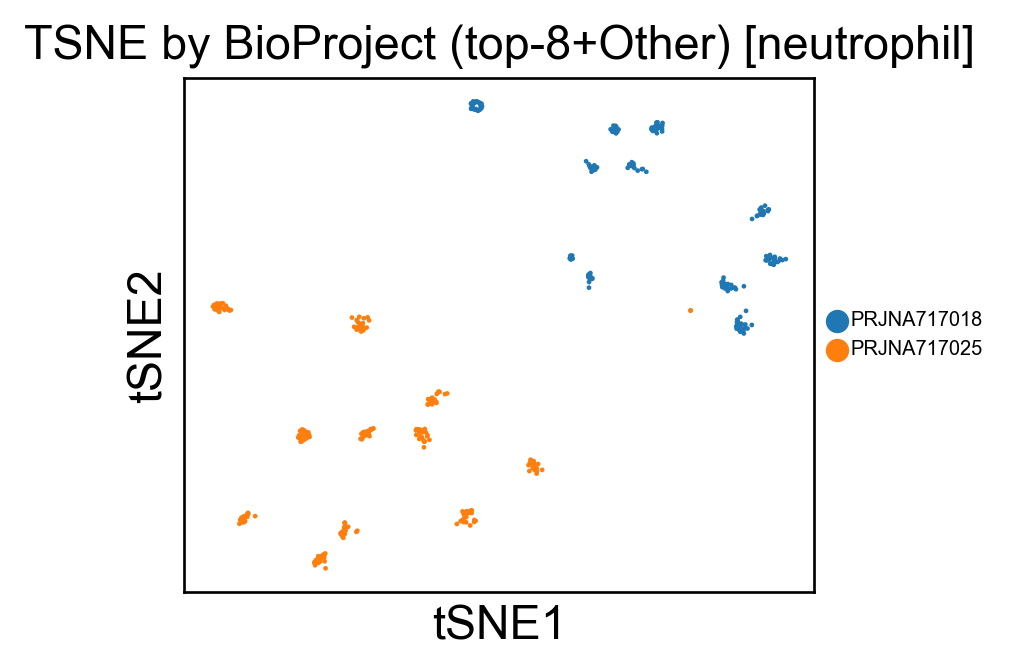

[neutrophil] volcano skipped: no cells for IBD/Healthy

=== Running report for: covid ===


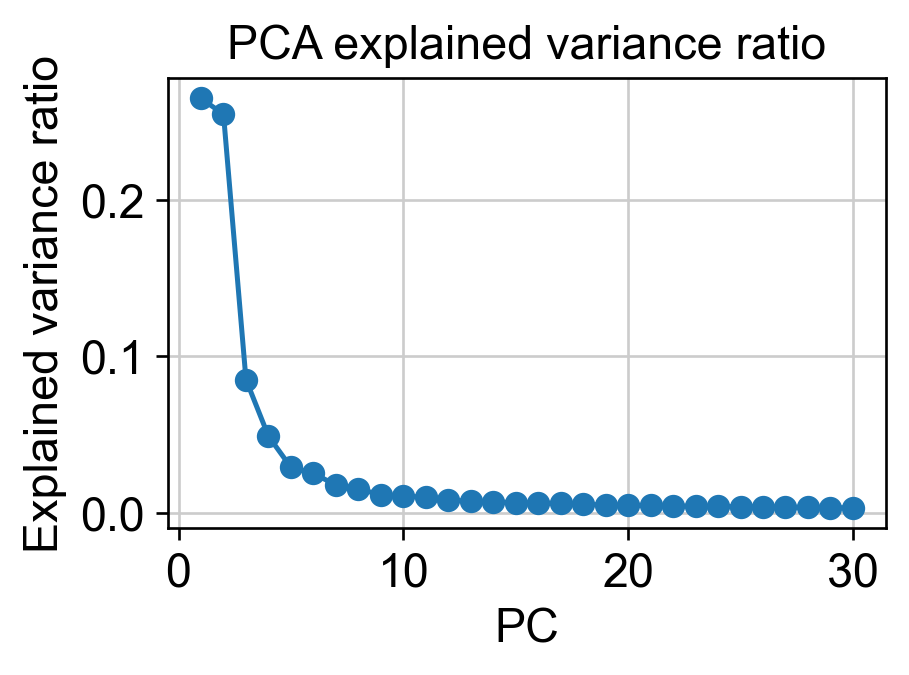

[covid] usable batch keys: ['Experiment']
[covid] audit saved → eda_outputs/report_covid/batch_key_audit.csv
[covid] metrics saved → eda_outputs/report_covid/batch_metrics_all_existing_keys.csv


/Users/mjlee/master_thesis/Thesis_project/thesispjt/thesis-impute/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:106: RuntimeWarning: divide by zero encountered in divide
  msb = ssbn / float(dfbn)
/Users/mjlee/master_thesis/Thesis_project/thesispjt/thesis-impute/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:106: RuntimeWarning: invalid value encountered in divide
  msb = ssbn / float(dfbn)
/Users/mjlee/master_thesis/Thesis_project/thesispjt/thesis-impute/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/Users/mjlee/master_thesis/Thesis_project/thesispjt/thesis-impute/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and w

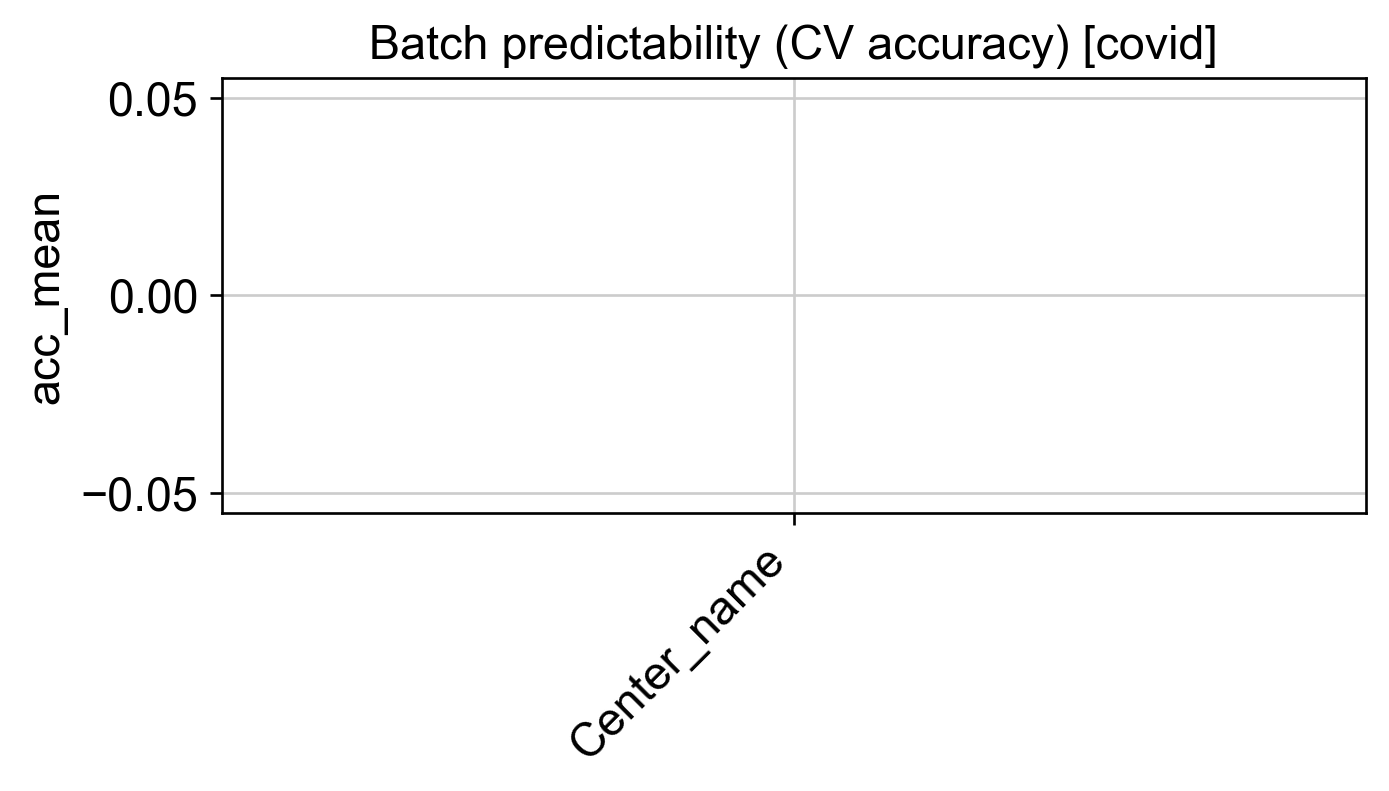

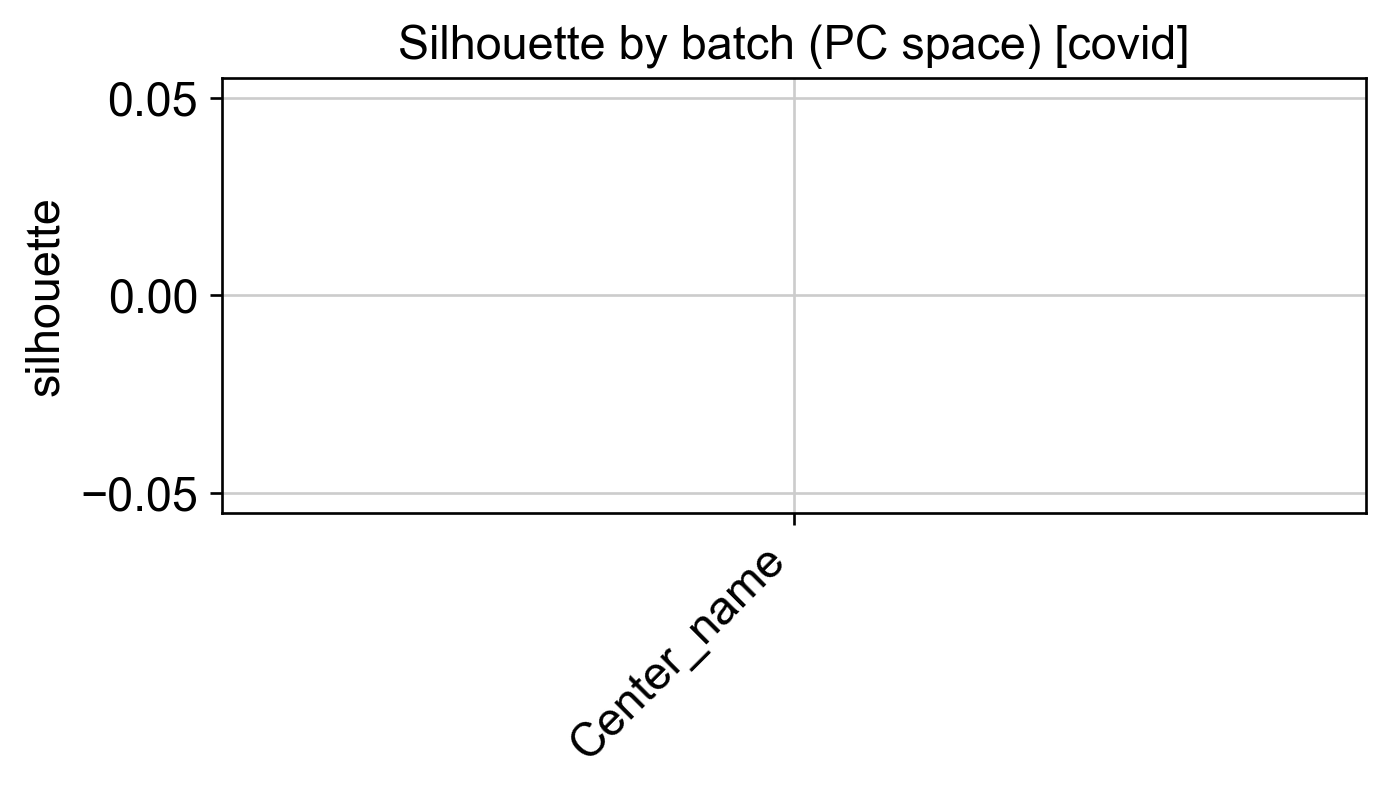

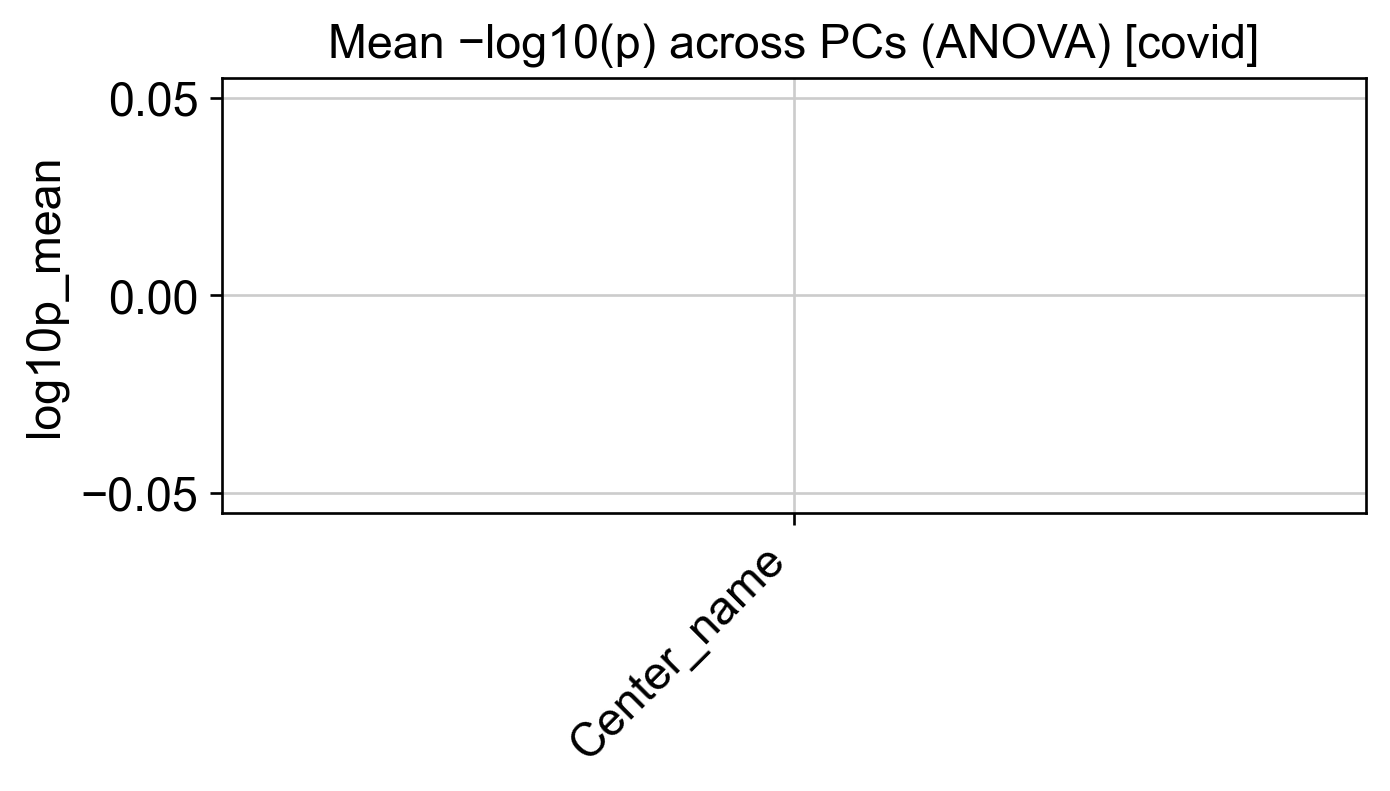

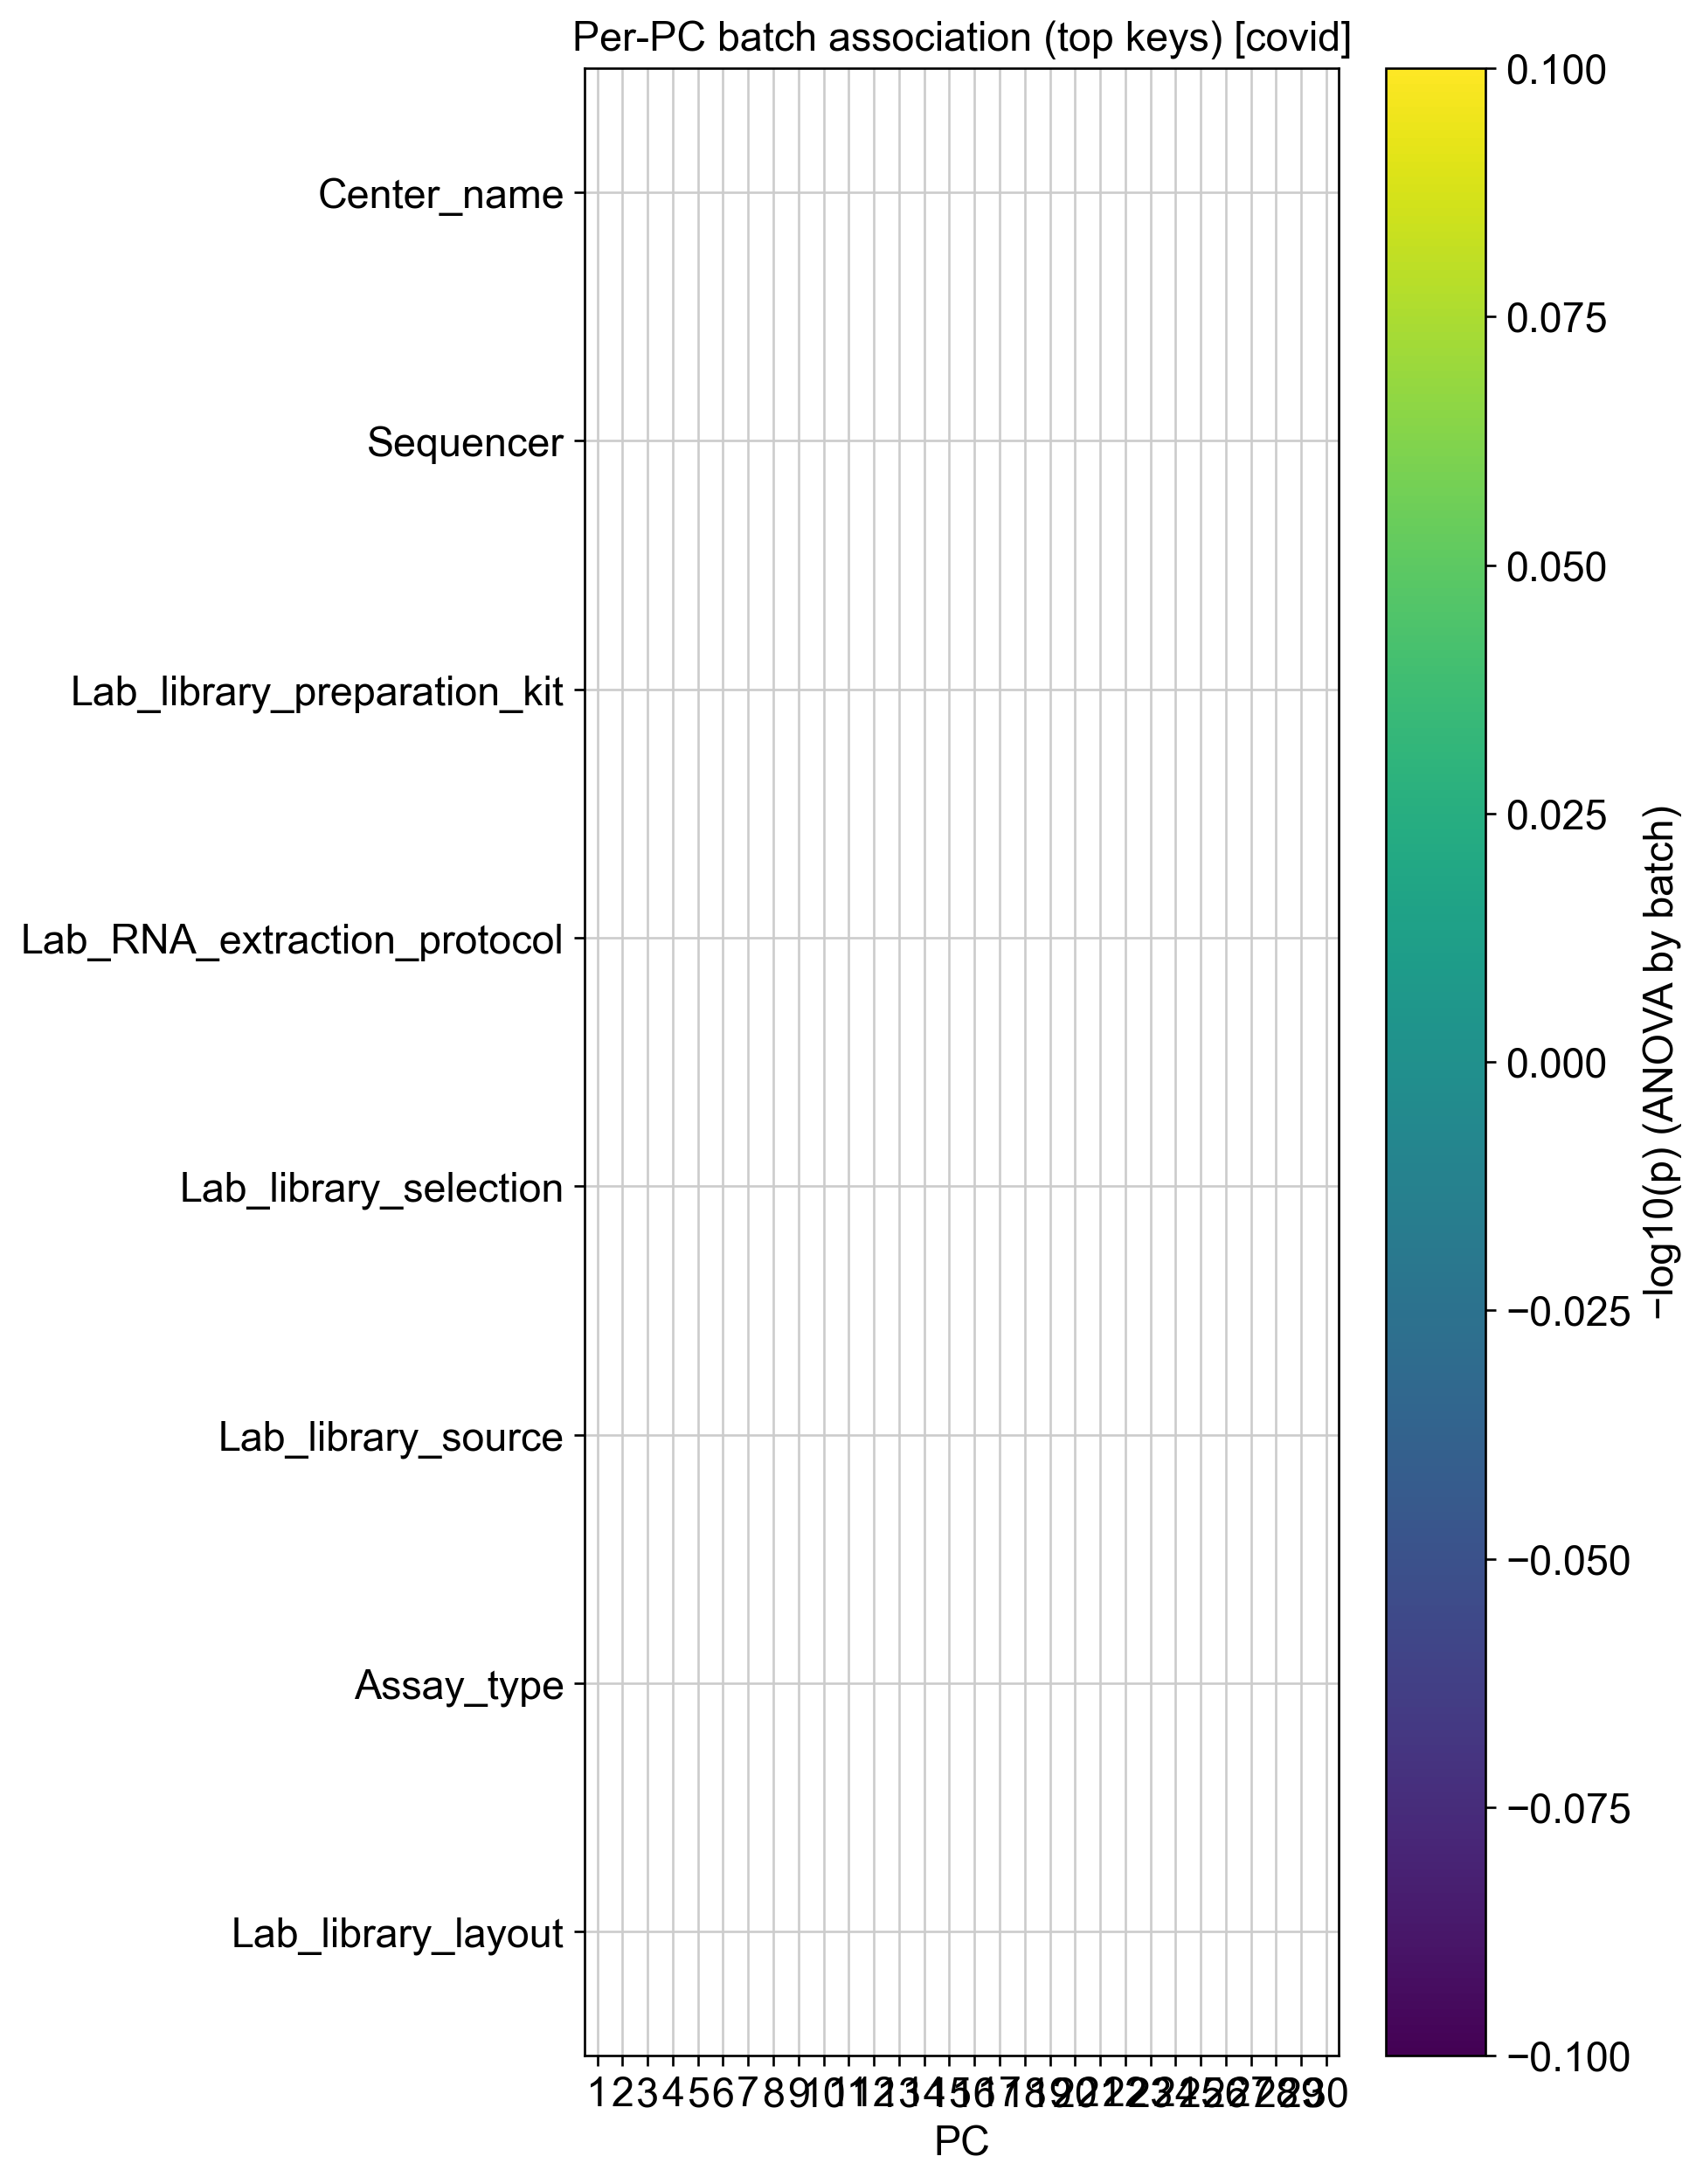

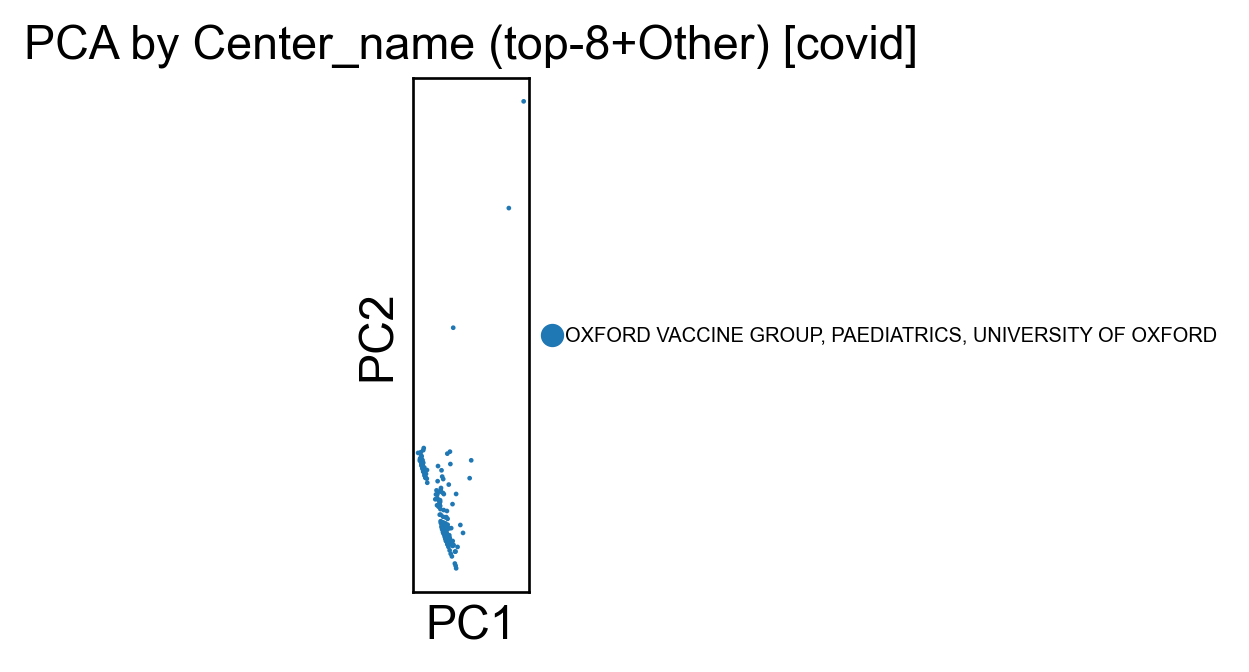

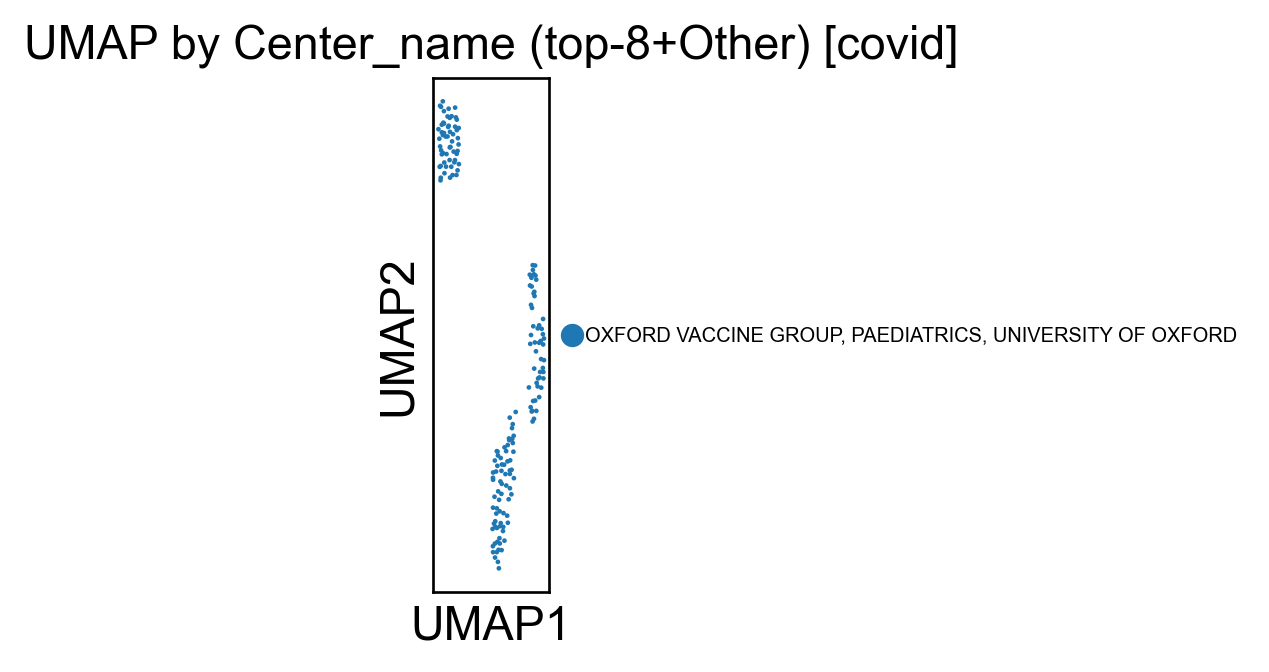

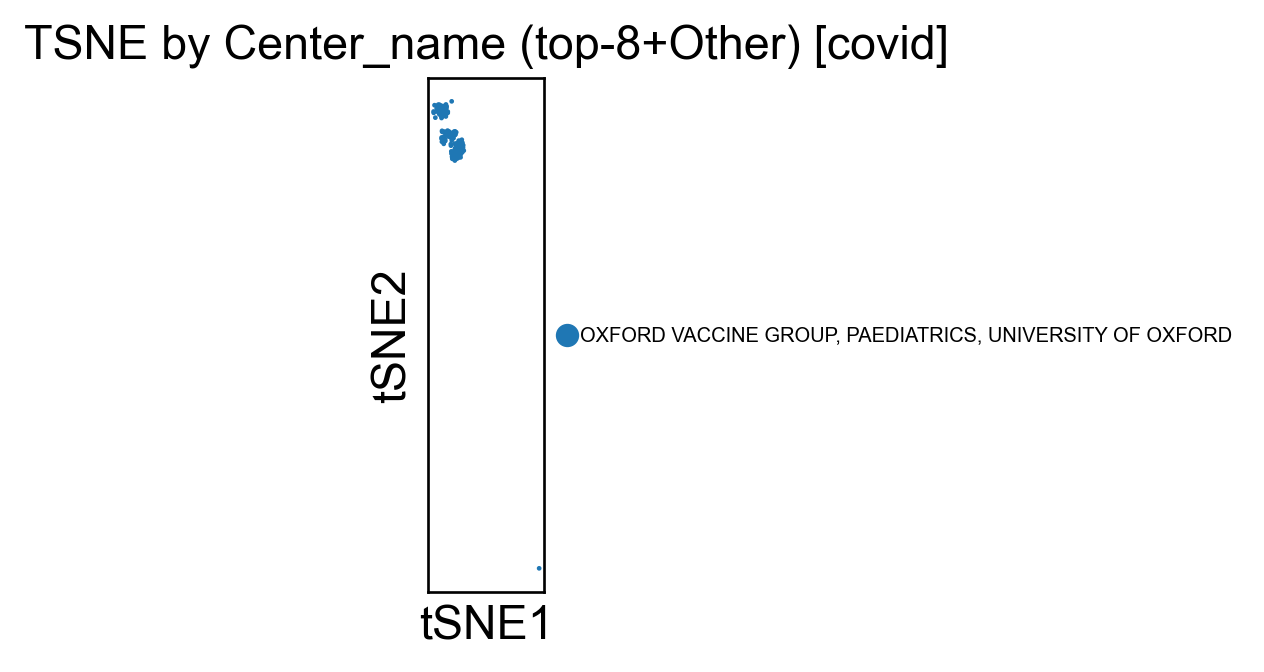

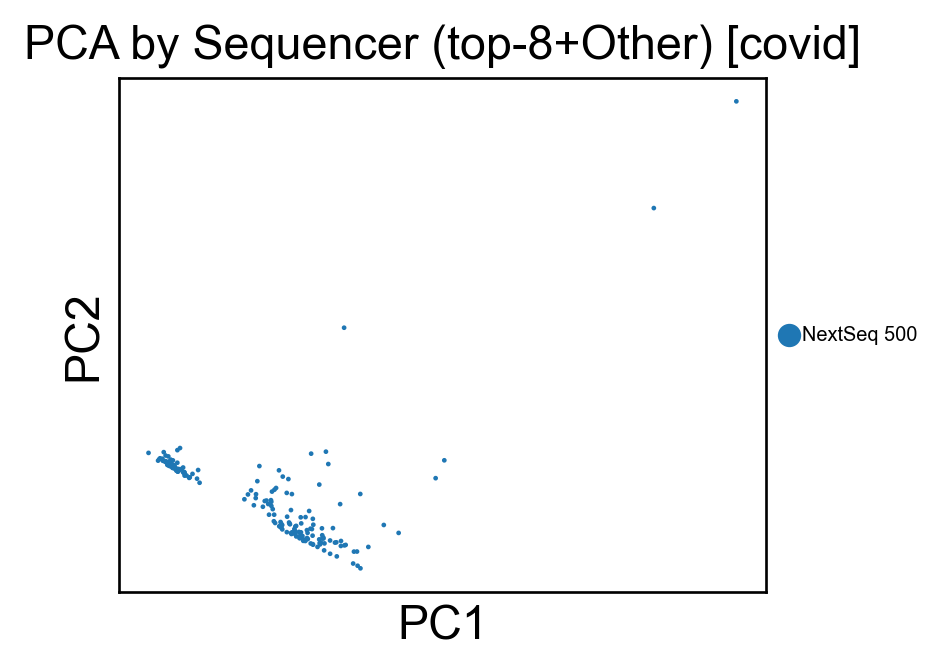

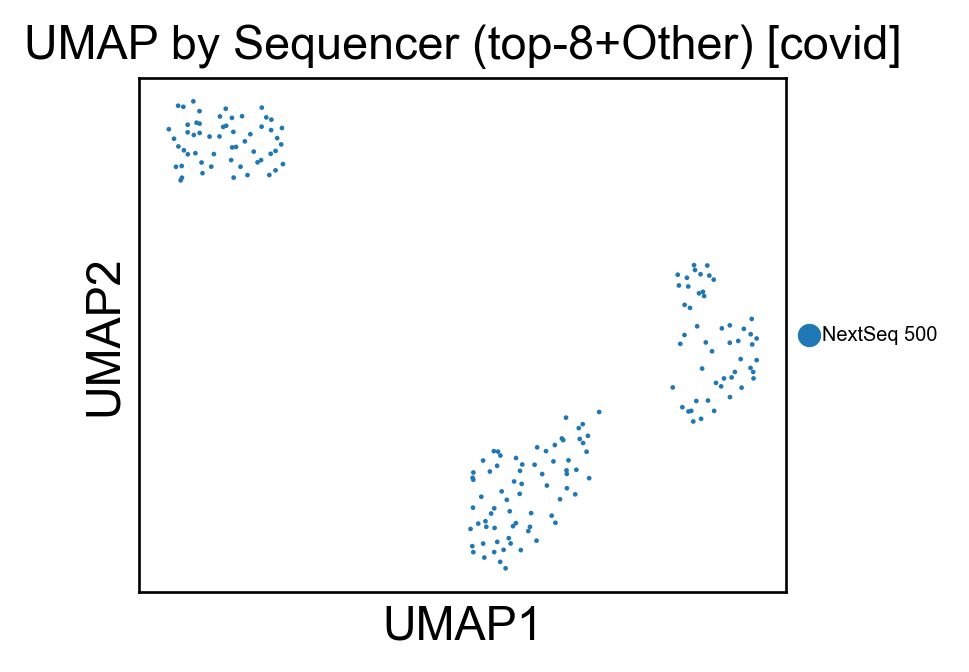

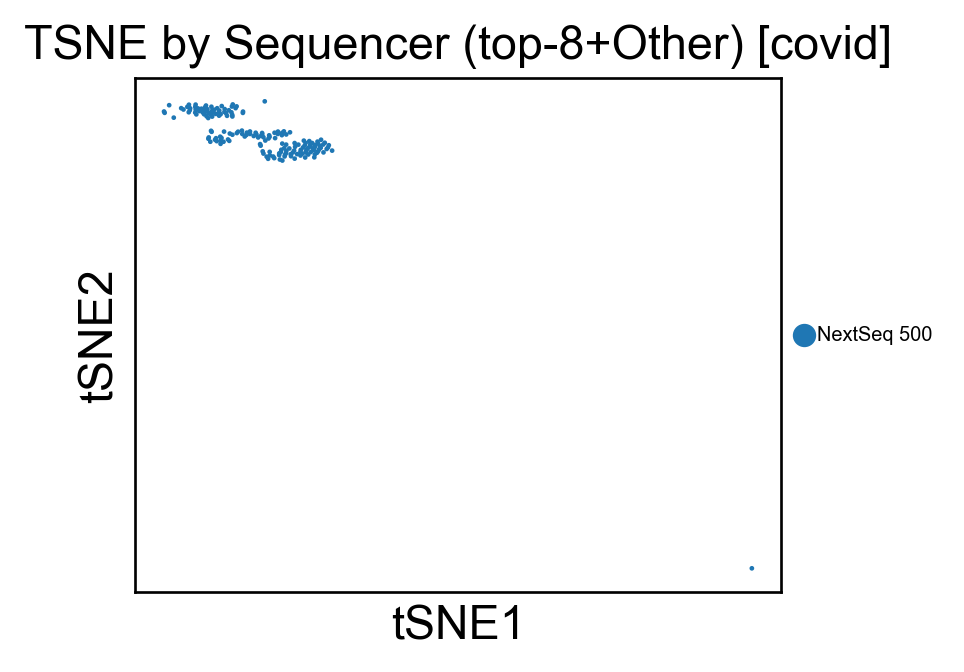

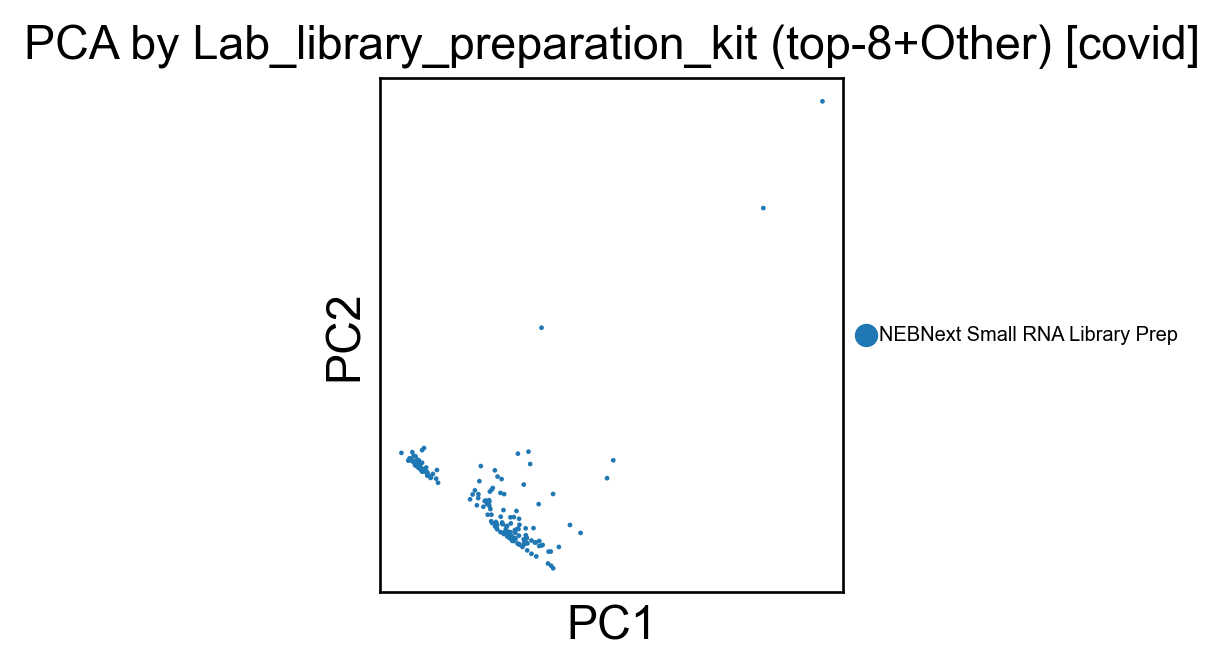

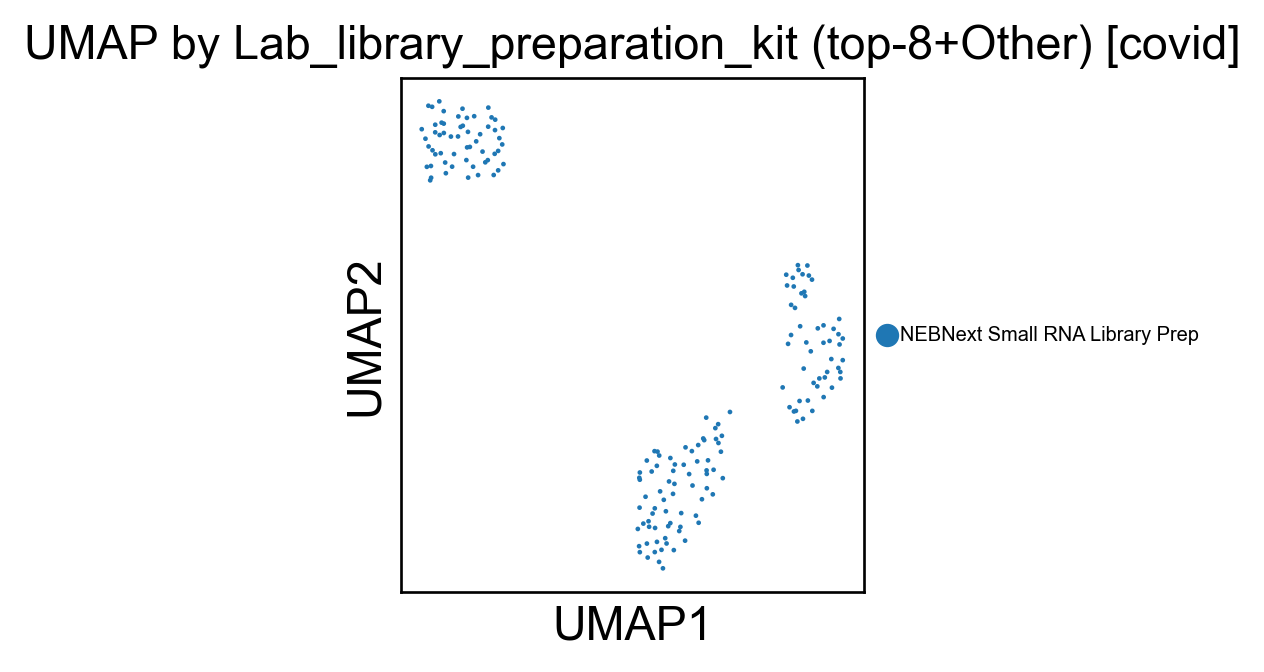

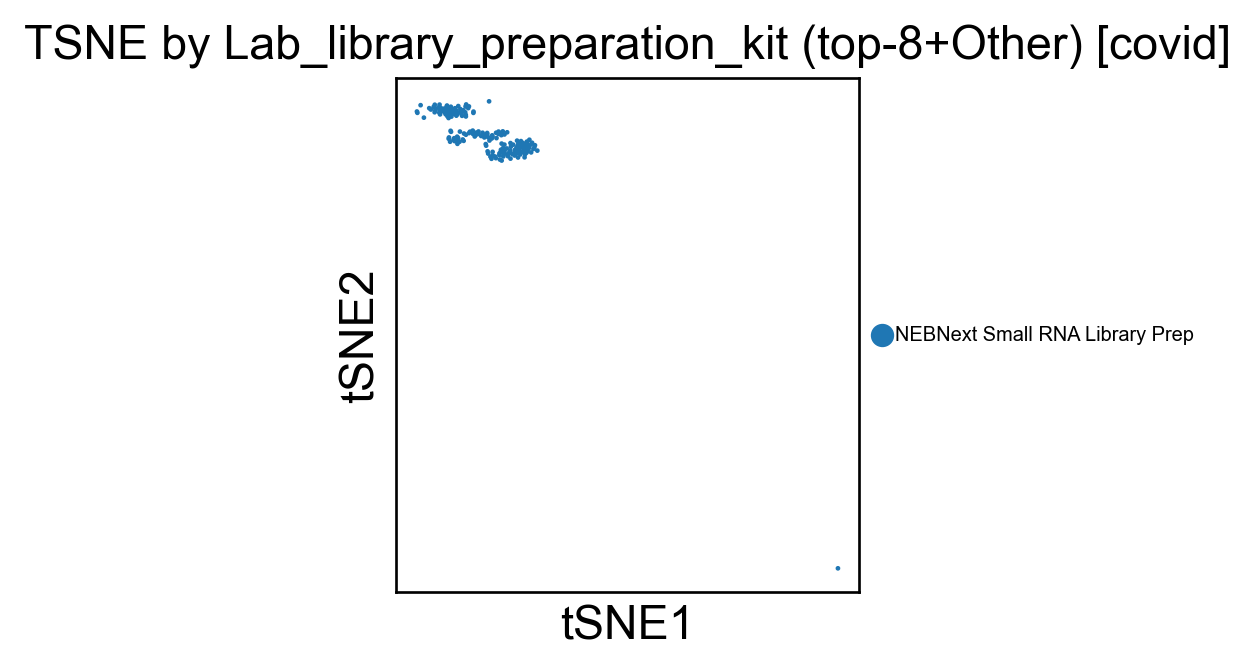

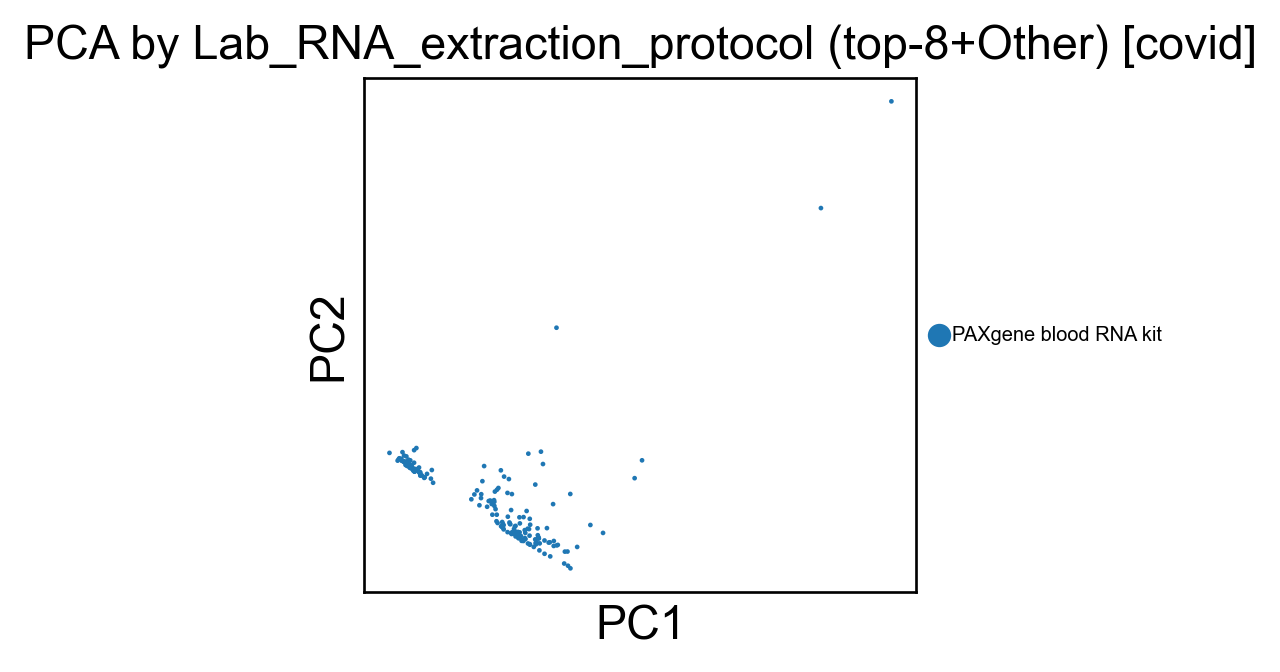

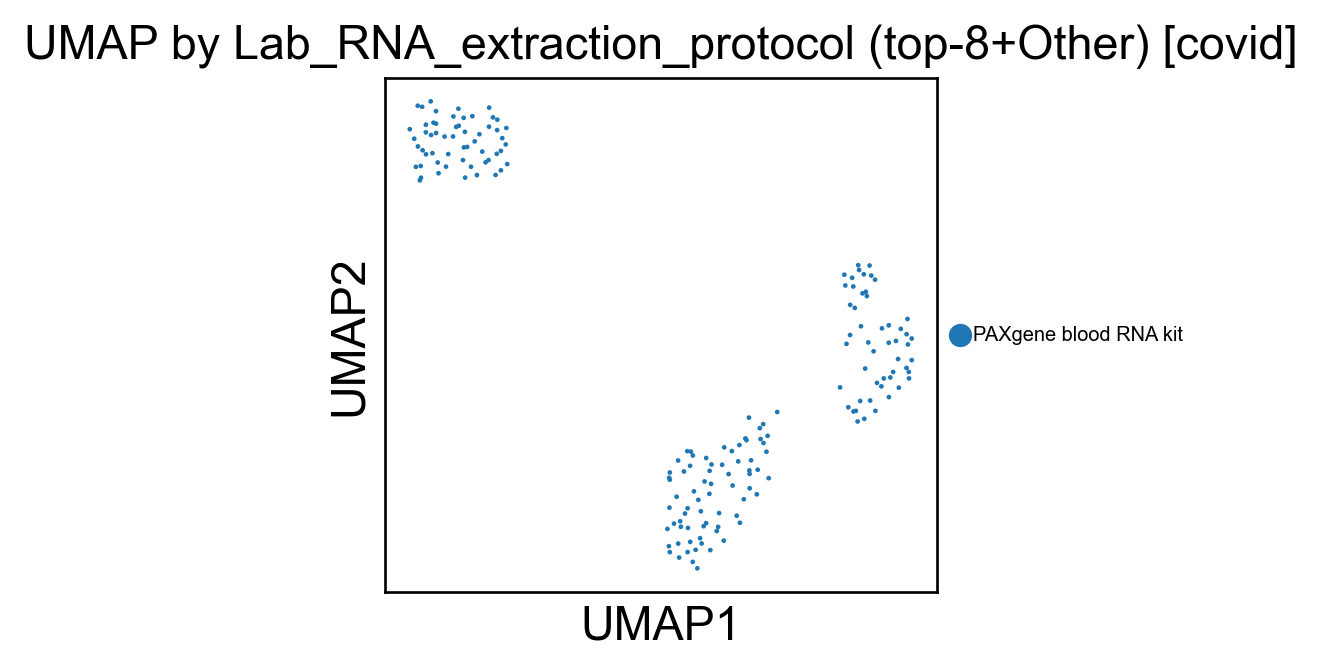

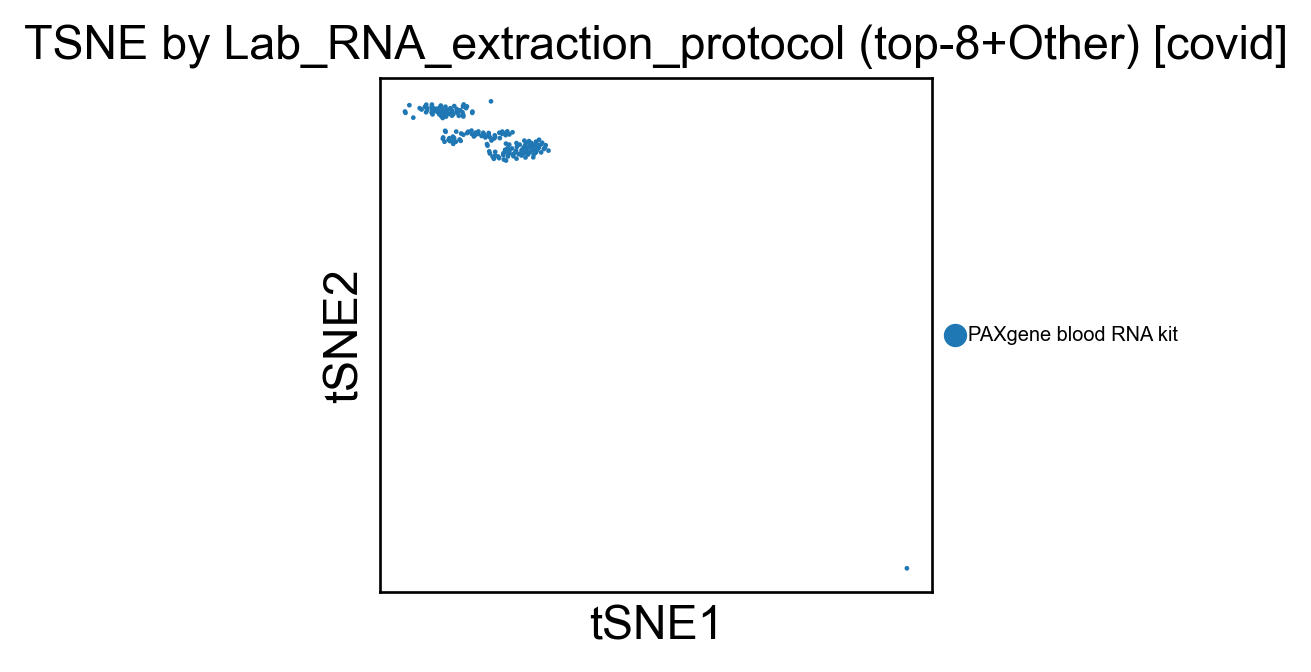

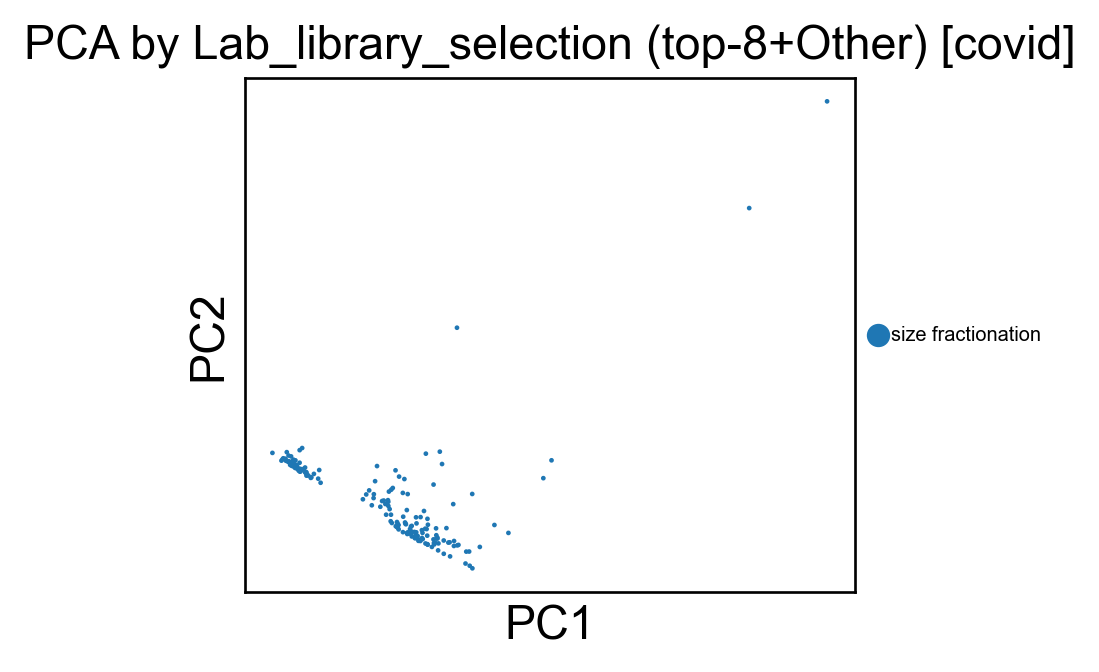

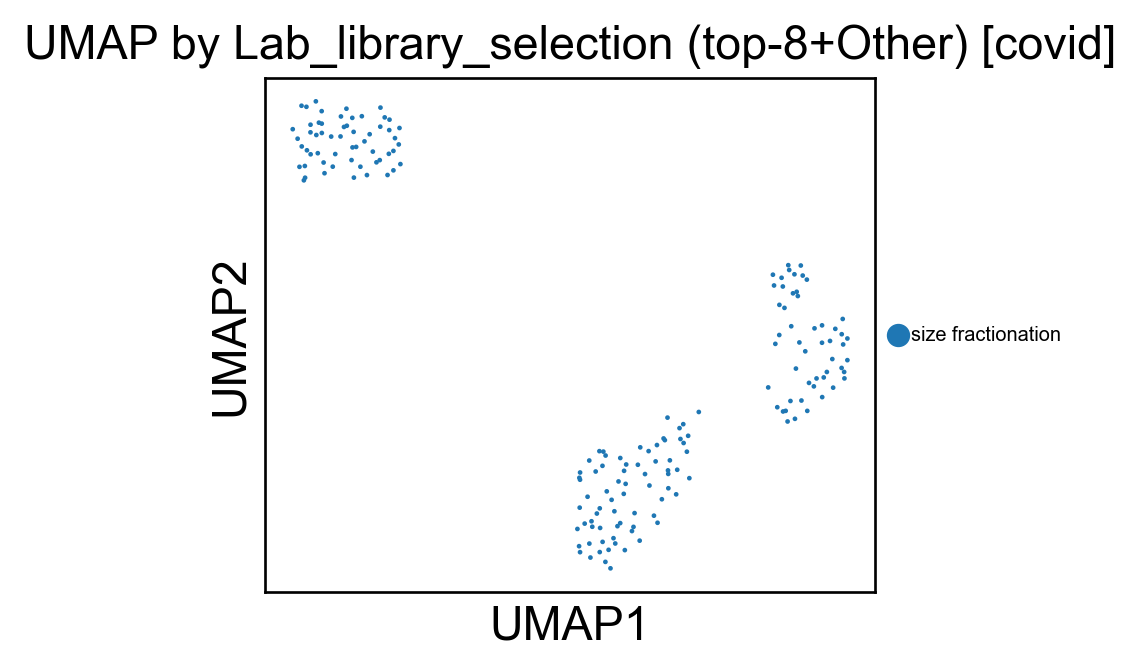

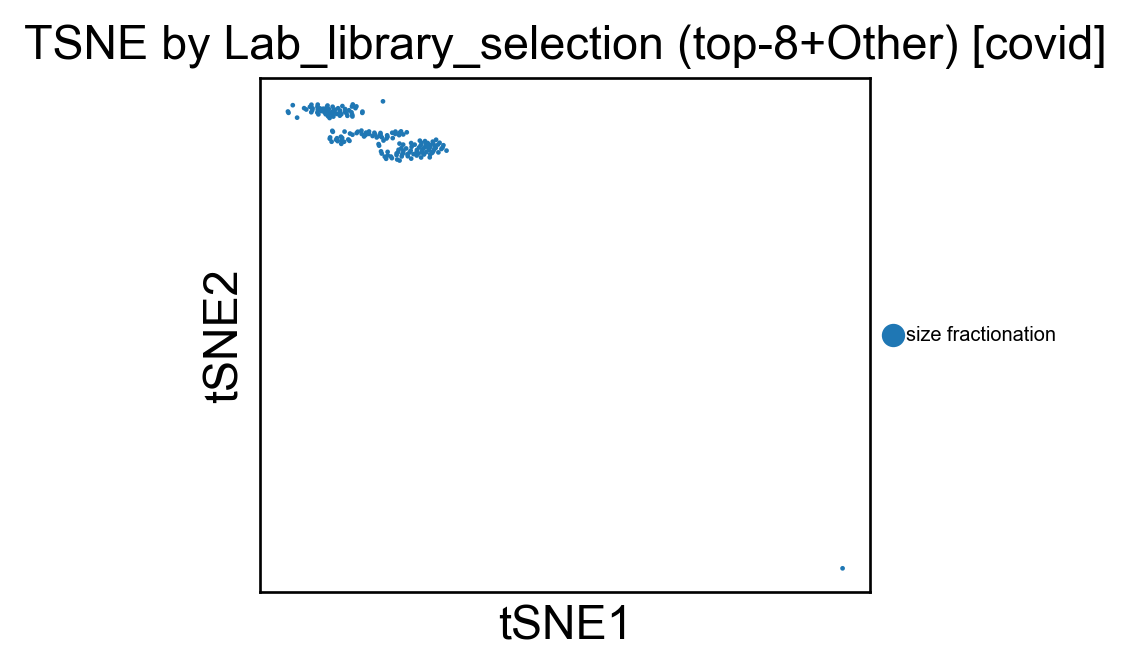

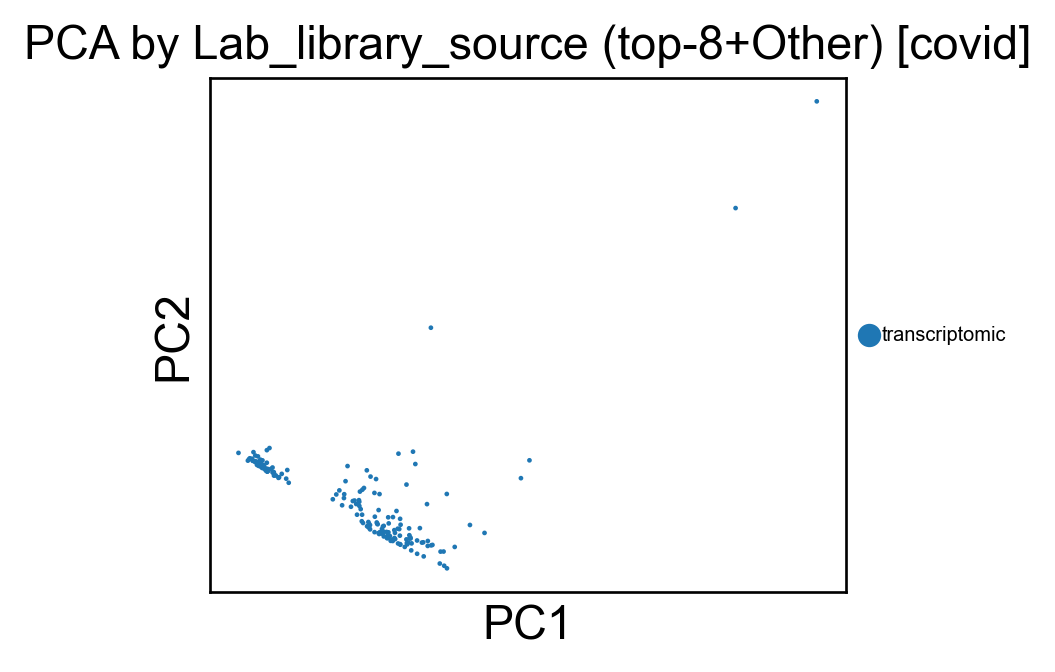

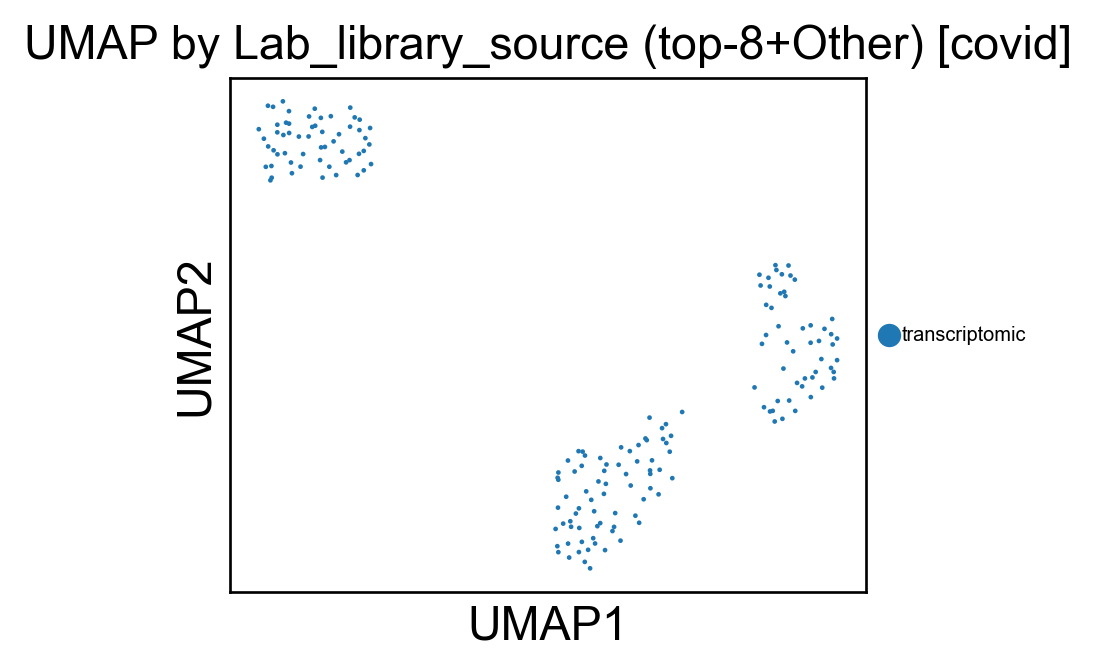

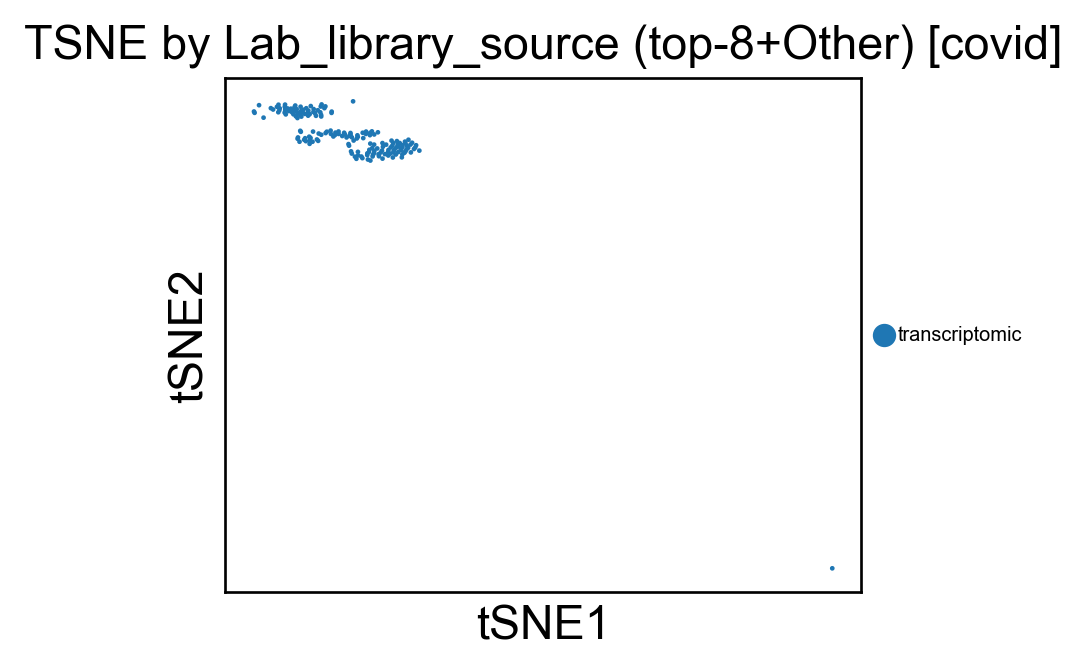

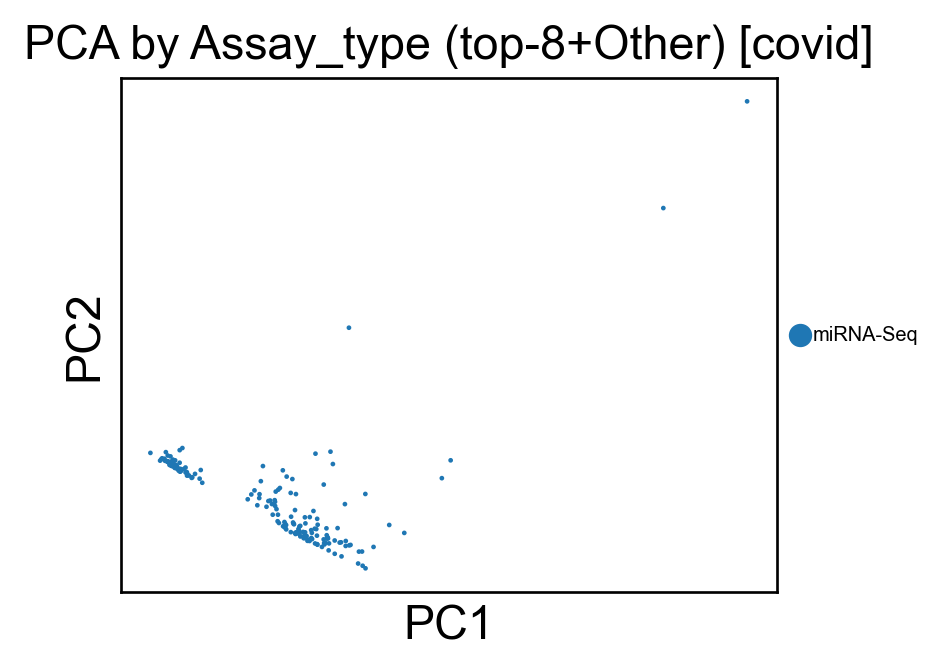

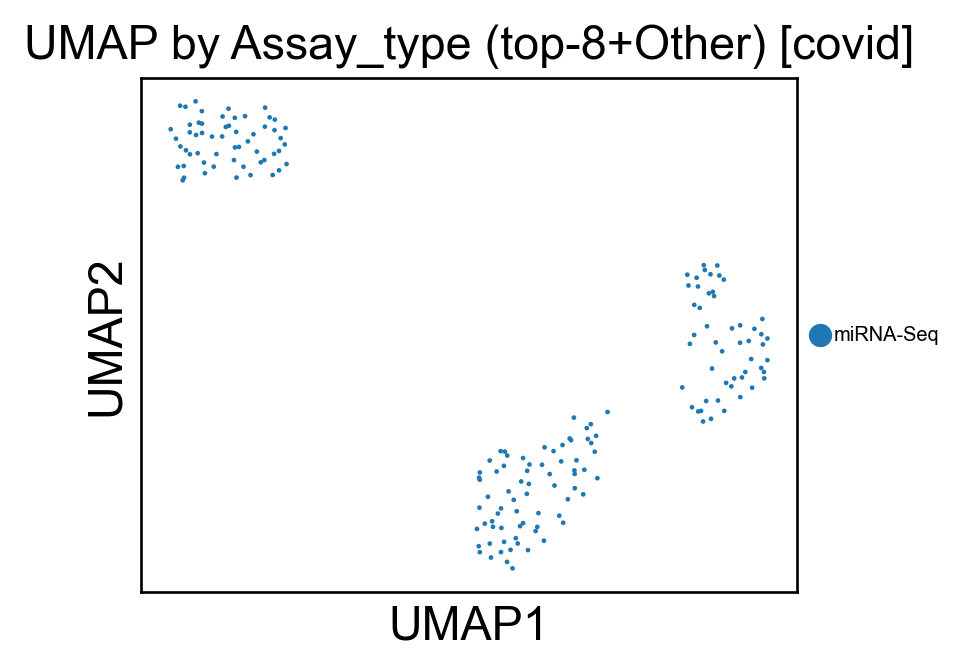

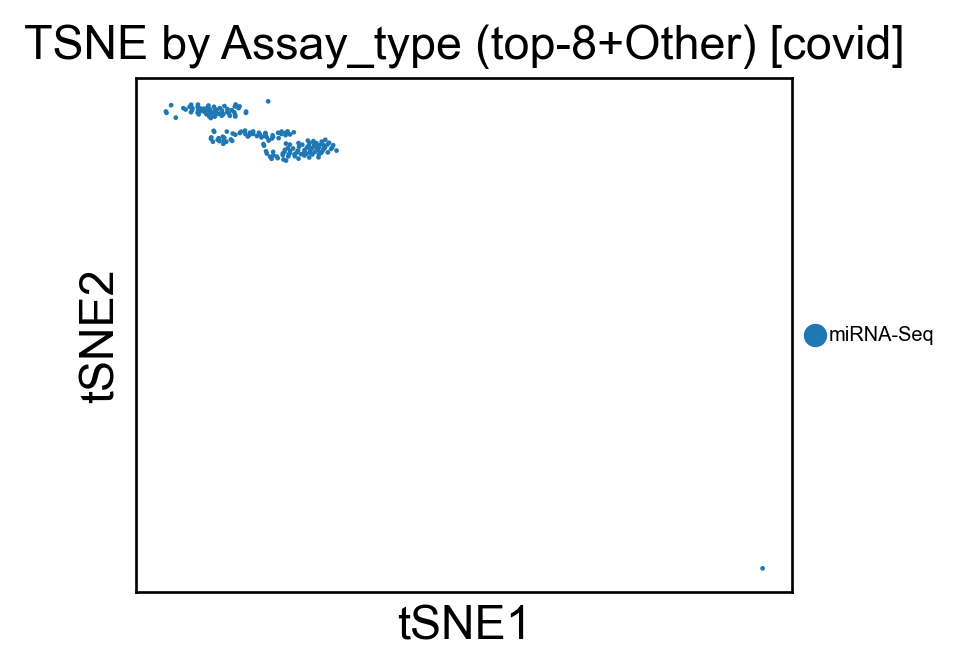

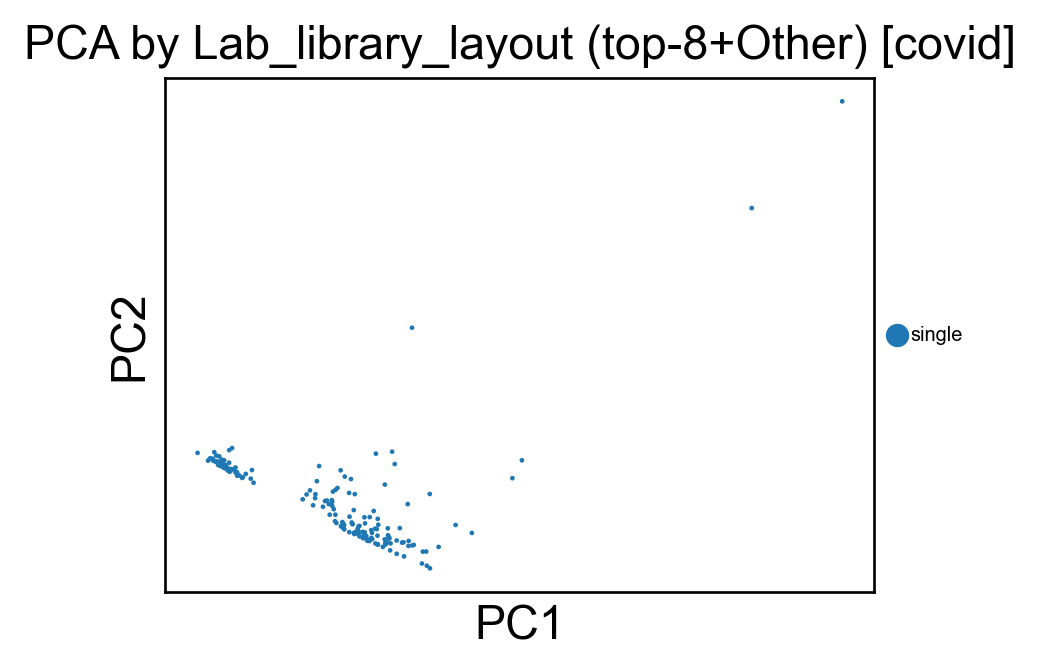

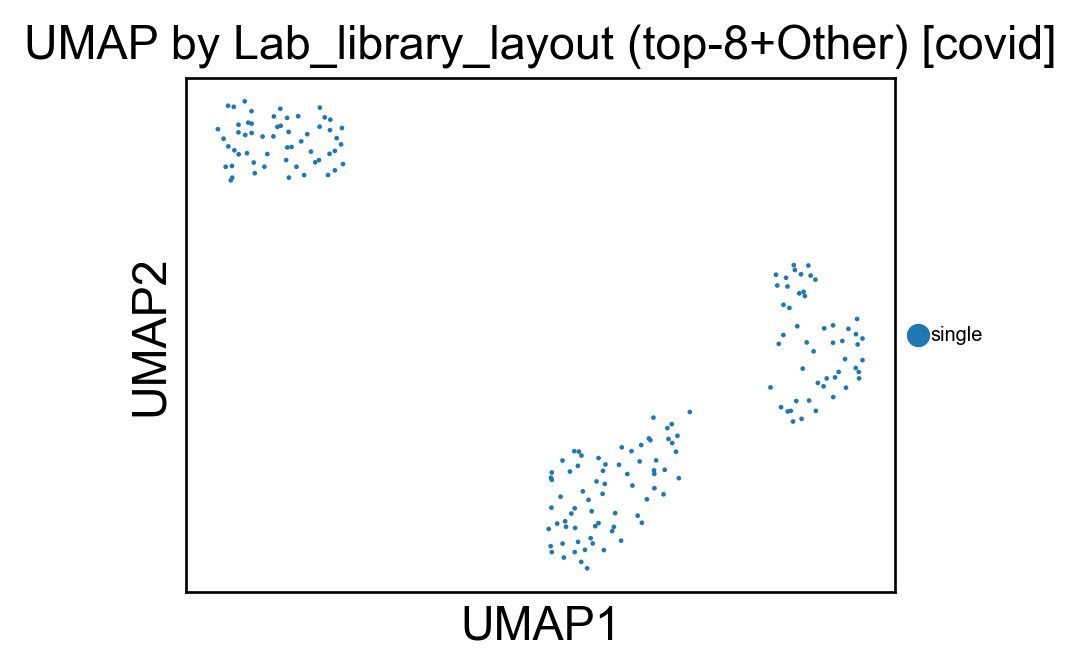

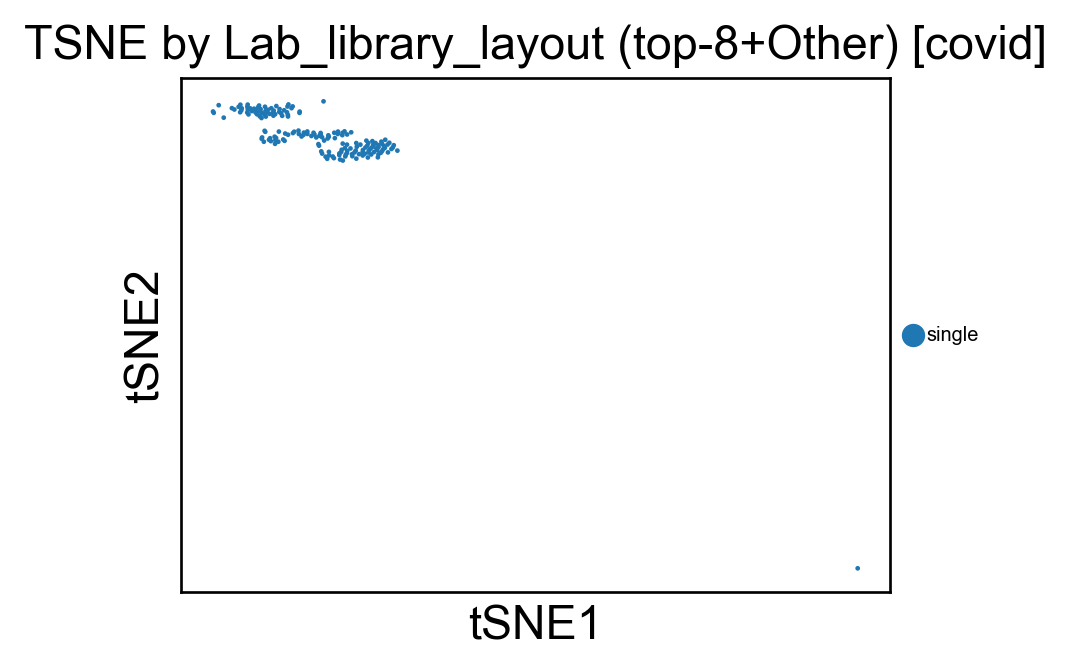

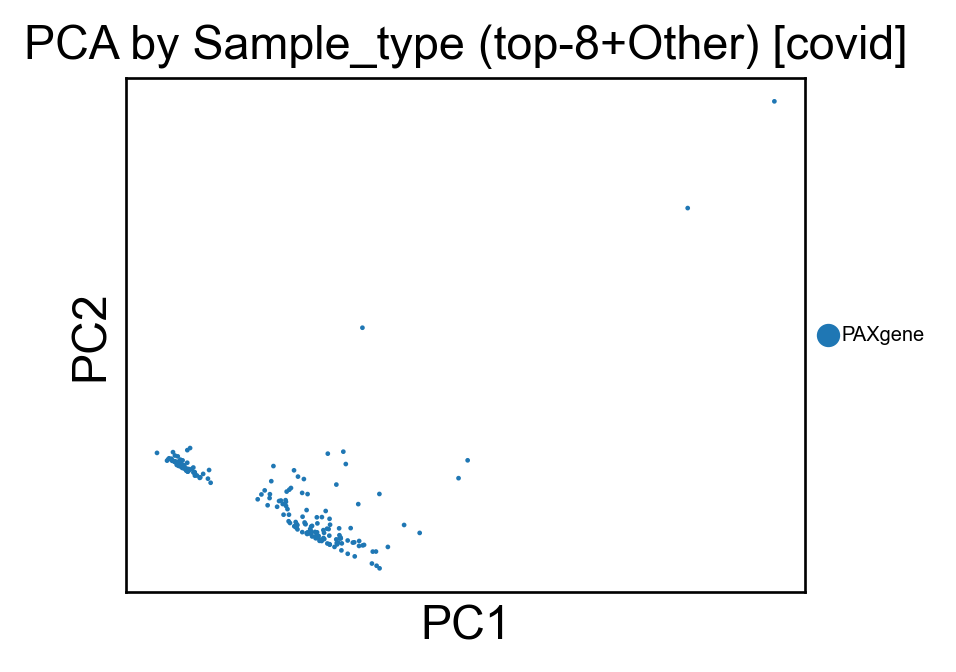

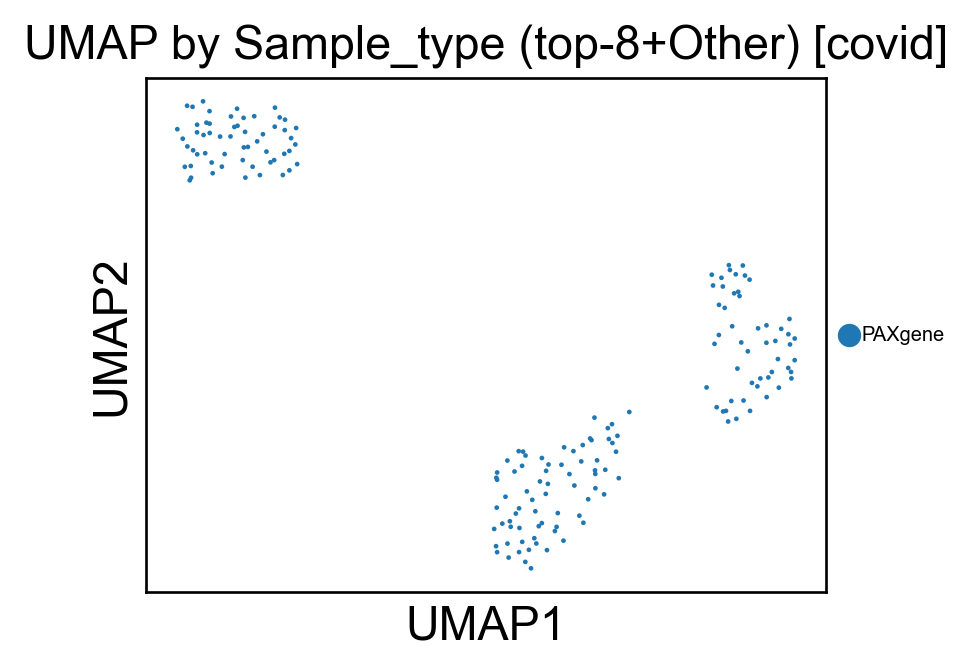

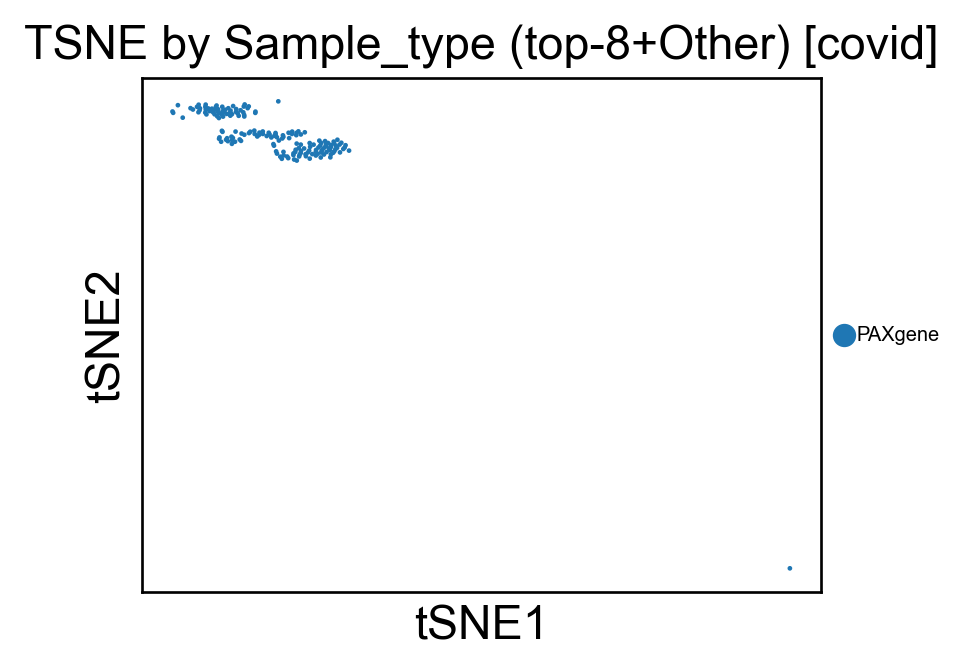

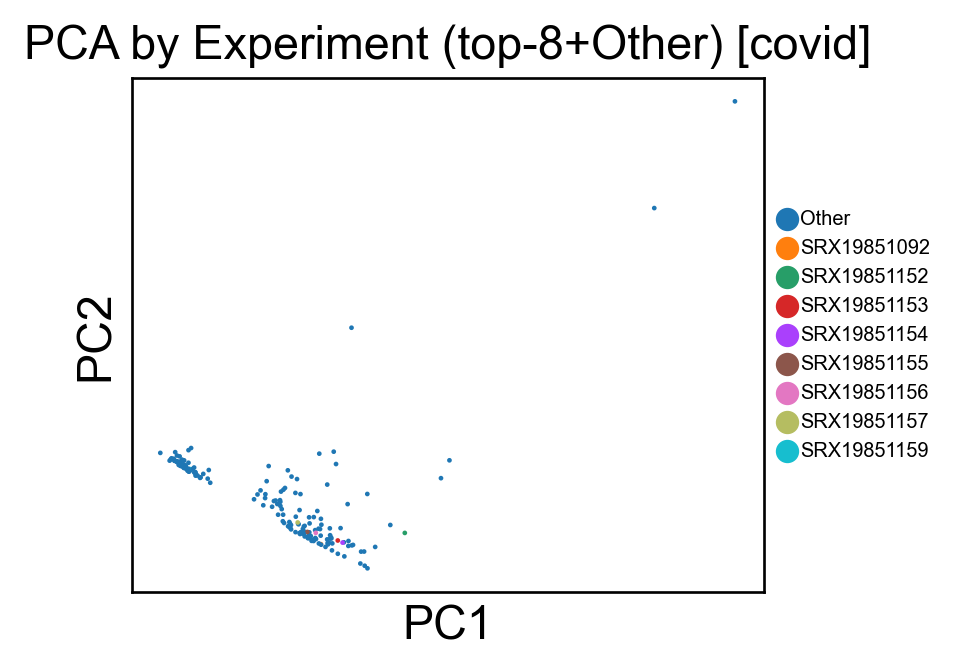

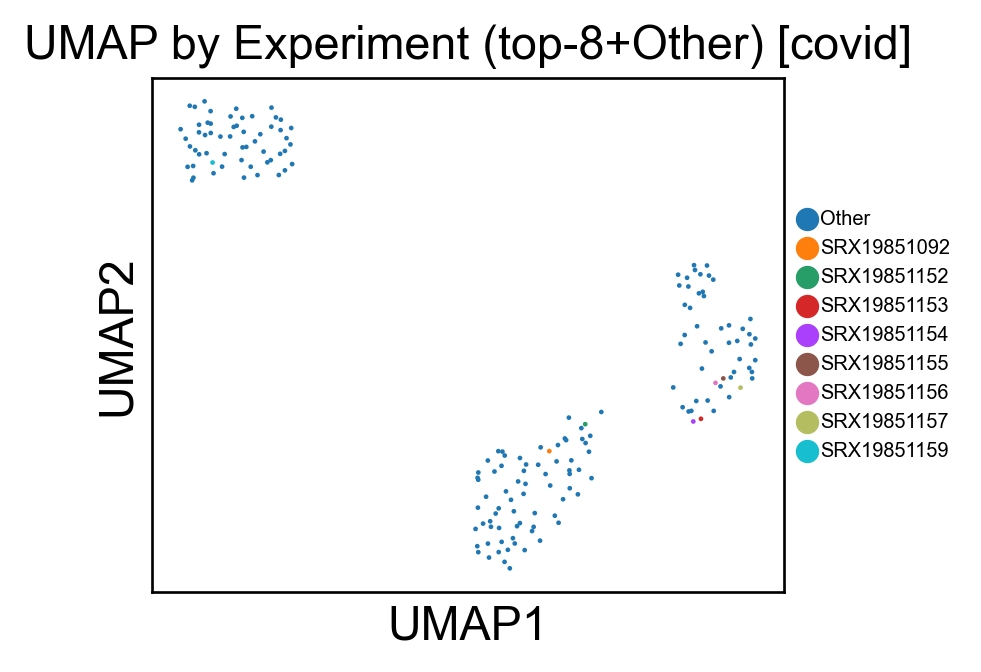

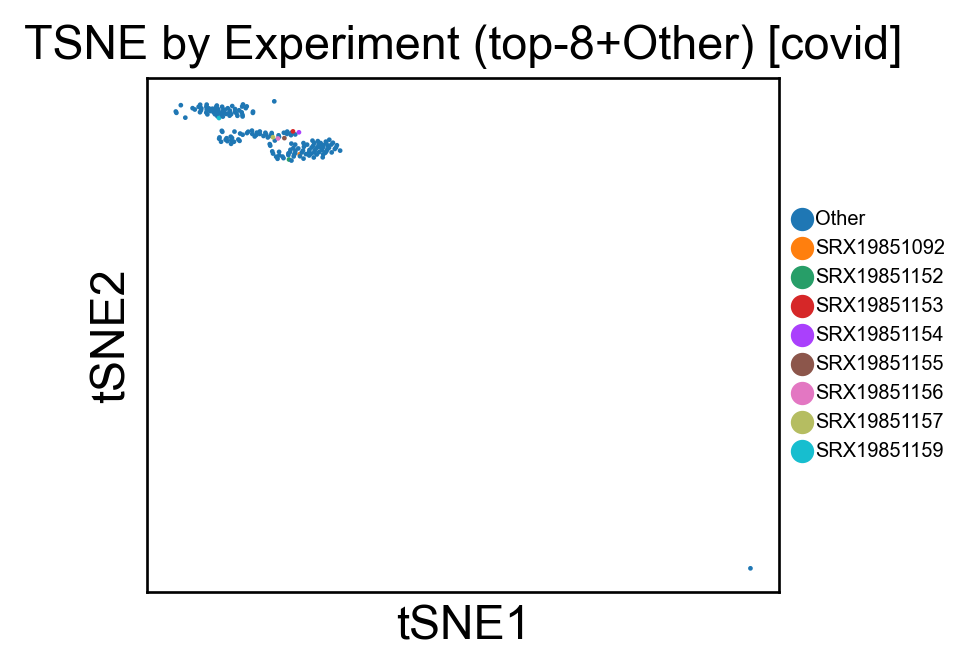

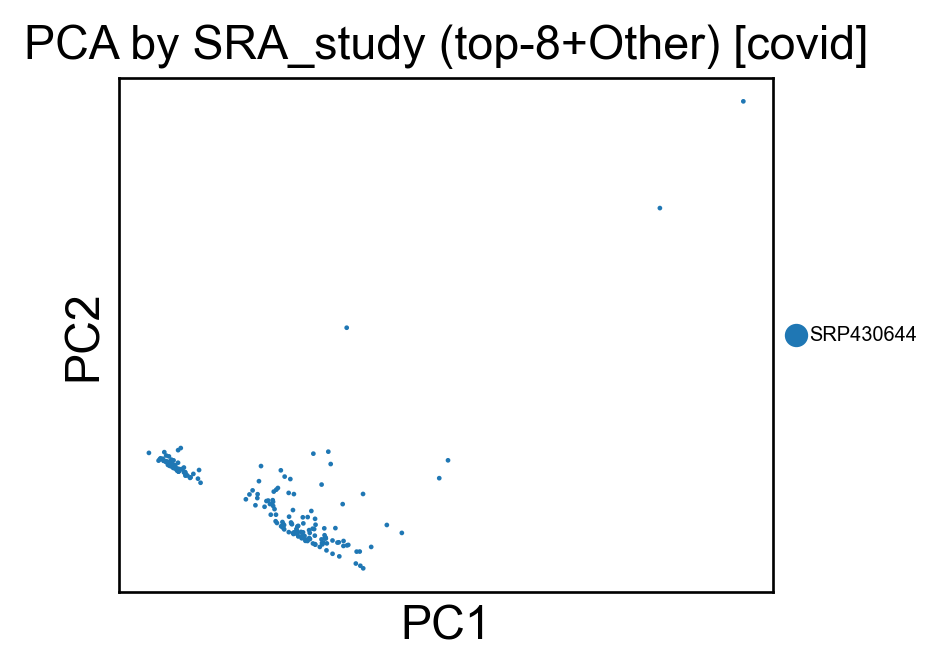

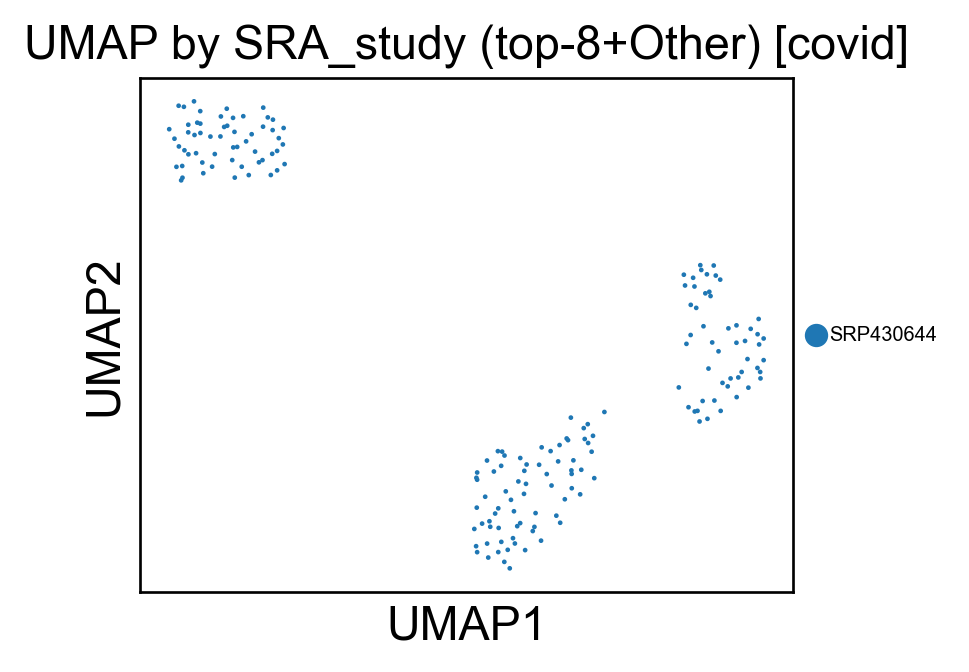

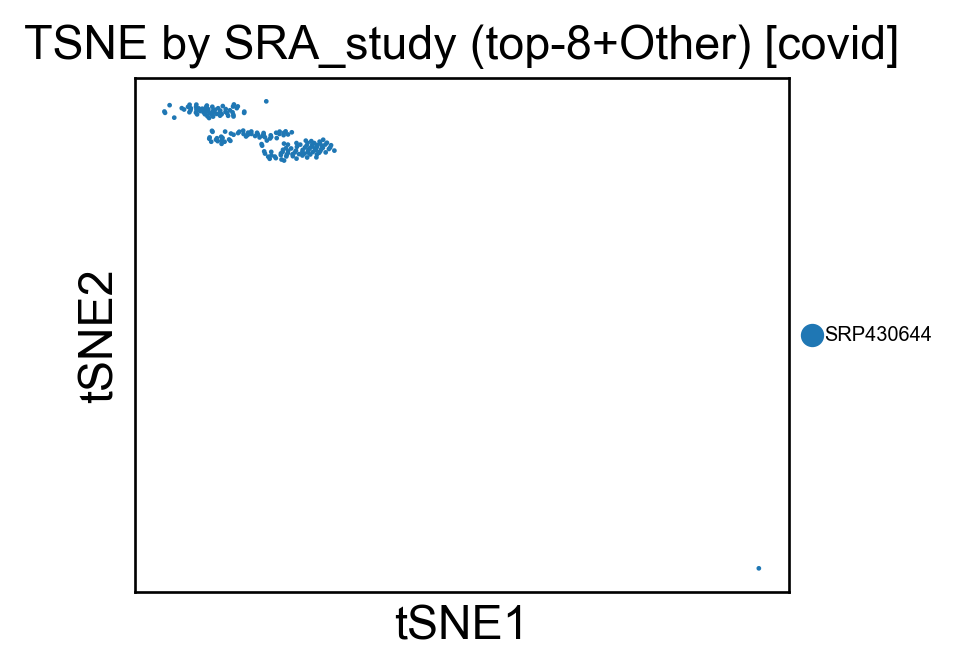

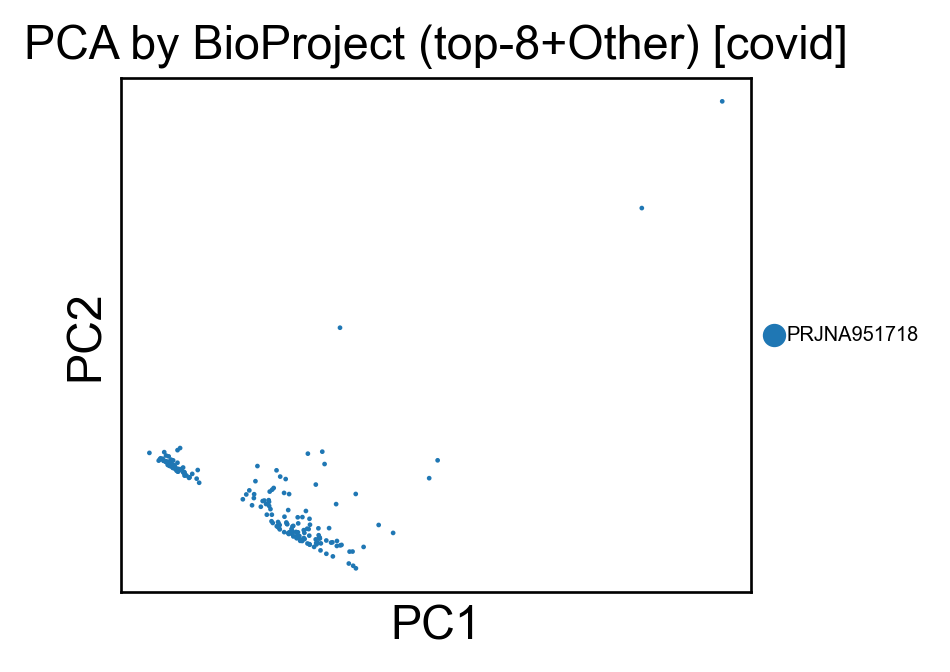

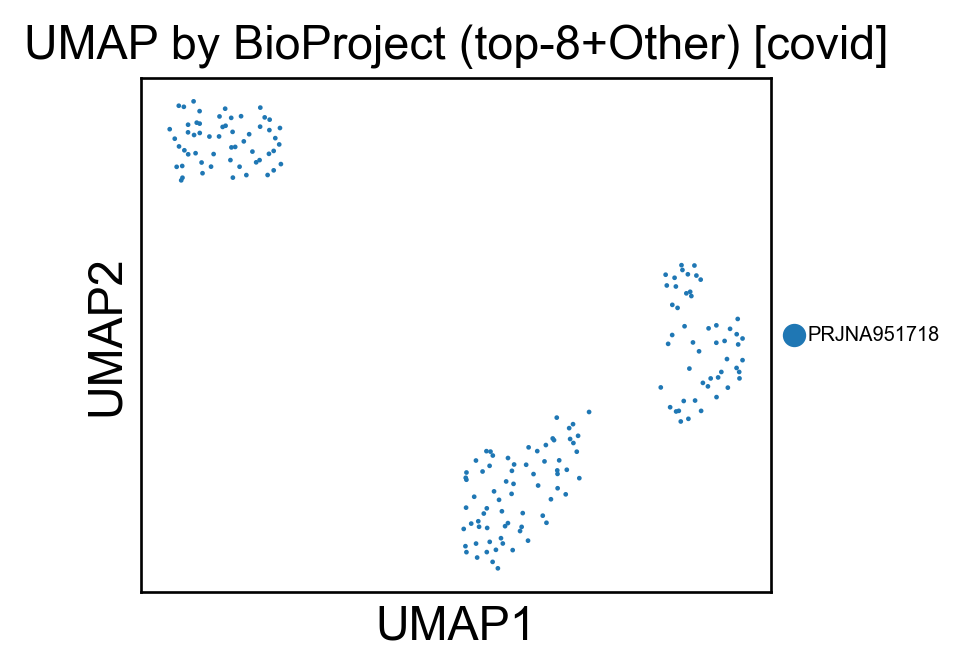

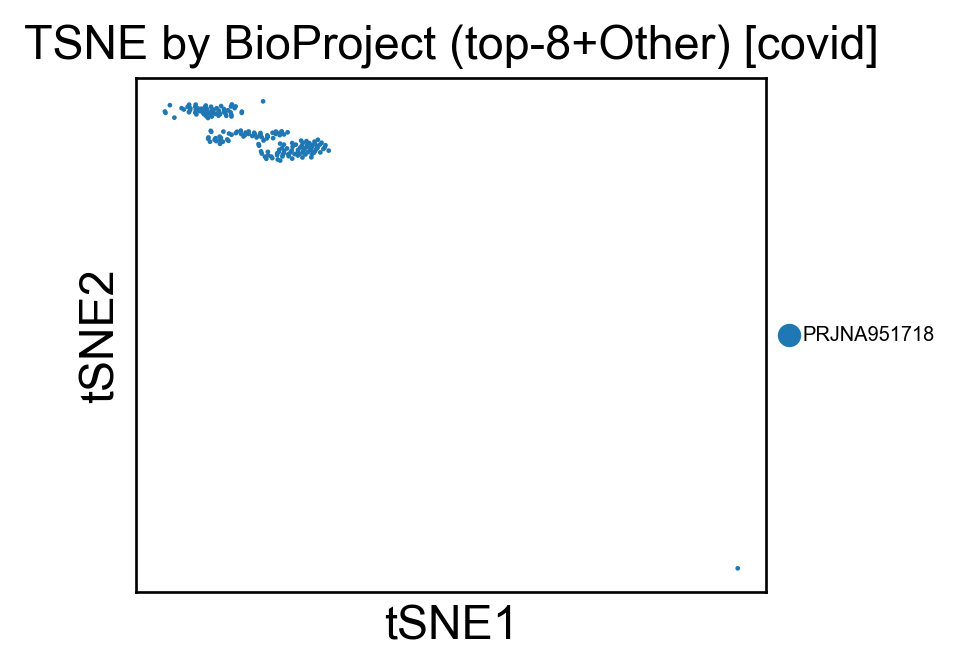

[covid] volcano skipped: no cells for positive/negative


In [33]:
# ===========================================
# Unified Batch Diagnostics + Volcano Report (ALL-KEY plotting version)
# ===========================================
import os, re, math
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scanpy as sc

from sklearn.feature_selection import f_classif
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.metrics import silhouette_score

# -------- global plotting defaults --------
sc.set_figure_params(figsize=(4, 3), dpi=120)
plt.rcParams["figure.figsize"] = (4, 3)

# =============== CONFIG ===================
N_PCS = 30
RANDOM_STATE = 42
MAX_CELLS_FOR_TSNE = 120000

# Batch candidates (put many; code will tell you why some are unusable)
BATCH_KEYS = [
    'Center_name','Sequencer','Lab_library_preparation_kit','Lab_RNA_extraction_protocol',
    'Lab_library_selection','Lab_library_source','Assay_type',
    'Lab_library_layout','Sample_type','Experiment','SRA_study','BioProject'
]

# Filtering controls (loosen these if you want "almost all" keys)
#   - Set RELAX=True to include nearly everything (except degenerate cases).
RELAX = True
MIN_LEVELS = 2                                # min distinct levels to consider as categorical
MAX_LEVELS = 9999 if RELAX else 50           # high cardinality allowed when RELAX
MIN_CELLS_PER_LEVEL = 2 if RELAX else 30     # allow small groups when RELAX

# Embedding plot grouping mode: "topk" or "facet"
GROUP_MODE = "topk"         # "topk" or "facet"
TOPK_K = 8                  # for topk mode
FACET_MAX_LEVELS = 8        # for facet mode
FACET_MIN_N = 30            # min cells to show a facet
POINT_SIZE = 8

# Which keys to PLOT embeddings for: "all" (기본) or "usable"
# - "all": 존재하는 모든 키(exist_keys)를 그림 (요청사항 반영)
# - "usable": audit 통과 키만 그림(없으면 exist_keys fallback)
PLOT_KEYS_MODE = "all"

# Volcano settings (optional; leave as None to skip)
VOLCANO_CONFIG = {
    # dataset_name: (condition_key, group1, group2, min_n_per_group)
    "neutrophil": ("diagnosis", "IBD", "Healthy", 30),
    "covid":      ("naat_result", "positive", "negative", 30),
}

# ==========================================
# Utility
# ==========================================
def _sanitize(x: str) -> str:
    return re.sub(r'[^A-Za-z0-9_.-]+', '_', str(x))

def _save(fig_path: Path):
    plt.tight_layout()
    plt.savefig(fig_path, bbox_inches="tight")
    plt.show()

def ensure_pca(adata, n_pcs=N_PCS, random_state=RANDOM_STATE):
    """Compute PCA on HVGs if possible; no-op if already present."""
    if 'X_pca' in adata.obsm and adata.obsm['X_pca'].shape[1] >= n_pcs:
        return
    if 'highly_variable' in adata.var:
        sc.pp.scale(adata, zero_center=True, max_value=10)
        sc.tl.pca(adata, n_comps=n_pcs, use_highly_variable=True,
                  svd_solver='arpack', random_state=random_state)
    else:
        sc.pp.scale(adata, zero_center=True, max_value=10)
        sc.tl.pca(adata, n_comps=n_pcs, svd_solver='arpack', random_state=random_state)

def compute_umap_tsne(adata, dataset_name, outdir_root, max_cells_tsne=MAX_CELLS_FOR_TSNE):
    """Compute neighbors/UMAP on full set; t-SNE on downsampled copy if needed."""
    outdir = Path(outdir_root)
    outdir.mkdir(parents=True, exist_ok=True)

    sc.pp.neighbors(adata, n_neighbors=15, n_pcs=min(N_PCS, adata.obsm['X_pca'].shape[1]))
    sc.tl.umap(adata, random_state=RANDOM_STATE)

    if adata.n_obs > max_cells_tsne:
        np.random.seed(RANDOM_STATE)
        keep_idx = np.random.choice(adata.obs_names, size=max_cells_tsne, replace=False)
        ad_tsne = adata[keep_idx].copy()
    else:
        ad_tsne = adata.copy()

    sc.tl.tsne(ad_tsne, random_state=RANDOM_STATE, use_rep='X_pca')
    return ad_tsne

# ==========================================
# Batch candidate filtering & reasons
# ==========================================
def audit_batch_keys(adata, keys, min_levels, max_levels, min_cells_per_level):
    """
    Return dict with 'usable' list and 'reasons' dict:
    - 'usable': keys that pass basic criteria
    - 'reasons': {key: "reason string"} for keys excluded
    """
    usable, reasons = [], {}
    for k in keys:
        if k not in adata.obs.columns:
            reasons[k] = "absent_in_obs"
            continue
        s = adata.obs[k].astype(str)
        vc = s.value_counts(dropna=False)
        nlev = vc.shape[0]
        if nlev < min_levels:
            reasons[k] = f"too_few_levels({nlev})"
            continue
        if nlev > max_levels:
            reasons[k] = f"too_many_levels({nlev})"
            continue
        if vc.min() < min_cells_per_level:
            reasons[k] = f"small_groups(min={int(vc.min())})"
            if RELAX:
                # Still allow if RELAX, but warn
                usable.append(k)
                continue
            else:
                continue
        usable.append(k)
    return {"usable": usable, "reasons": reasons}

# ==========================================
# Batch metrics
# ==========================================
def metric_pc_anova(adata, batch_key, n_pcs=N_PCS):
    pcs = adata.obsm['X_pca'][:, :n_pcs]
    y = pd.Categorical(adata.obs[batch_key]).codes
    _, pvals = f_classif(pcs, y)
    logp = -np.log10(np.maximum(pvals, 1e-300))
    return {
        "per_pc_log10p": logp,
        "log10p_mean": float(np.mean(logp)),
        "log10p_max": float(np.max(logp)),
        "log10p_pc_of_max": int(np.argmax(logp) + 1),
    }

def metric_batch_predictability(adata, batch_key, n_pcs=N_PCS):
    pcs = adata.obsm['X_pca'][:, :n_pcs]
    y = pd.Categorical(adata.obs[batch_key]).codes
    # Guard: at least 2 samples per class for CV to be stable
    vc = pd.Series(y).value_counts()
    if (vc < 2).any():
        return {"acc_mean": np.nan, "acc_std": np.nan}
    clf = Pipeline([
        ("scaler", StandardScaler(with_mean=True, with_std=True)),
        ("lr", LogisticRegression(max_iter=500, multi_class="auto"))
    ])
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)
    try:
        acc = cross_val_score(clf, pcs, y, cv=cv, scoring="accuracy")
        return {"acc_mean": float(acc.mean()), "acc_std": float(acc.std())}
    except Exception:
        return {"acc_mean": np.nan, "acc_std": np.nan}

def metric_silhouette_by_batch(adata, batch_key, n_pcs=N_PCS):
    pcs = adata.obsm['X_pca'][:, :n_pcs]
    y = pd.Categorical(adata.obs[batch_key]).codes
    vc = pd.Series(y).value_counts()
    if (vc < 2).any():
        return {"silhouette": np.nan}
    try:
        sil = silhouette_score(pcs, y)
    except Exception:
        sil = np.nan
    return {"silhouette": float(sil) if sil == sil else np.nan}

def evaluate_batch_key(adata, batch_key, n_pcs=N_PCS):
    res_a = metric_pc_anova(adata, batch_key, n_pcs=n_pcs)
    res_b = metric_batch_predictability(adata, batch_key, n_pcs=n_pcs)
    res_c = metric_silhouette_by_batch(adata, batch_key, n_pcs=n_pcs)
    out = {
        "batch_key": batch_key,
        "log10p_mean": res_a["log10p_mean"],
        "log10p_max": res_a["log10p_max"],
        "log10p_pc_of_max": res_a["log10p_pc_of_max"],
        "acc_mean": res_b["acc_mean"],
        "acc_std": res_b["acc_std"],
        "silhouette": res_c["silhouette"],
        "per_pc_log10p": res_a["per_pc_log10p"],
    }
    return out

# ==========================================
# Embedding plots with grouping
# ==========================================
def topk_or_other(adata, key, k=8, other_name='Other'):
    vc = adata.obs[key].astype(str).value_counts()
    keep = set(vc.head(k).index)
    return adata.obs[key].astype(str).where(adata.obs[key].astype(str).isin(keep), other_name)

def plot_embeddings_grouped(adata, ad_tsne, dataset_name, key, outdir, mode="topk",
                            topk_k=8, facet_max_levels=8, facet_min_n=30, point_size=8):
    if key not in adata.obs.columns:
        return
    outdir = Path(outdir); outdir.mkdir(parents=True, exist_ok=True)
    safe_key = _sanitize(key)

    if mode == "topk":
        col = f'{key}_top{topk_k}'
        # 1) adata에 파생 컬럼 생성
        adata.obs[col] = topk_or_other(adata, key, k=topk_k).astype(str)
        # 2) ad_tsne에도 동일 컬럼을 인덱스 정렬해 주입 (여기가 핵심 수정)
        ad_tsne.obs[col] = adata.obs.loc[ad_tsne.obs_names, col].astype(str).values

        for basis, obj, tag in [("pca", adata, "pca"), ("umap", adata, "umap"), ("tsne", ad_tsne, "tsne")]:
            getattr(sc.pl, basis)(obj, color=col, show=False, size=point_size,
                                  legend_loc='right margin', legend_fontsize=6)
            plt.title(f'{basis.upper()} by {key} (top-{topk_k}+Other) [{dataset_name}]')
            _save(Path(outdir) / f"{tag}_top{topk_k}_{safe_key}__{_sanitize(dataset_name)}.png")

    elif mode == "facet":
        vc = adata.obs[key].astype(str).value_counts()
        levels = [lvl for lvl, n in vc.items() if n >= facet_min_n][:facet_max_levels]
        if not levels:
            return
        cols = 4
        rows = math.ceil(len(levels)/cols)
        # PCA
        fig, axes = plt.subplots(rows, cols, figsize=(3*cols, 3*rows))
        axes = axes.ravel()
        for i, lvl in enumerate(levels):
            sub = adata[adata.obs[key].astype(str) == lvl]
            sc.pl.pca(sub, show=False, ax=axes[i], size=point_size, legend_loc='none')
            axes[i].set_title(f'{key}={lvl}', fontsize=8)
        for j in range(i+1, rows*cols):
            fig.delaxes(axes[j])
        fig.suptitle(f'PCA facets by {key} [{dataset_name}]', y=1.02, fontsize=10)
        _save(Path(outdir) / f"pca_facets_{safe_key}__{_sanitize(dataset_name)}.png")

        # UMAP
        fig, axes = plt.subplots(rows, cols, figsize=(3*cols, 3*rows))
        axes = axes.ravel()
        for i, lvl in enumerate(levels):
            sub = adata[adata.obs[key].astype(str) == lvl]
            sc.pl.umap(sub, show=False, ax=axes[i], size=point_size, legend_loc='none')
            axes[i].set_title(f'{key}={lvl}', fontsize=8)
        for j in range(i+1, rows*cols):
            fig.delaxes(axes[j])
        fig.suptitle(f'UMAP facets by {key} [{dataset_name}]', y=1.02, fontsize=10)
        _save(Path(outdir) / f"umap_facets_{safe_key}__{_sanitize(dataset_name)}.png")

        # t-SNE
        fig, axes = plt.subplots(rows, cols, figsize=(3*cols, 3*rows))
        axes = axes.ravel()
        for i, lvl in enumerate(levels):
            sub = ad_tsne[ad_tsne.obs[key].astype(str) == lvl]
            sc.pl.tsne(sub, show=False, ax=axes[i], size=point_size, legend_loc='none')
            axes[i].set_title(f'{key}={lvl}', fontsize=8)
        for j in range(i+1, rows*cols):
            fig.delaxes(axes[j])
        fig.suptitle(f't-SNE facets by {key} [{dataset_name}]', y=1.02, fontsize=10)
        _save(Path(outdir) / f"tsne_facets_{safe_key}__{_sanitize(dataset_name)}.png")


# ==========================================
# Volcano plot
# ==========================================
def run_volcano(adata, dataset_name, condition_key, group1, group2, min_n=30, outdir="volcano"):
    outdir = Path(outdir); outdir.mkdir(parents=True, exist_ok=True)
    if condition_key not in adata.obs.columns:
        print(f"[{dataset_name}] volcano skipped: {condition_key} not in .obs")
        return None

    sub = adata[adata.obs[condition_key].isin([group1, group2])].copy()
    if sub.n_obs == 0:
        print(f"[{dataset_name}] volcano skipped: no cells for {group1}/{group2}")
        return None

    vc = sub.obs[condition_key].value_counts()
    if vc.min() < min_n:
        print(f"[{dataset_name}] volcano warning: small groups {dict(vc)} (min<{min_n})")

    sub.obs[condition_key] = sub.obs[condition_key].astype('category')
    # pandas>=2.0: set_categories returns new Categorical
    sub.obs[condition_key] = sub.obs[condition_key].cat.set_categories([group1, group2], ordered=False)

    # Ensure we have normalized/log1p; if not, use current X as raw fallback
    if sub.raw is None:
        sub.raw = sub.copy()

    sc.tl.rank_genes_groups(sub, groupby=condition_key, groups=[group1], reference=group2,
                            method='wilcoxon', use_raw=True)
    df = sc.get.rank_genes_groups_df(sub, group=group1)
    p = df['pvals_adj'] if 'pvals_adj' in df.columns else df['pvals']
    x = df['logfoldchanges']
    y = -np.log10(np.maximum(p.values, 1e-300))

    plt.figure(figsize=(4,3))
    plt.scatter(x, y, s=8)
    plt.xlabel('log2 fold change'); plt.ylabel(r'$-\log_{10}(p)$')
    plt.title(f'Volcano: {group1} vs {group2} [{dataset_name}]')
    _save(outdir / f"volcano__{_sanitize(condition_key)}_{_sanitize(group1)}_vs_{_sanitize(group2)}__{_sanitize(dataset_name)}.png")

    df.to_csv(outdir / f"volcano_table__{_sanitize(condition_key)}_{_sanitize(group1)}_vs_{_sanitize(group2)}__{_sanitize(dataset_name)}.csv", index=False)
    return df

# ==========================================
# REPORT RUNNER
# ==========================================
def run_full_report(adata, dataset_name, batch_keys, out_root="eda_outputs"):
    """
    For a given dataset:
      1) Ensure PCA; save PCA variance ratio
      2) Compute UMAP + t-SNE
      3) Evaluate ALL candidate batch keys (with reasons table)
      4) Save metrics CSV + summary plots (bar/heatmap)
      5) Draw embedding plots grouped by each key (mode-controlled)
      6) Volcano (if VOLCANO_CONFIG has an entry)
    """
    ds_out = Path(out_root) / f"report_{_sanitize(dataset_name)}"
    ds_out.mkdir(parents=True, exist_ok=True)

    # 1) PCA (and explained variance)
    ensure_pca(adata, n_pcs=N_PCS)
    fig, ax = plt.subplots()
    ax.plot(np.arange(1, N_PCS+1), adata.uns['pca']['variance_ratio'][:N_PCS], marker='o')
    ax.set_xlabel('PC'); ax.set_ylabel('Explained variance ratio')
    ax.set_title('PCA explained variance ratio')
    _save(ds_out / f"pca_variance_ratio__{_sanitize(dataset_name)}.png")

    # 2) UMAP + t-SNE data
    ad_tsne = compute_umap_tsne(adata, dataset_name, ds_out)

    # 3) Batch candidate audit (include reasons for exclusion)
    audit = audit_batch_keys(adata, batch_keys, MIN_LEVELS, MAX_LEVELS, MIN_CELLS_PER_LEVEL)
    usable = audit["usable"]
    reasons = audit["reasons"]
    # Save reasons table
    reason_rows = []
    for k in batch_keys:
        status = "usable" if k in usable else reasons.get(k, "excluded")
        reason_rows.append({"batch_key": k, "status_or_reason": status})
    pd.DataFrame(reason_rows).to_csv(ds_out / "batch_key_audit.csv", index=False)
    print(f"[{dataset_name}] usable batch keys: {usable or 'None'}")
    print(f"[{dataset_name}] audit saved → {ds_out/'batch_key_audit.csv'}")

    # 4) Metrics for ALL keys that exist in obs (even if high-cardinality)
    exist_keys = [k for k in batch_keys if k in adata.obs.columns]
    metric_rows = []
    for k in exist_keys:
        try:
            metric_rows.append(evaluate_batch_key(adata, k))
        except Exception as e:
            metric_rows.append({
                "batch_key": k, "log10p_mean": np.nan, "log10p_max": np.nan,
                "log10p_pc_of_max": np.nan, "acc_mean": np.nan, "acc_std": np.nan,
                "silhouette": np.nan, "per_pc_log10p": np.array([])
            })
            print(f"[{dataset_name}] metric error for {k}: {e}")

    df = pd.DataFrame(metric_rows)
    # Composite ranking (nan-safe): rank nan as worst (ascending=False -> NaNs go to end)
    for col in ["log10p_mean", "acc_mean", "silhouette"]:
        df[f"rank_{col}"] = df[col].rank(ascending=False, method="min", na_option='bottom')
    df["rank_avg"] = df[[f"rank_{c}" for c in ["log10p_mean","acc_mean","silhouette"]]].mean(axis=1)
    df = df.sort_values("rank_avg", ascending=False)  # larger rank_avg ~ stronger effect (descending ranks)

    df_out = df.drop(columns=["per_pc_log10p"], errors="ignore")
    df_out.to_csv(ds_out / "batch_metrics_all_existing_keys.csv", index=False)
    print(f"[{dataset_name}] metrics saved → {ds_out/'batch_metrics_all_existing_keys.csv'}")

    # Plots: bars (acc/silhouette/log10p_mean) using all existing keys
    def _barplot(col, title):
        order = df.sort_values(col, ascending=False)
        plt.figure(figsize=(max(6, 0.35*len(order)), 3.5))
        plt.bar(order["batch_key"].astype(str), order[col].values)
        plt.xticks(rotation=45, ha="right"); plt.ylabel(col); plt.title(f"{title} [{dataset_name}]")
        _save(ds_out / f"{_sanitize(col)}__{_sanitize(dataset_name)}.png")

    for col, title in [("acc_mean","Batch predictability (CV accuracy)"),
                       ("silhouette","Silhouette by batch (PC space)"),
                       ("log10p_mean","Mean −log10(p) across PCs (ANOVA)")]:
        _barplot(col, title)

    # Heatmap for top keys by rank (take up to 8 with valid per_pc_log10p)
    valid_mask = df["per_pc_log10p"].apply(lambda x: isinstance(x, np.ndarray) and x.size > 0)
    top_keys = df.loc[valid_mask, "batch_key"].head(8).tolist()
    if top_keys:
        mats = []
        for bk in top_keys:
            vec = df.loc[df["batch_key"] == bk, "per_pc_log10p"].values[0]
            # pad/truncate to N_PCS just in case
            if vec.shape[0] < N_PCS:
                pad = np.full(N_PCS - vec.shape[0], np.nan)
                vec = np.concatenate([vec, pad])
            else:
                vec = vec[:N_PCS]
            mats.append(vec)
        mat = np.vstack(mats)
        plt.figure(figsize=(8, 1.2*len(top_keys)+1))
        plt.imshow(mat, aspect="auto", interpolation="nearest")
        plt.colorbar(label="−log10(p) (ANOVA by batch)")
        plt.yticks(range(len(top_keys)), top_keys)
        plt.xticks(range(N_PCS), range(1, N_PCS+1))
        plt.xlabel("PC"); plt.title(f"Per-PC batch association (top keys) [{dataset_name}]")
        _save(ds_out / f"pc_log10p_heatmap__{_sanitize(dataset_name)}.png")

    # 5) Embedding plots grouped by keys (mode-controlled)
    if PLOT_KEYS_MODE.lower() == "usable":
        keys_to_plot = (usable if usable else exist_keys)
    else:
        keys_to_plot = exist_keys  # 요청: 모든 키 플로팅

    emb_outdir = ds_out / "embeddings"
    for key in keys_to_plot:
        plot_embeddings_grouped(
            adata, ad_tsne, dataset_name, key,
            outdir=emb_outdir,
            mode=GROUP_MODE,
            topk_k=TOPK_K,
            facet_max_levels=FACET_MAX_LEVELS,
            facet_min_n=FACET_MIN_N,
            point_size=POINT_SIZE
        )

    # 6) Volcano (if configured)
    if dataset_name in VOLCANO_CONFIG and VOLCANO_CONFIG[dataset_name] is not None:
        ck, g1, g2, min_n = VOLCANO_CONFIG[dataset_name]
        run_volcano(
            adata, dataset_name, ck, g1, g2,
            min_n=min_n,
            outdir=ds_out / "volcano"
        )

    return df, ds_out

# ============================
# RUN REPORT (for your data)
# ============================
# 주의: 아래 두 객체(neu_adata_proc, cov_adata_proc)는 메모리에 이미 존재해야 합니다.
DATASETS = {
    "neutrophil": neu_adata_proc,  # must exist in memory
    "covid":      cov_adata_proc,  # must exist in memory
}

all_results = {}
for ds_name, ad in DATASETS.items():
    print(f"\n=== Running report for: {ds_name} ===")
    all_results[ds_name] = run_full_report(ad, ds_name, BATCH_KEYS)


/Users/mjlee/master_thesis/Thesis_project/thesispjt/thesis-impute/lib/python3.12/site-packages/scanpy/preprocessing/_pca/__init__.py:227: FutureWarning: Argument `use_highly_variable` is deprecated, consider using the mask argument. Use_highly_variable=True can be called through mask_var="highly_variable". Use_highly_variable=False can be called through mask_var=None
  mask_var_param, mask_var = _handle_mask_var(


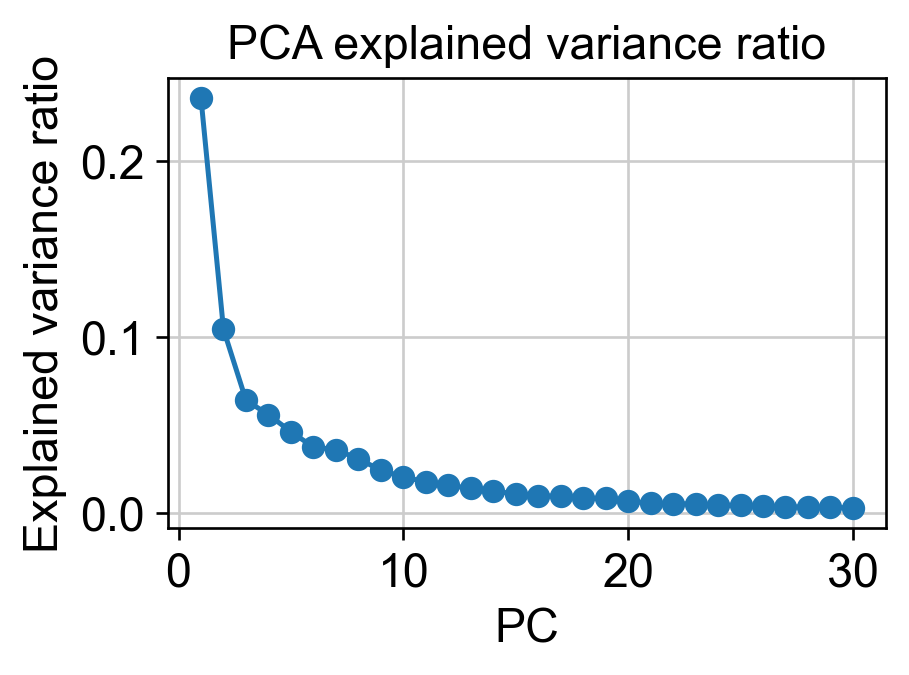

/Users/mjlee/master_thesis/Thesis_project/thesispjt/thesis-impute/lib/python3.12/site-packages/sklearn/manifold/_spectral_embedding.py:328: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


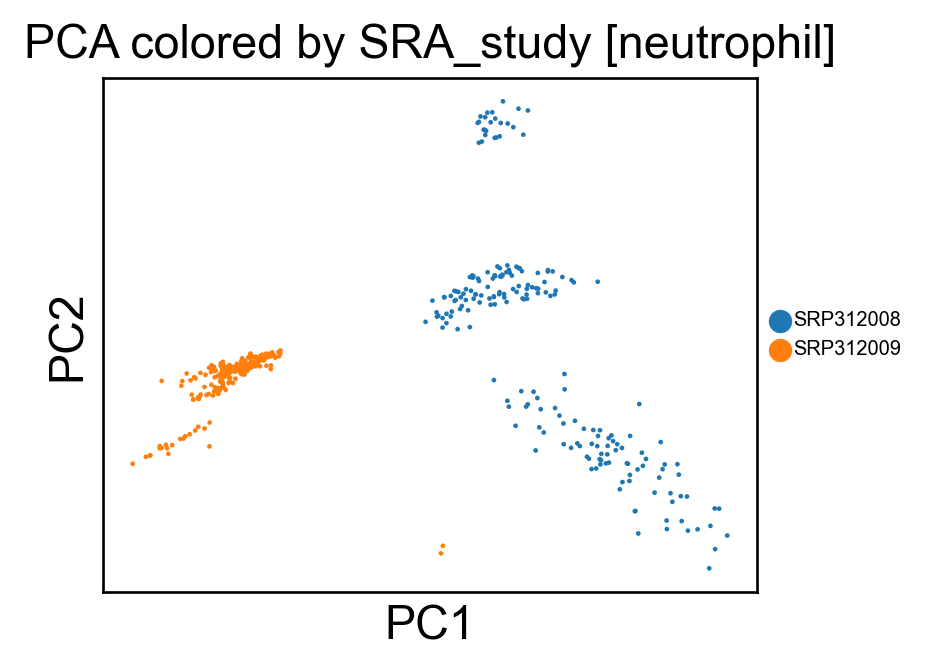

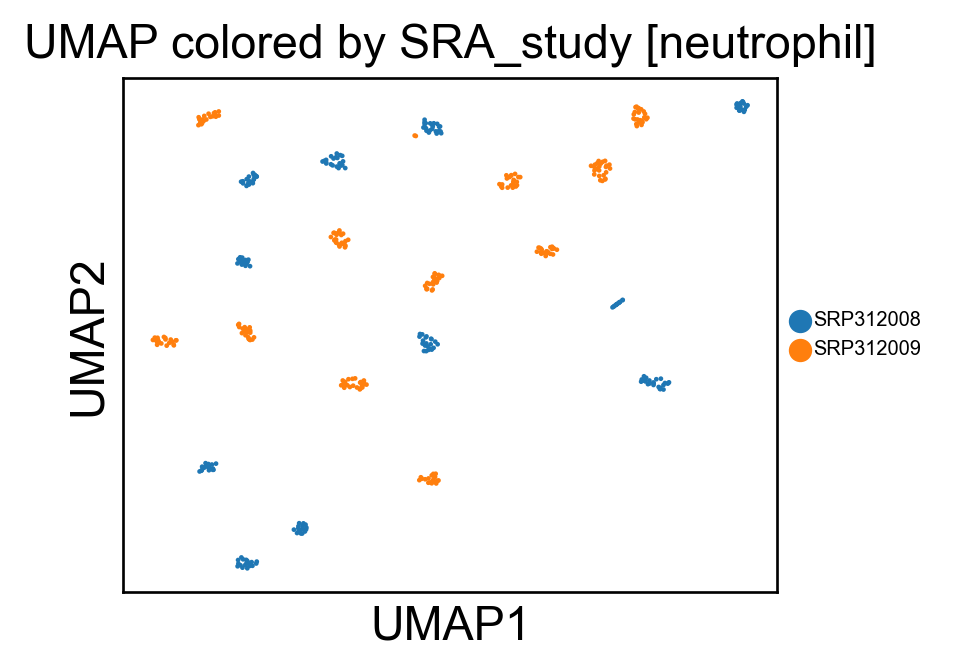

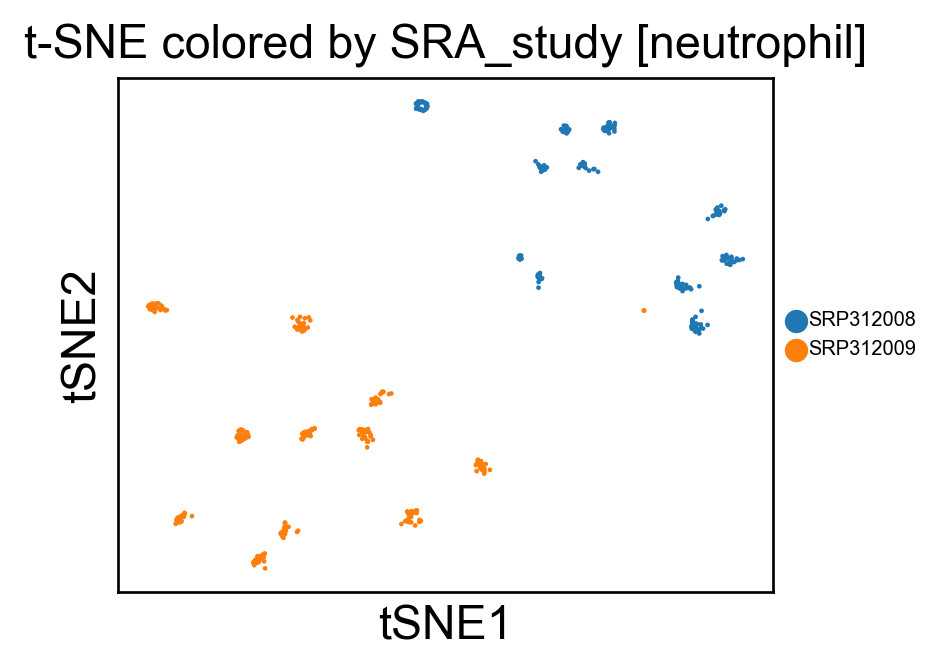

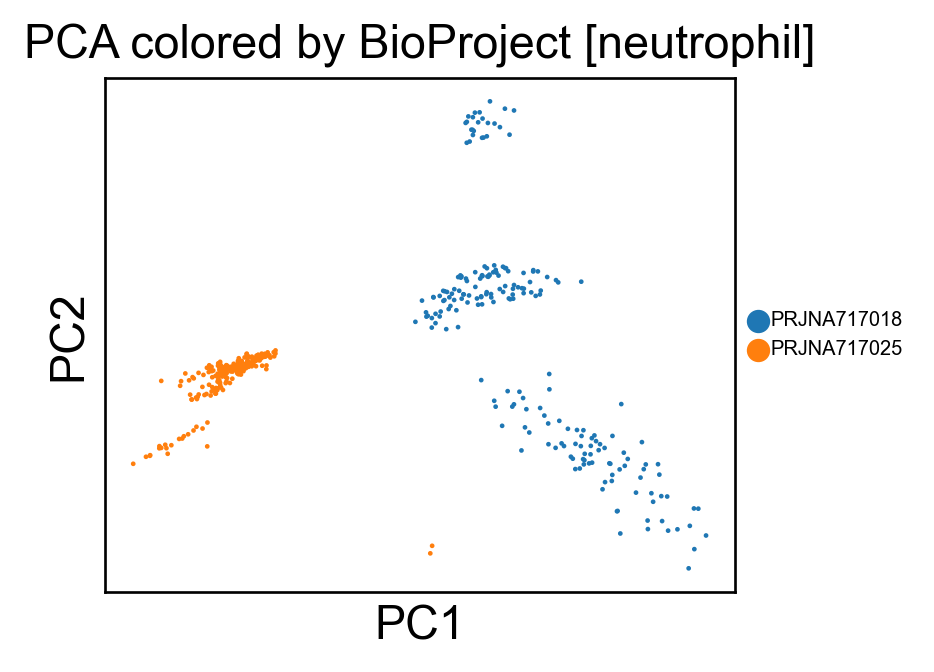

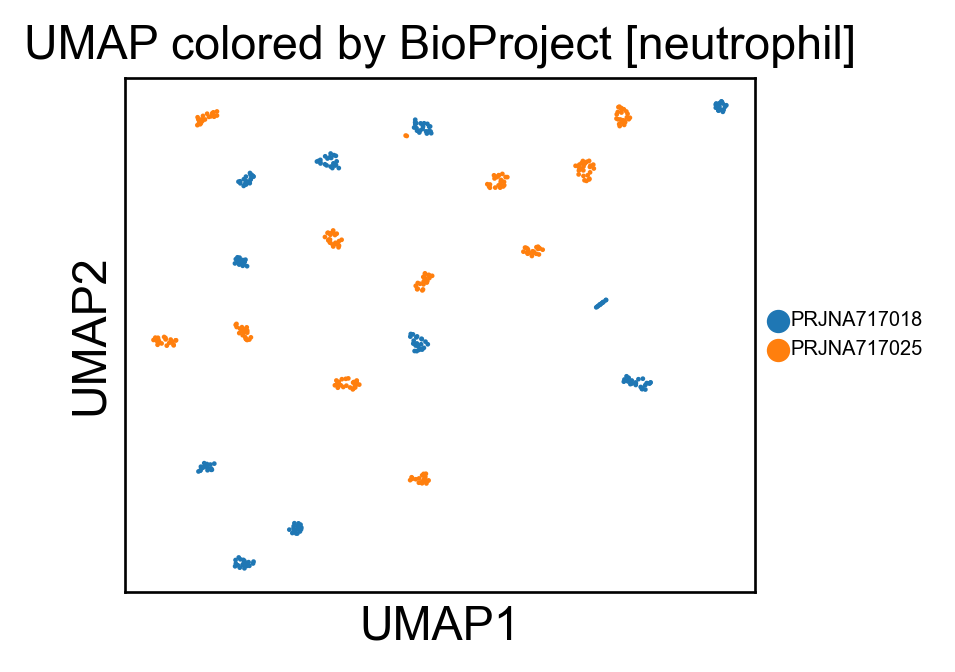

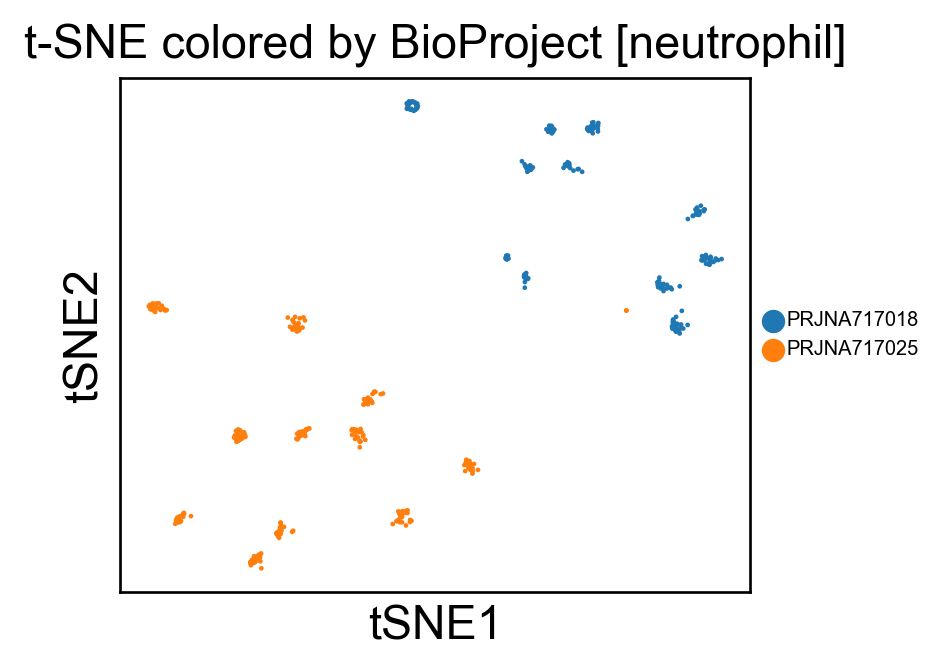

/Users/mjlee/master_thesis/Thesis_project/thesispjt/thesis-impute/lib/python3.12/site-packages/scanpy/preprocessing/_pca/__init__.py:227: FutureWarning: Argument `use_highly_variable` is deprecated, consider using the mask argument. Use_highly_variable=True can be called through mask_var="highly_variable". Use_highly_variable=False can be called through mask_var=None
  mask_var_param, mask_var = _handle_mask_var(


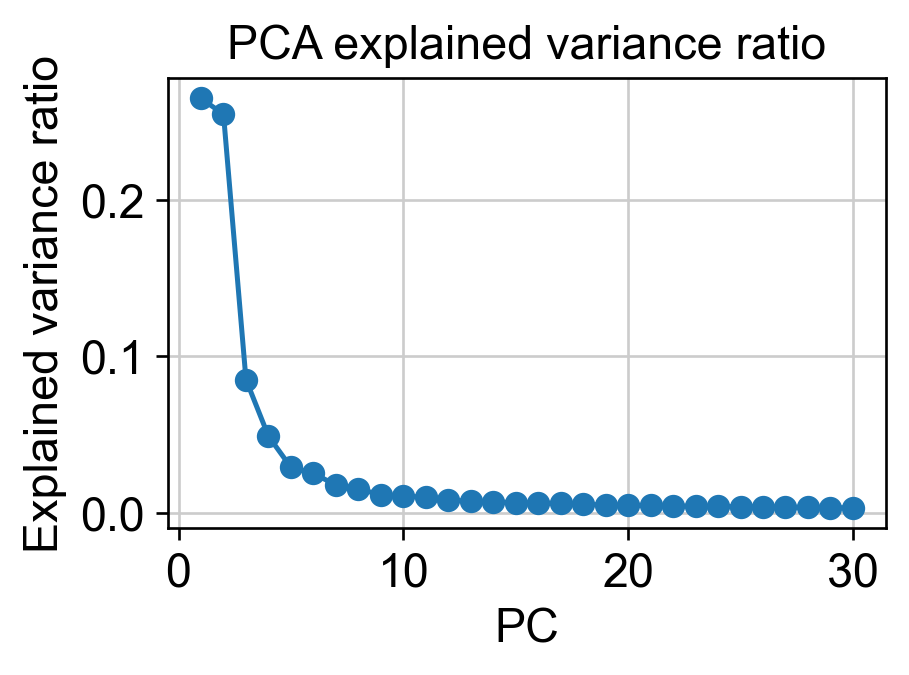

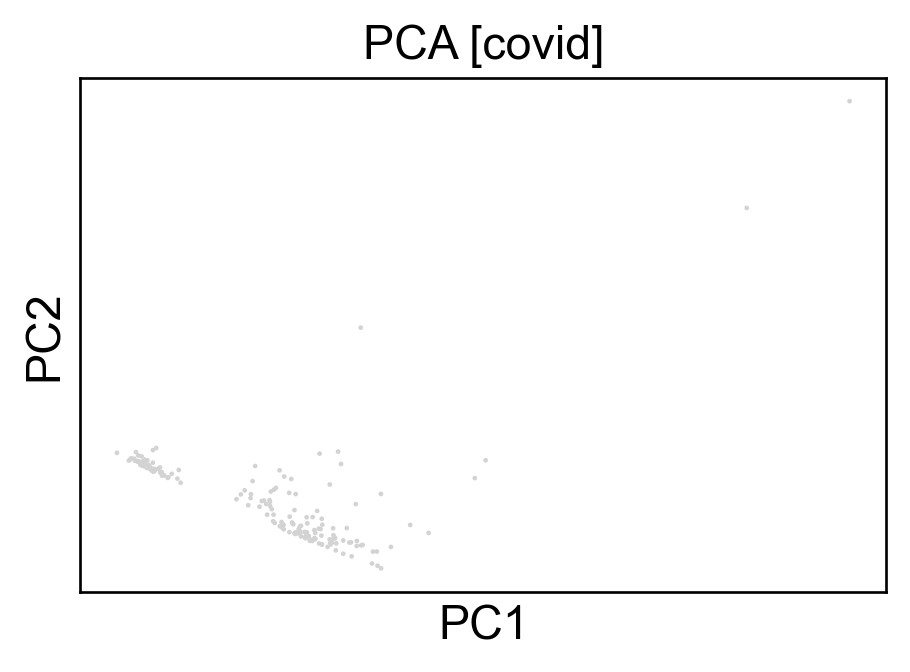

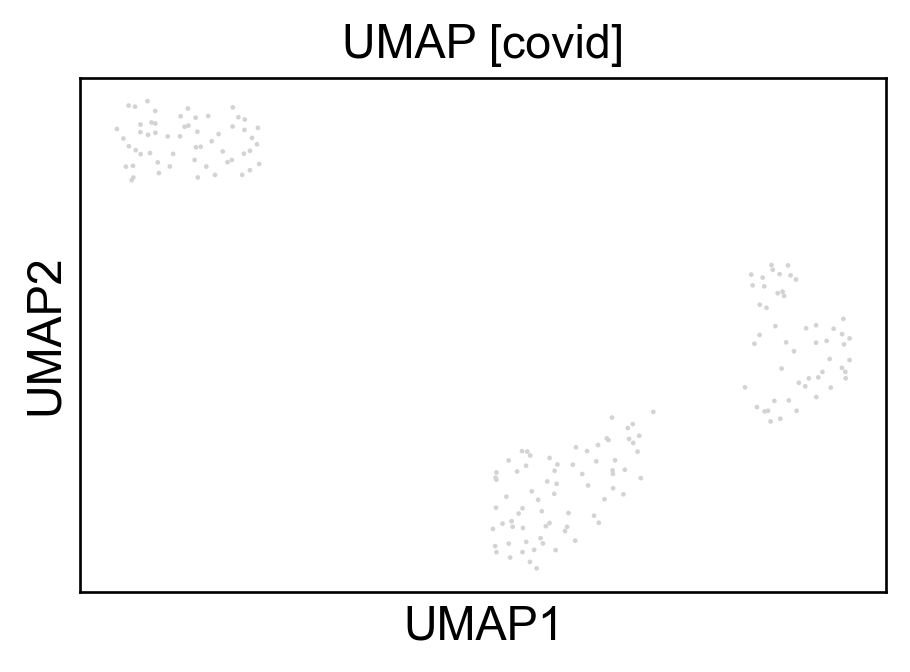

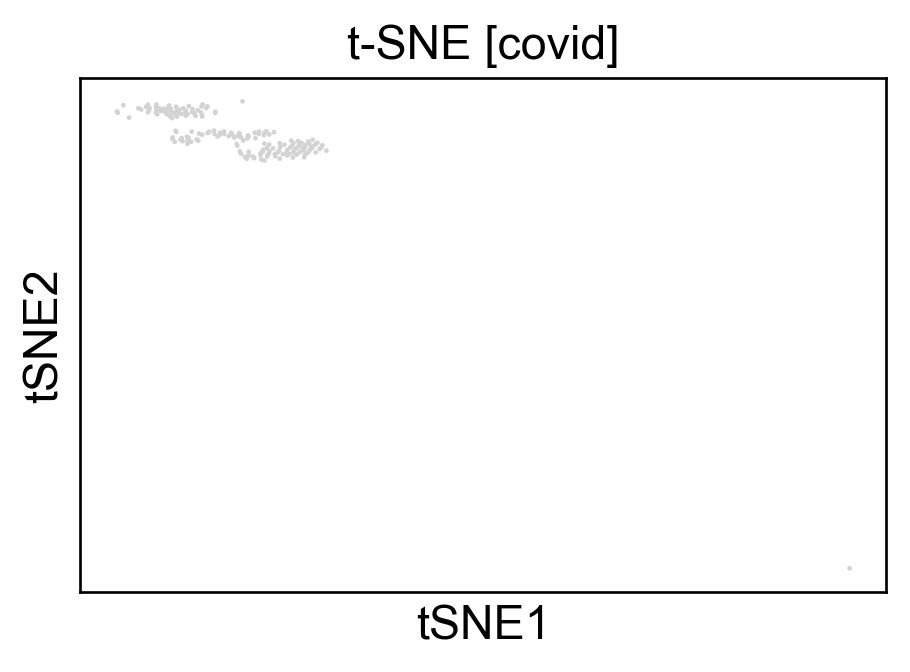

In [28]:
DATASETS = {
    "neutrophil": neu_adata_proc,
    "covid":      cov_adata_proc,
}

for ds_name, ad in DATASETS.items():
    # 1) Compute embeddings once
    ad, ad_tsne = run_embeddings_once(
        adata=ad,
        n_pcs=N_PCS,
        random_state=RANDOM_STATE,
        max_cells_tsne=MAX_CELLS_FOR_TSNE,
        dataset_name=ds_name
    )

    # 2) Plot with multiple batch keys (only those present & reasonable levels)
    plot_embeddings_by_batch(
        adata=ad,
        adata_tsne=ad_tsne,
        dataset_name=ds_name,
        batch_keys=BATCH_KEYS,
        point_size=8,
        save=True
    )

### Batch selection diagnostics


=== Evaluating batch keys for: neutrophil ===
[neutrophil] Saved metrics table → eda_outputs/batch_selection/batch_metrics__neutrophil.csv


/Users/mjlee/master_thesis/Thesis_project/thesispjt/thesis-impute/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/Users/mjlee/master_thesis/Thesis_project/thesispjt/thesis-impute/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/Users/mjlee/master_thesis/Thesis_project/thesispjt/thesis-impute/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warnin

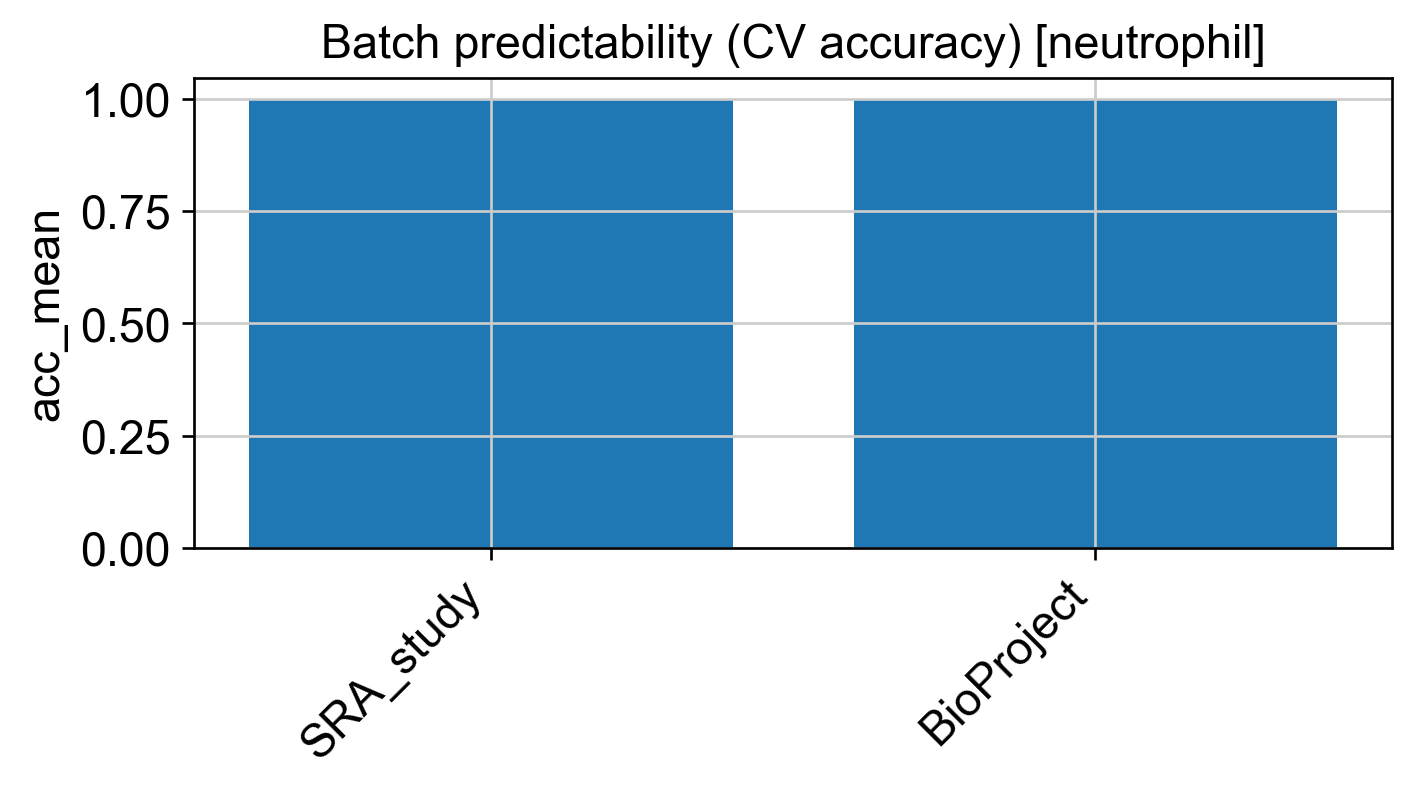

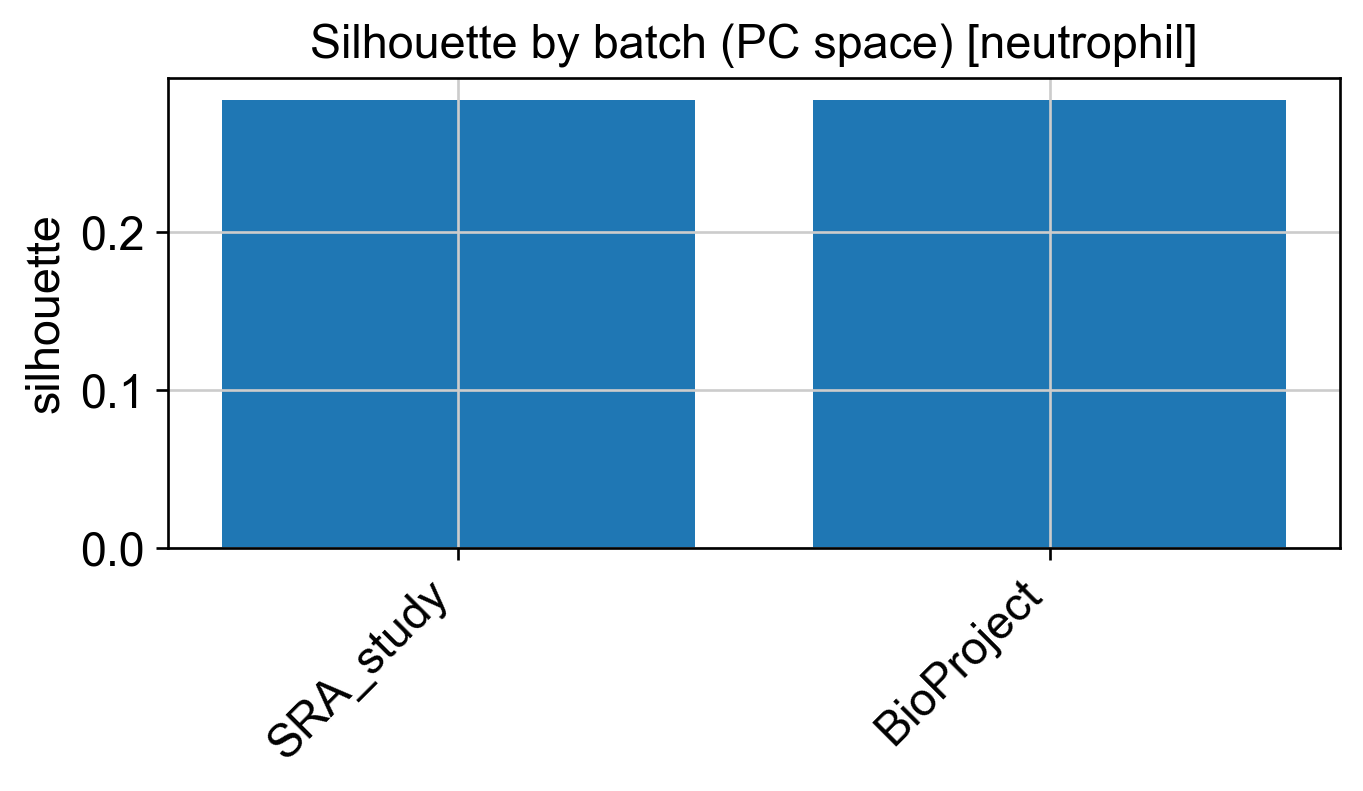

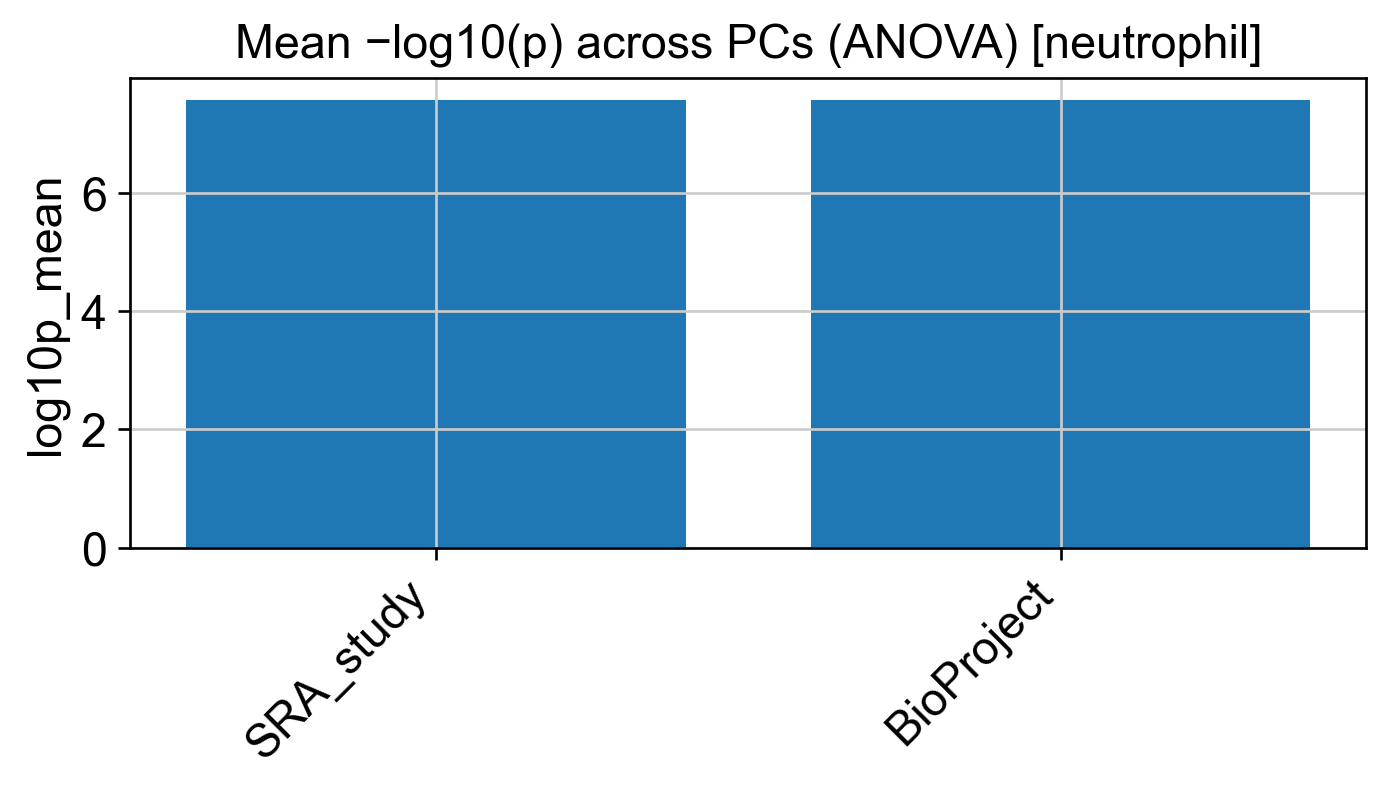

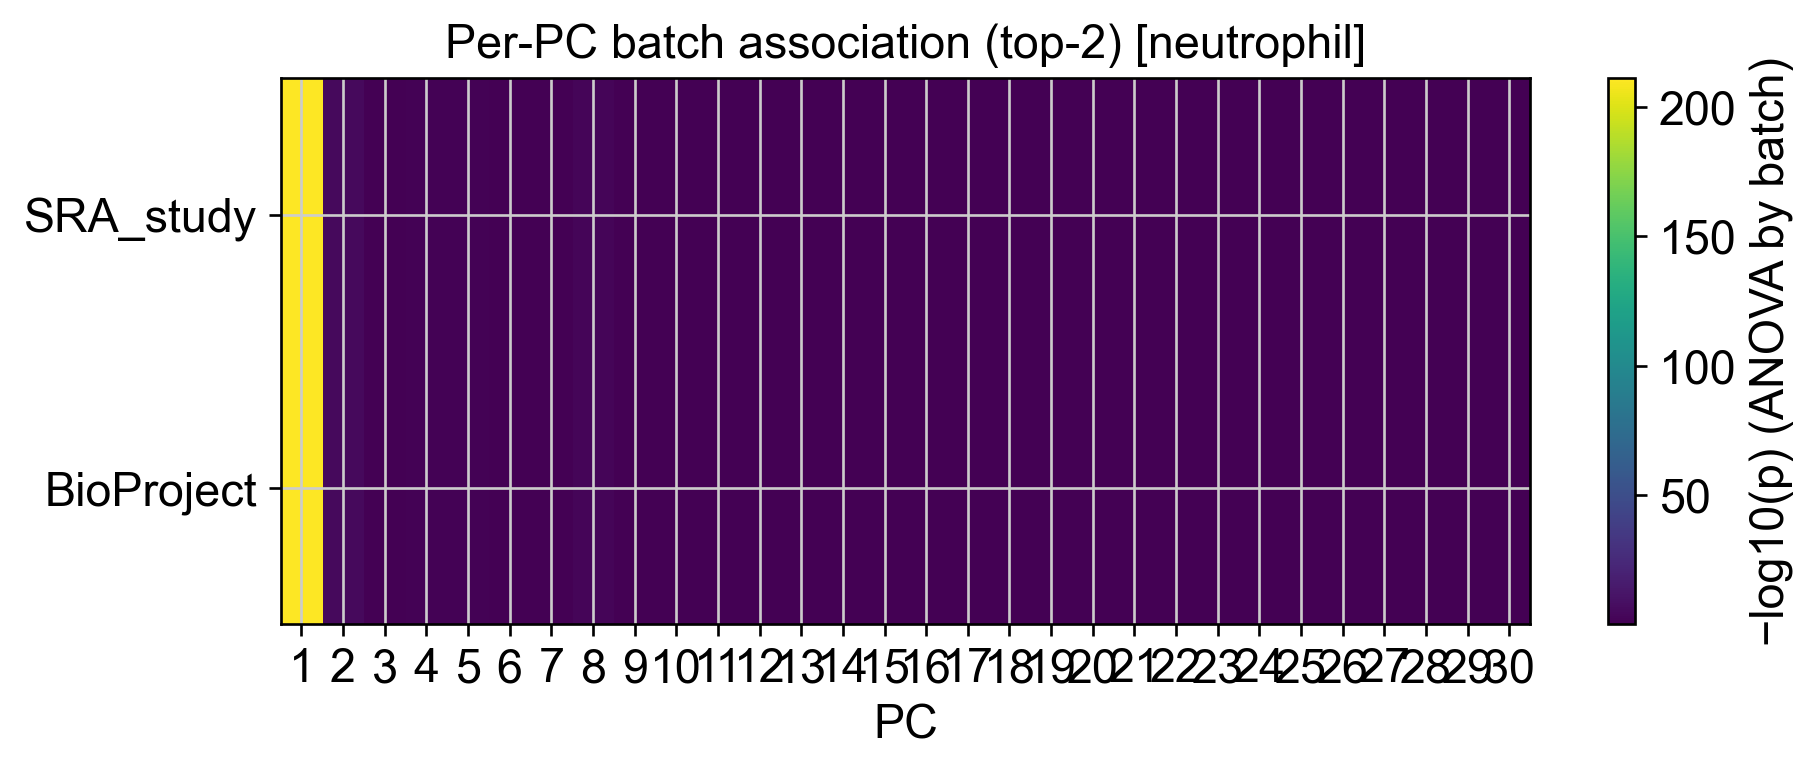

[neutrophil] Strongest batch candidates (lower rank_avg = stronger):
    batch_key  rank_avg  log10p_mean  acc_mean  silhouette  log10p_max  \
0   SRA_study       1.0      7.57497  0.997778    0.283235  211.152109   
1  BioProject       1.0      7.57497  0.997778    0.283235  211.152109   

   log10p_pc_of_max  
0                 1  
1                 1  

=== Evaluating batch keys for: covid ===
[covid] No valid batch candidates after filtering.


In [31]:
# ===========================================
# Batch selection diagnostics: RUNNABLE CODE
# ===========================================
import os, re
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import scanpy as sc
from sklearn.feature_selection import f_classif
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.metrics import silhouette_score

# ---------- config ----------
N_PCS = 30
RANDOM_STATE = 42
MIN_LEVELS = 2              # avoid constants
MAX_LEVELS = 50             # avoid near-unique IDs as batch
MIN_CELLS_PER_LEVEL = 30    # minimal support per level for stable metrics

BATCH_KEYS = [
    'Center_name','Sequencer','Lab_library_preparation_kit','Lab_RNA_extraction_protocol',
    'Lab_library_selection','Lab_library_source','Assay_type',
    'Lab_library_layout','Sample_type','Experiment','SRA_study','BioProject'
]

OUTDIR = Path("eda_outputs/batch_selection")
OUTDIR.mkdir(parents=True, exist_ok=True)

# ---------- small utilities ----------
def _sanitize(x: str) -> str:
    return re.sub(r'[^A-Za-z0-9_.-]+', '_', str(x))

def _save(fig_path: Path):
    plt.tight_layout()
    plt.savefig(fig_path, bbox_inches="tight")
    plt.show()

def ensure_pca(adata, n_pcs=N_PCS, random_state=RANDOM_STATE):
    """Compute PCA (using HVGs if present) if not already computed."""
    if 'X_pca' in adata.obsm and adata.obsm['X_pca'].shape[1] >= n_pcs:
        return
    if 'highly_variable' in adata.var:
        sc.pp.scale(adata, zero_center=True, max_value=10)
        sc.tl.pca(adata, n_comps=n_pcs, use_highly_variable=True, svd_solver='arpack', random_state=random_state)
    else:
        sc.pp.scale(adata, zero_center=True, max_value=10)
        sc.tl.pca(adata, n_comps=n_pcs, svd_solver='arpack', random_state=random_state)

def filter_candidate_keys(adata, keys, min_levels=MIN_LEVELS, max_levels=MAX_LEVELS, min_cells_per_level=MIN_CELLS_PER_LEVEL):
    """Keep keys that exist, have reasonable cardinality, and each level has enough cells."""
    present = []
    for k in keys:
        if k not in adata.obs.columns:
            continue
        s = adata.obs[k].astype(str)
        vc = s.value_counts(dropna=False)
        nlev = vc.shape[0]
        if not (min_levels <= nlev <= max_levels):
            continue
        if vc.min() < min_cells_per_level:
            continue
        present.append(k)
    return present

# ---------- metrics ----------
def metric_pc_anova(adata, batch_key, n_pcs=N_PCS):
    """Return per-PC -log10 p from ANOVA and summary stats."""
    pcs = adata.obsm['X_pca'][:, :n_pcs]
    y = pd.Categorical(adata.obs[batch_key]).codes
    # f_classif returns (F, p); we only need p
    _, pvals = f_classif(pcs, y)
    logp = -np.log10(np.maximum(pvals, 1e-300))
    return {
        "per_pc_log10p": logp,
        "log10p_mean": float(np.mean(logp)),
        "log10p_max": float(np.max(logp)),
        "log10p_pc_of_max": int(np.argmax(logp) + 1),
    }

def metric_batch_predictability(adata, batch_key, n_pcs=N_PCS, random_state=RANDOM_STATE):
    """5-fold CV accuracy predicting batch from PCs (higher = stronger batch effect)."""
    pcs = adata.obsm['X_pca'][:, :n_pcs]
    y = pd.Categorical(adata.obs[batch_key]).codes
    clf = Pipeline([
        ("scaler", StandardScaler(with_mean=True, with_std=True)),
        ("lr", LogisticRegression(max_iter=500, multi_class="auto"))
    ])
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=random_state)
    acc = cross_val_score(clf, pcs, y, cv=cv, scoring="accuracy")
    return {"acc_mean": float(acc.mean()), "acc_std": float(acc.std())}

def metric_silhouette_by_batch(adata, batch_key, n_pcs=N_PCS):
    """Silhouette score by batch in PC space (higher = stronger separation)."""
    pcs = adata.obsm['X_pca'][:, :n_pcs]
    y = pd.Categorical(adata.obs[batch_key]).codes
    # guard: silhouette fails if any class has <2 samples
    vc = pd.Series(y).value_counts()
    if (vc < 2).any():
        return {"silhouette": np.nan}
    try:
        sil = silhouette_score(pcs, y)
    except Exception:
        sil = np.nan
    return {"silhouette": float(sil) if sil == sil else np.nan}

def evaluate_batch_key(adata, batch_key, n_pcs=N_PCS):
    """Compute all metrics for a single batch key."""
    res_a = metric_pc_anova(adata, batch_key, n_pcs=n_pcs)
    res_b = metric_batch_predictability(adata, batch_key, n_pcs=n_pcs)
    res_c = metric_silhouette_by_batch(adata, batch_key, n_pcs=n_pcs)
    out = {
        "batch_key": batch_key,
        "log10p_mean": res_a["log10p_mean"],
        "log10p_max": res_a["log10p_max"],
        "log10p_pc_of_max": res_a["log10p_pc_of_max"],
        "acc_mean": res_b["acc_mean"],
        "acc_std": res_b["acc_std"],
        "silhouette": res_c["silhouette"],
        "per_pc_log10p": res_a["per_pc_log10p"],  # keep array for plotting
    }
    return out

def evaluate_all_batch_keys(adata, dataset_name, keys):
    """Evaluate multiple keys, return summary DataFrame + plots."""
    ensure_pca(adata, n_pcs=N_PCS)
    cand = filter_candidate_keys(adata, keys)
    if not cand:
        print(f"[{dataset_name}] No valid batch candidates after filtering.")
        return pd.DataFrame()

    # compute metrics
    rows = [evaluate_batch_key(adata, k) for k in cand]
    df = pd.DataFrame(rows)
    # simple composite rank (higher is worse batch effect):
    # rank by log10p_mean, acc_mean, silhouette (descending), then average ranks
    for col in ["log10p_mean", "acc_mean", "silhouette"]:
        df[f"rank_{col}"] = df[col].rank(ascending=False, method="min")
    df["rank_avg"] = df[[f"rank_{c}" for c in ["log10p_mean","acc_mean","silhouette"]]].mean(axis=1)
    df = df.sort_values("rank_avg")

    # save csv
    csv_path = OUTDIR / f"batch_metrics__{_sanitize(dataset_name)}.csv"
    df.drop(columns=["per_pc_log10p"]).to_csv(csv_path, index=False)
    print(f"[{dataset_name}] Saved metrics table → {csv_path}")

    # ---- plots: bars for acc/silhouette/log10p_mean ----
    def _barplot(col, title):
        order = df.sort_values(col, ascending=False)
        plt.figure(figsize=(6, 3.5))
        plt.bar(order["batch_key"], order[col])
        plt.xticks(rotation=45, ha="right")
        plt.ylabel(col)
        plt.title(f"{title} [{dataset_name}]")
        _save(OUTDIR / f"{_sanitize(col)}__{_sanitize(dataset_name)}.png")

    _barplot("acc_mean", "Batch predictability (CV accuracy)")
    _barplot("silhouette", "Silhouette by batch (PC space)")
    _barplot("log10p_mean", "Mean −log10(p) across PCs (ANOVA)")

    # ---- plot: heatmap of per-PC −log10p for top-K keys ----
    topK = min(6, len(df))
    top_keys = df.sort_values("rank_avg").tail(topK)["batch_key"].tolist()  # worst batch effects
    mat = np.vstack([df.loc[df["batch_key"]==k, "per_pc_log10p"].values[0] for k in top_keys])
    plt.figure(figsize=(8, 1.2*topK + 1))
    plt.imshow(mat, aspect="auto", interpolation="nearest")
    plt.colorbar(label="−log10(p) (ANOVA by batch)")
    plt.yticks(range(topK), top_keys)
    plt.xticks(range(N_PCS), range(1, N_PCS+1))
    plt.xlabel("PC")
    plt.title(f"Per-PC batch association (top-{topK}) [{dataset_name}]")
    _save(OUTDIR / f"pc_log10p_heatmap__{_sanitize(dataset_name)}.png")

    # show top-3 strongest batch drivers
    print(f"[{dataset_name}] Strongest batch candidates (lower rank_avg = stronger):")
    display_cols = ["batch_key","rank_avg","log10p_mean","acc_mean","silhouette","log10p_max","log10p_pc_of_max"]
    print(df.sort_values("rank_avg", ascending=False)[display_cols].tail(3))

    return df

# ===========================================
# EXECUTION: run for your datasets
# Assume you already have neu_adata_proc and cov_adata_proc in memory
# ===========================================
DATASETS = {
    "neutrophil": neu_adata_proc,
    "covid":      cov_adata_proc,
}

all_results = {}
for name, ad in DATASETS.items():
    print(f"\n=== Evaluating batch keys for: {name} ===")
    all_results[name] = evaluate_all_batch_keys(ad, dataset_name=name, keys=BATCH_KEYS)

# After running:
# - Check CSV files in eda_outputs/batch_selection/
# - Inspect bar plots & heatmap to decide the primary batch key(s)
